# 1. Load packages

In [315]:
import scipy.sparse as sp
import pandas as pd
import scanpy as sc
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
from mygene import MyGeneInfo

In [316]:
import numpy as np
np.NAN = np.nan

In [317]:
import omnipath as op

In [318]:
from markov_clustering import run_mcl, get_clusters

In [319]:
from matplotlib.colors import rgb2hex

In [320]:
import leidenalg

# 2. load node data

In [386]:
from pathlib import Path
import pandas as pd

# 1️⃣ Load prepared data
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

prot_expr_mean = pd.read_csv(in_dir / "proteome_expr_mean.csv", index_col=0)
phospho_expr_mean = pd.read_csv(in_dir / "phosphoproteome_expr_mean.csv", index_col=0)
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

prot_fc = pd.read_csv(in_dir / "proteome_fc.csv", index_col=0)
phospho_fc = pd.read_csv(in_dir / "phosphoproteome_fc.csv", index_col=0)

detected_uniprots = pd.read_csv(in_dir / "detected_uniprots.txt", header=None)[0].tolist()

print(f"Loaded {len(detected_uniprots)} detected UniProt IDs.")
print(f"Combined table: {combined_expr_mean.shape}")


Loaded 2916 detected UniProt IDs.
Combined table: (2915, 28)


In [387]:
combined_expr_mean

10_CXCR7_prot  600_CXCR7_prot  1800_CXCR7_prot  0_Ctrl_prot  \
UniProt                                                                   
A0A075B6I0      32.300198       32.279510        32.241415    32.233940   
A0A0A0MS15      22.607773       22.514187        22.495981    22.369619   
A0A0B4J1U7      13.584549       13.543775        13.642663    13.532822   
A0A0B4J1X5      29.572116       29.697423        29.649465    29.559103   
A0A0B4J1Y9      24.277022       24.283101        24.288321    24.264258   
...                   ...             ...              ...          ...   
Q9Y6M7                NaN             NaN              NaN          NaN   
Q9Y6N5          22.725305       22.730117        22.674017    22.679294   
Q9Y6R4                NaN             NaN              NaN          NaN   
Q9Y6W5          30.624017       30.629785        30.635891    30.616991   
Q9Y6Y8          25.179567       25.244843        25.116464    25.238395   

            10_DMSO_prot  600_DMSO_prot  1800_DMSO_prot source_prot  \
UniProt                                                               
A0A075B6I0     32.208463      32.214118       32.282510    proteome   
A0A0A0MS15     22.566267      22.504021       22.583532    proteome   
A0A0B4J1U7     13.524586      13.556860       13.520838    proteome   
A0A0B4J1X5     29.488391      29.691739       29.613414    proteome   
A0A0B4J1Y9     24.315194      24.220384       24.255841    proteome   
...                  ...            ...             ...         ...   
Q9Y6M7               NaN            NaN             NaN         NaN   
Q9Y6N5         22.722494      22.693030       22.691122    proteome   
Q9Y6R4               NaN            NaN             NaN         NaN   
Q9Y6W5         30.550942      30.578627       30.652577    proteome   
Q9Y6Y8         25.233645      25.144127       25.168106    proteome   

            10_CXCR7_phos  600_CXCR7_phos  ...  has_phospho  \
UniProt                                    ...                
A0A075B6I0            NaN             NaN  ...        False   
A0A0A0MS15            NaN             NaN  ...        False   
A0A0B4J1U7            NaN             NaN  ...        False   
A0A0B4J1X5            NaN             NaN  ...        False   
A0A0B4J1Y9            NaN             NaN  ...        False   
...                   ...             ...  ...          ...   
Q9Y6M7          20.562851       21.145496  ...         True   
Q9Y6N5          19.468881       19.274117  ...         True   
Q9Y6R4          14.202049       14.111330  ...         True   
Q9Y6W5          20.242697       20.714962  ...         True   
Q9Y6Y8                NaN             NaN  ...        False   

            10_CXCR7_combined  600_CXCR7_combined  1800_CXCR7_combined  \
UniProt                                                                  
A0A075B6I0          32.300198           32.279510            32.241415   
A0A0A0MS15          22.607773           22.514187            22.495981   
A0A0B4J1U7          13.584549           13.543775            13.642663   
A0A0B4J1X5          29.572116           29.697423            29.649465   
A0A0B4J1Y9          24.277022           24.283101            24.288321   
...                       ...                 ...                  ...   
Q9Y6M7              20.562851           21.145496            21.151269   
Q9Y6N5              19.468881           19.274117            19.083833   
Q9Y6R4              14.202049           14.111330            14.054696   
Q9Y6W5              20.242697           20.714962            20.164463   
Q9Y6Y8              25.179567           25.244843            25.116464   

            0_Ctrl_combined 10_DMSO_combined 600_DMSO_combined  \
UniProt                                                          
A0A075B6I0        32.233940        32.208463         32.214118   
A0A0A0MS15        22.369619        22.566267         22.504021   
A0A0B4J1U7        13.532822        13.524586         13.556860   

In [322]:
phospho_fc

logFC.10  P.Value.10  adj.P.Val.10  logFC.600  P.Value.600  \
UniProt                                                                  
A0A1B0GUW6 -0.487630    0.237964      0.609327  -0.121132     0.768297   
A0FGR8      0.112968    0.561838      0.836479  -0.631699     0.001758   
A0FGR8     -0.336258    0.216695      0.585516   0.364801     0.180614   
A0FGR8      0.214166    0.098726      0.419050   0.162217     0.209094   
A0FGR8      0.177454    0.753409      0.918455   0.484828     0.391870   
...              ...         ...           ...        ...          ...   
Q9Y6M1      0.196720    0.080672      0.393156  -0.028385     0.798778   
Q9Y6M7     -0.544588    0.125577      0.455553   0.391082     0.269275   
Q9Y6N5     -0.429944    0.052719      0.322845   0.284007     0.197085   
Q9Y6R4      0.010666    0.886990      0.963787   0.027229     0.716873   
Q9Y6W5     -0.550397    0.154505      0.506236   0.352554     0.359595   

            adj.P.Val.600  logFC.1800  P.Value.1800  adj.P.Val.1800  \
UniProt                                                               
A0A1B0GUW6       0.940300   -1.182801      0.005222        0.070003   
A0FGR8           0.061496    0.024567      0.899486        0.951119   
A0FGR8           0.546526    0.488185      0.074705        0.302857   
A0FGR8           0.569764    0.333042      0.011357        0.106868   
A0FGR8           0.741377    0.658353      0.246055        0.541253   
...                   ...         ...           ...             ...   
Q9Y6M1           0.952402    0.354017      0.002158        0.046987   
Q9Y6M7           0.642588    1.009433      0.005417        0.071691   
Q9Y6N5           0.554106   -0.303134      0.168953        0.448447   
Q9Y6R4           0.920523   -0.110637      0.143662        0.420182   
Q9Y6W5           0.719752   -0.524237      0.174755        0.455950   

                                                     psite_id gene_symbol  
UniProt                                                                    
A0A1B0GUW6  A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...  A0A1B0GUW6  
A0FGR8      A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...       ESYT2  
A0FGR8            A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581       ESYT2  
A0FGR8                 A0FGR8;ESYT2;S739;SSSSLLASPGHISVK;2582       ESYT2  
A0FGR8            A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736       ESYT2  
...                                                       ...         ...  
Q9Y6M1              Q9Y6M1;IGF2BP2;S162;ISYIPDEEVSSPSPPQR;698     IGF2BP2  
Q9Y6M7                     Q9Y6M7;SLC4A7;S242;KHSDPHLLER;4036      SLC4A7  
Q9Y6N5                Q9Y6N5;SQOR;S343;YPNVFGIGDCTNLPTSK;1825        SQOR  
Q9Y6R4               Q9Y6R4;MAP3K4;S1252;HSSPTEERDEPAYPR;4675      MAP3K4  
Q9Y6W5      Q9Y6W5;WASF2;T129;NSLPVPVLETYNTCDTPPPLNNLTPYR;...       WASF2  

[3150 rows x 11 columns]

In [384]:
prot_fc

logFC.10  P.Value.10  adj.P.Val.10  logFC.600  P.Value.600  \
UniProt                                                                  
A0A075B6I0  0.229630    0.326486      0.999876   0.148452     0.513700   
A0A0A0MS15  0.087997    0.869758      0.999876  -0.130536     0.802694   
A0A0B4J1U7  0.018450    0.967442      0.999876   0.020623     0.962613   
A0A0B4J1X5  0.119885    0.604642      0.999876   0.015170     0.946281   
A0A0B4J1Y9  0.073269    0.750885      0.999876   0.126968     0.572246   
...              ...         ...           ...        ...          ...   
Q9Y6K9     -0.313861    0.450839      0.999876   0.091769     0.820452   
Q9Y6M1      0.065667    0.671616      0.999876   0.014121     0.925328   
Q9Y6N5     -0.005560    0.942018      0.999876   0.009556     0.897810   
Q9Y6W5      0.098624    0.578420      0.999876   0.102934     0.551334   
Q9Y6Y8     -0.094380    0.585275      0.999876  -0.010270     0.951299   

            adj.P.Val.600  logFC.1800  P.Value.1800  adj.P.Val.1800  \
UniProt                                                               
A0A075B6I0       0.999896   -0.030090      0.894522          0.9993   
A0A0A0MS15       0.999896   -0.031189      0.952384          0.9993   
A0A0B4J1U7       0.999896    0.044284      0.919826          0.9993   
A0A0B4J1X5       0.999896    0.109947      0.625630          0.9993   
A0A0B4J1Y9       0.999896    0.031596      0.888107          0.9993   
...                   ...         ...           ...             ...   
Q9Y6K9           0.999896   -0.005538      0.989069          0.9993   
Q9Y6M1           0.999896    0.029627      0.844126          0.9993   
Q9Y6N5           0.999896   -0.033573      0.652084          0.9993   
Q9Y6W5           0.999896    0.016190      0.925243          0.9993   
Q9Y6Y8           0.999896   -0.093541      0.578456          0.9993   

           gene_symbol  
UniProt                 
A0A075B6I0  A0A075B6I0  
A0A0A0MS15  A0A0A0MS15  
A0A0B4J1U7  A0A0B4J1U7  
A0A0B4J1X5  A0A0B4J1X5  
A0A0B4J1Y9  A0A0B4J1Y9  
...                ...  
Q9Y6K9           IKBKG  
Q9Y6M1         IGF2BP2  
Q9Y6N5            SQOR  
Q9Y6W5           WASF2  
Q9Y6Y8         SEC23IP  

[2326 rows x 10 columns]

# 3. Get edges

## 3.1.  Download OmniPath interactions

In [323]:
from omnipath.interactions import OmniPath

# 1. See what parameters and resources are available
print("Query params:", OmniPath.params())        # dict of valid query-args :contentReference[oaicite:0]{index=0}
print("All resources:", OmniPath.resources())    # tuple of resource names :contentReference[oaicite:1]{index=1}

# 2. Download the full curated OmniPath network
inter = OmniPath.get()                          
print(f"Raw OmniPath: {inter.shape[0]:,} interactions")   # DataFrame



Query params: {'header': None, 'format': frozenset({'tab', 'tsv', 'table', 'json', 'text'}), 'license': frozenset({'for_profit', 'commercial', 'ignore', 'nonprofit', 'non_profit', 'academic', 'forprofit'}), 'password': None, 'limit': None, 'types': frozenset({'small_molecule_protein', 'post_translational', 'mirna_transcriptional', 'transcriptional', 'post_transcriptional', 'lncrna_post_transcriptional'}), 'sources': None, 'resources': None, 'databases': frozenset({'DoRothEA-reviews_DoRothEA', 'Wojtowicz2020', 'SIGNOR', 'UniProt_LRdb', 'STRING_talklr', 'ENCODE-distal', 'SignaLink3', 'ENCODE_tf-mirna', 'CollecTRI', 'talklr', 'ncRDeathDB', 'Reactome_SignaLink3', 'Cellinker', 'SPIKE_LC', 'RLIMS-P_ProtMapper', 'ARN', 'EMBRACE', 'GOA_CollecTRI', 'HPMR_talklr', 'KEGG-MEDICUS', 'NFIRegulomeDB_DoRothEA', 'KEGG', 'HPRD', 'PDZBase', 'IntAct', 'HTRI_CollecTRI', 'PhosphoSite_noref', 'HPRD_KEA', 'CancerDrugsDB', 'SPIKE', 'MIMP', 'BEL-Large-Corpus_ProtMapper', 'TRRUST_DoRothEA', 'PhosphoNetworks', 'G

In [324]:
# --- Define which resources to focus on (if desired) ---
focus_resources = [
    # Core signaling
    "KEGG", "Reactome", "SIGNOR",
    # Gene regulons
    "DoRothEA", "TRRUST",
    # PPI scaffold
    "BioGRID", "IntAct",
    # PTM detail (optional)
    "PhosphoSite", "iPTMnet",
    # Cell–cell communication
    "CellPhoneDB",
    # Legacy / additional
    "UniProt_LRdb", "HPRD", "Adhesome"
]

# --- Toggle filtering ---
use_mask = False  # Set to False to skip filtering by source

# --- Apply mask if requested ---
if use_mask:
    mask = inter["sources"].str.split(";").apply(
        lambda srcs: any(r in srcs for r in focus_resources)
    )
    inter = inter.loc[mask].copy()
    print(f"After resource filter: {inter.shape[0]:,} interactions")
else:
    print(f"Skipping resource filter: using all {inter.shape[0]:,} interactions")


Skipping resource filter: using all 81,529 interactions


In [325]:
inter

source  target  is_directed  is_stimulation  is_inhibition  \
0      P0DP23  P48995         True           False           True   
1      P0DP25  P48995         True           False           True   
2      P0DP24  P48995         True           False           True   
3      Q03135  P48995         True            True          False   
4      P14416  P48995         True            True          False   
...       ...     ...          ...             ...            ...   
81524  P12931  Q9UJM3         True           False          False   
81525  P43405  Q9ULZ3         True           False          False   
81526  Q14289  Q9ULZ3         True           False          False   
81527  P54646  Q9Y2I7         True           False          False   
81528  P24941  Q9Y3Z3         True           False          False   

       consensus_direction  consensus_stimulation  consensus_inhibition  \
0                     True                  False                  True   
1                     True                  False                  True   
2                     True                  False                  True   
3                     True                   True                 False   
4                     True                   True                 False   
...                    ...                    ...                   ...   
81524                False                  False                 False   
81525                False                  False                 False   
81526                False                  False                 False   
81527                False                  False                 False   
81528                False                  False                 False   

       curation_effort                                         references  \
0                    3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
1                    3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
2                    3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
3                   13  DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...   
4                    1                                      TRIP:18261457   
...                ...                                                ...   
81524                2               ProtMapper:26280531;iPTMnet:26280531   
81525                2               ProtMapper:25605870;iPTMnet:25605870   
81526                2               ProtMapper:27796369;iPTMnet:27796369   
81527                1                                   iPTMnet:24070423   
81528                7  ProtMapper:24623419;ProtMapper:26667483;ProtMa...   

                                                 sources  n_sources  \
0                                                   TRIP          1   
1                                                   TRIP          1   
2                                                   TRIP          1   
3                         DIP;HPRD;IntAct;Lit-BM-17;TRIP          5   
4                                                   TRIP          1   
...                                                  ...        ...   
81524              ProtMapper;RLIMS-P_ProtMapper;iPTMnet          3   
81525              ProtMapper;RLIMS-P_ProtMapper;iPTMnet          3   
81526              ProtMapper;RLIMS-P_ProtMapper;iPTMnet          3   
81527                                            iPTMnet          1   
81528  HPRD_MIMP;MIMP;PhosphoSite_MIMP;PhosphoSite_Pr...          9   

       n_primary_sources n_references  \
0                      1            3   
1                      1            3   
2                      1            3   
3                      5            8   
4                      1            1   
...                  ...          ...   
81524                  2            1   
81525                  2            1   
81526                  2            1   
81527                  1            1   
81528                  3            6   

      

## 3.2.  Quality filters  (mirror your R code)

In [326]:
import numpy as np

# 1. Copy from the correct DataFrame (not the built-in iter)
df = inter.copy()

# 2. Base QC: curation effort & consensus direction
df = df[df["curation_effort"] >= 2]
#df = df[df["consensus_direction"] == 2]

# 3. Assign signed “type” and drop ambiguous edges
df["type"] = np.nan
df.loc[
    df["is_stimulation"].astype(bool) | df["consensus_stimulation"].astype(bool),
    "type"
] = "activation"
df.loc[
    df["is_inhibition"].astype(bool)  | df["consensus_inhibition"].astype(bool),
    "type"
] = "inhibition"
df = df.dropna(subset=["type"])

# 4. Publication support: ≥2 distinct papers
df = df[df["n_references"] >= 2]

# 5. Cross-resource consensus: seen in ≥2 resources
df = df[df["n_sources"] >= 1]

print(f"Rows after HQ filtering: {df.shape[0]:,}")
df.head()


Rows after HQ filtering: 10,135


source  target  is_directed  is_stimulation  is_inhibition  \
0  P0DP23  P48995         True           False           True   
1  P0DP25  P48995         True           False           True   
2  P0DP24  P48995         True           False           True   
3  Q03135  P48995         True            True          False   
5  Q99750  P48995         True           False           True   

   consensus_direction  consensus_stimulation  consensus_inhibition  \
0                 True                  False                  True   
1                 True                  False                  True   
2                 True                  False                  True   
3                 True                   True                 False   
5                 True                  False                  True   

   curation_effort                                         references  \
0                3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
1                3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
2                3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
3               13  DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...   
5                3          HPRD:14530267;TRIP:14530267;TRIP:23770672   

                          sources  n_sources  n_primary_sources n_references  \
0                            TRIP          1                  1            3   
1                            TRIP          1                  1            3   
2                            TRIP          1                  1            3   
3  DIP;HPRD;IntAct;Lit-BM-17;TRIP          5                  5            8   
5                       HPRD;TRIP          2                  2            2   

                                 references_stripped        type  
0                         11290752;11983166;12601176  inhibition  
1                         11290752;11983166;12601176  inhibition  
2                         11290752;11983166;12601176  inhibition  
3  10980191;12732636;14551243;16822931;18430726;1...  activation  
5                                  14530267;23770672  inhibition

## 3.3.  Quick glance at interaction types

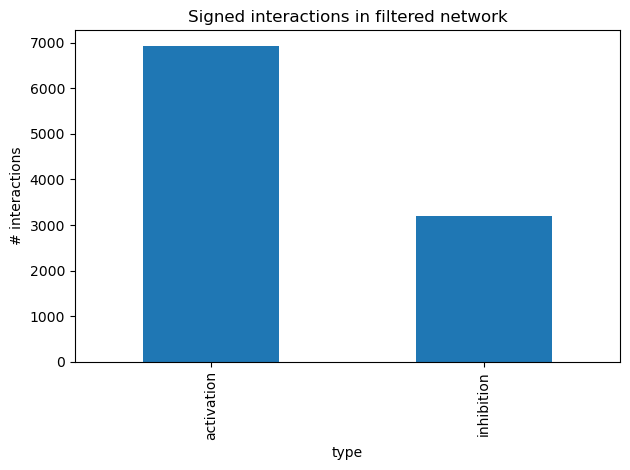

In [327]:
type_counts = df["type"].value_counts()
ax = type_counts.plot(kind="bar")
ax.set_ylabel("# interactions")
ax.set_title("Signed interactions in filtered network")
plt.tight_layout()
plt.show()

# 4. Build networks

## 4.0 inspect combined intensity table

In [328]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load combined table
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

print(f"Combined expression table shape: {combined_expr_mean.shape}")
display(combined_expr_mean.head(20))

# Optionally inspect numeric vs annotation columns
print("Numeric columns:", [c for c in combined_expr_mean.columns if combined_expr_mean[c].dtype != "object"][:10])
print("Non-numeric columns:", [c for c in combined_expr_mean.columns if combined_expr_mean[c].dtype == "object"])


Combined expression table shape: (2915, 28)


10_CXCR7_prot  600_CXCR7_prot  1800_CXCR7_prot  0_Ctrl_prot  \
UniProt                                                                   
A0A075B6I0      32.300198       32.279510        32.241415    32.233940   
A0A0A0MS15      22.607773       22.514187        22.495981    22.369619   
A0A0B4J1U7      13.584549       13.543775        13.642663    13.532822   
A0A0B4J1X5      29.572116       29.697423        29.649465    29.559103   
A0A0B4J1Y9      24.277022       24.283101        24.288321    24.264258   
A0A0C4DH43      20.924079       20.710393        20.581266    20.630867   
A0A1B0GUW6            NaN             NaN              NaN          NaN   
A0AVT1          11.487514       11.534193        11.517483    11.584648   
A0FGR8          20.622261       20.631675        20.665422    20.621037   
A1A4S6          29.505932       29.483070        29.552411    29.459800   
A1L0T0         -27.481598      -27.015436       -27.589805   -27.156975   
A1L390                NaN             NaN              NaN          NaN   
A2A2Y4                NaN             NaN              NaN          NaN   
A2RRP1          21.974815       22.197399        21.940602    21.774804   
A2RUS2          24.764790       24.733365        24.695503    24.802422   
A5YKK6          40.108087       39.931702        39.822391    39.823201   
A6NDU8          25.919773       25.855524        25.843949    25.924009   
A6NFX1          33.536257       34.023253        33.665010    33.731988   
A6NHL2          26.640880       26.408442        26.784751    26.336216   
A6NIZ1          17.128561       16.820794        16.565094    17.625976   

            10_DMSO_prot  600_DMSO_prot  1800_DMSO_prot source_prot  \
UniProt                                                               
A0A075B6I0     32.208463      32.214118       32.282510    proteome   
A0A0A0MS15     22.566267      22.504021       22.583532    proteome   
A0A0B4J1U7     13.524586      13.556860       13.520838    proteome   
A0A0B4J1X5     29.488391      29.691739       29.613414    proteome   
A0A0B4J1Y9     24.315194      24.220384       24.255841    proteome   
A0A0C4DH43     20.622972      20.419420       20.562545    proteome   
A0A1B0GUW6           NaN            NaN             NaN         NaN   
A0AVT1         11.445340      11.451980       11.441634    proteome   
A0FGR8         20.614230      20.658704       20.621974    proteome   
A1A4S6         29.481303      29.530069       29.548369    proteome   
A1L0T0        -27.684491     -26.710873      -27.235188    proteome   
A1L390               NaN            NaN             NaN         NaN   
A2A2Y4               NaN            NaN             NaN         NaN   
A2RRP1         21.924916      21.924311       21.933672    proteome   
A2RUS2         24.706444      24.815624       24.825766    proteome   
A5YKK6         39.514366      39.934316       39.975229    proteome   
A6NDU8         25.864581      25.858298       25.890519    proteome   
A6NFX1         33.419670      33.749341       33.626693    proteome   
A6NHL2         26.614485      26.673246       26.582646    proteome   
A6NIZ1         17.364398      17.108857       16.837356    proteome   

            10_CXCR7_phos  600_CXCR7_phos  ...  has_phospho  \
UniProt                                    ...                
A0A075B6I0            NaN             NaN  ...        False   
A0A0A0MS15            NaN             NaN  ...        False   
A0A0B4J1U7            NaN             NaN  ...        False   
A0A0B4J1X5            NaN             NaN  ...        False   
A0A0B4J1Y9            NaN             NaN  ...        False   
A0A0C4DH43            NaN             NaN  ...        False   
A0A1B0GUW6      18.967803       19.470706  ...         True   
A0AVT1                NaN             NaN  ...        False   
A0FGR8          23.589772       22.860872  ...         True   
A1A4S6          18.728015       19.068631  ...         True   
A1L0T0                NaN             NaN 

Numeric columns: ['10_CXCR7_prot', '600_CXCR7_prot', '1800_CXCR7_prot', '0_Ctrl_prot', '10_DMSO_prot', '600_DMSO_prot', '1800_DMSO_prot', '10_CXCR7_phos', '600_CXCR7_phos', '1800_CXCR7_phos']
Non-numeric columns: ['source_prot', 'source_phos', 'gene_symbol', 'source_combined']


In [329]:
print( combined_expr_mean.columns)

Index(['10_CXCR7_prot', '600_CXCR7_prot', '1800_CXCR7_prot', '0_Ctrl_prot',
       '10_DMSO_prot', '600_DMSO_prot', '1800_DMSO_prot', 'source_prot',
       '10_CXCR7_phos', '600_CXCR7_phos', '1800_CXCR7_phos', '0_Ctrl_phos',
       '10_DMSO_phos', '600_DMSO_phos', '1800_DMSO_phos', 'source_phos',
       'gene_symbol', 'has_proteome', 'has_phospho', '10_CXCR7_combined',
       '600_CXCR7_combined', '1800_CXCR7_combined', '0_Ctrl_combined',
       '10_DMSO_combined', '600_DMSO_combined', '1800_DMSO_combined',
       'source_combined', 'haspho_combined'],
      dtype='object')


## 4.1 big network 

In [330]:
import igraph as ig
import pandas as pd

# ======================================================
# ⚙️ 1. Load prepared data (if not already in memory)
# ======================================================
from pathlib import Path
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)
detected_uniprots = combined_expr_mean.index.tolist()

print(f"Detected UniProt IDs: {len(detected_uniprots)}")


# ======================================================
# 🧠 2. Filter OmniPath edges to measured nodes
# ======================================================
df_expr = df[
    df["source"].isin(detected_uniprots) &
    df["target"].isin(detected_uniprots)
].copy()

print(f"Edges after expression filter: {df_expr.shape[0]:,} of {df.shape[0]:,}")


# ======================================================
# 🧬 3. Build mapping UniProt → gene symbol
# ======================================================
symbol_map = combined_expr_mean["gene_symbol"].to_dict()


# ======================================================
# 🧩 4. Annotate edges with source/target symbols
# ======================================================
df_expr["source_symbol"] = df_expr["source"].map(symbol_map)
df_expr["target_symbol"] = df_expr["target"].map(symbol_map)


# ======================================================
# 🔗 5. Build igraph network
# ======================================================
edge_tuples = df_expr[["source", "target", "type"]].itertuples(index=False, name=None)

g_full = ig.Graph.TupleList(
    edge_tuples,
    directed=True,
    edge_attrs=["type"]
)

print(f"🌐 Global network constructed:")
print(f"   Nodes: {g_full.vcount():,}")
print(f"   Edges: {g_full.ecount():,}")


# ======================================================
# 🧩 6. Annotate vertices with symbols and metadata
# ======================================================
g_full.vs["gene_symbol"] = [symbol_map.get(v["name"], v["name"]) for v in g_full.vs]

# Optional: Mark which nodes have proteome/phosphoproteome data
has_prot = combined_expr_mean.loc[:, "has_proteome"].to_dict() if "has_proteome" in combined_expr_mean.columns else {}
has_phos = combined_expr_mean.loc[:, "has_phospho"].to_dict() if "has_phospho" in combined_expr_mean.columns else {}

g_full.vs["has_proteome"] = [has_prot.get(v["name"], False) for v in g_full.vs]
g_full.vs["has_phospho"] = [has_phos.get(v["name"], False) for v in g_full.vs]


# ======================================================
# 🔍 7. Preview and sanity check
# ======================================================
print("Example vertices:")
for v in g_full.vs[:10]:
    print(f"{v['name']:<12} → {v['gene_symbol']:<10} | prot:{v['has_proteome']} | phos:{v['has_phospho']}")

print("\nExample edges:")
print(df_expr.sample(5))


Detected UniProt IDs: 2915
Edges after expression filter: 1,585 of 10,135
🌐 Global network constructed:
   Nodes: 647
   Edges: 1,585
Example vertices:
P0DP24       → CALM2      | prot:True | phos:False
Q9Y210       → TRPC6      | prot:True | phos:True
P06241       → FYN        | prot:True | phos:True
P49137       → MAPKAPK2   | prot:True | phos:True
Q16539       → MAPK14     | prot:True | phos:True
P31749       → AKT1       | prot:True | phos:True
O15111       → CHUK       | prot:True | phos:False
P19838       → NFKB1      | prot:True | phos:False
P27986       → PIK3R1     | prot:True | phos:False
P78536       → ADAM17     | prot:False | phos:True

Example edges:
       source  target  is_directed  is_stimulation  is_inhibition  \
14048  P00748  P03952         True            True          False   
75804  P62136  P05198         True           False           True   
67435  Q9UEW8  P55011         True            True          False   
5237   Q06124  O00459         True           False 

## 4.2. Extract Giant Connected Component (GCC)

In [331]:
import igraph as ig

print("Vertex attributes:", g_full.vs.attributes())
print("Edge attributes:", g_full.es.attributes())

# Build GCC (weakly connected)
components = g_full.components(mode="weak")
g_gcc = components.giant()

print(f"🌐 Global network: {g_full.vcount()} nodes, {g_full.ecount()} edges")
print(f"🧩 Largest component (GCC): {g_gcc.vcount()} nodes, {g_gcc.ecount()} edges")


Vertex attributes: ['name', 'gene_symbol', 'has_proteome', 'has_phospho']
Edge attributes: ['type']
🌐 Global network: 647 nodes, 1585 edges
🧩 Largest component (GCC): 581 nodes, 1547 edges


## 4.3 Build GCC & Subnetworks with Source-Specific Thresholds

In [332]:
import igraph as ig
import pandas as pd
import numpy as np
from pathlib import Path

# ======================================================
# ⚙️ 1. Parameters
# ======================================================
PROTEOME_THRESHOLD = 9         # Stable proteome backbone threshold
PHOSPHO_THRESHOLD = 12.75      # Dynamic phosphosite threshold
EXPORT_GRAPHML = True          # Export subnetworks to GraphML
VERBOSE = True                 # Print detailed per-condition info

print(f"🧩 Using thresholds — Proteome backbone: {PROTEOME_THRESHOLD}, Phospho dynamic: {PHOSPHO_THRESHOLD}")

# ======================================================
# 📂 2. Load combined expression data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"
merged_path = in_dir / "combined_expr_mean.csv"

if not merged_path.exists():
    raise FileNotFoundError(f"❌ Missing input file: {merged_path}")

merged = pd.read_csv(merged_path, index_col=0)
print(f"📄 Loaded combined expression table: {merged.shape[0]} proteins × {merged.shape[1]} columns")

# Identify timepoint columns (combined)
combined_cols = [
    c for c in merged.columns
    if "_combined" in c and not c.startswith(("source", "haspho"))
]
conditions = [c.replace("_combined", "") for c in combined_cols]
print(f"✅ Detected {len(conditions)} timepoints: {conditions}")

# Ensure numeric values
merged[combined_cols] = merged[combined_cols].apply(pd.to_numeric, errors="coerce")

# Normalize source labels
merged["source_combined"] = merged["source_combined"].astype(str).str.strip().str.lower()

# ======================================================
# 🧬 3. Define the static proteome backbone
# ======================================================
backbone_mask = (
    (merged["source_combined"] != "phosphoproteome") &
    (merged[combined_cols].max(axis=1) > PROTEOME_THRESHOLD)
)
backbone_nodes = merged.index[backbone_mask].tolist()

print(f"🧬 Static proteome backbone established: {len(backbone_nodes)} nodes > {PROTEOME_THRESHOLD}")

# ======================================================
# 🧩 4. Build subnetworks per condition/timepoint
# ======================================================
if "g_gcc" not in globals():
    raise RuntimeError("❌ Variable g_gcc (Giant Connected Component graph) not defined in environment.")

subnetworks = {}
summary_records = []

for cond in conditions:
    expr_col = f"{cond}_combined"
    if expr_col not in merged.columns:
        print(f"⚠️ Skipping missing expression column: {expr_col}")
        continue

    # ---- Select dynamic phospho nodes ----
    phospho_mask = (
        (merged["source_combined"] == "phosphoproteome") &
        (merged[expr_col] > PHOSPHO_THRESHOLD)
    )
    phospho_active = merged.index[phospho_mask].tolist()

    # ---- Merge backbone + dynamic ----
    active_nodes = list(set(backbone_nodes) | set(phospho_active))
    active_nodes = [n for n in active_nodes if n in g_gcc.vs["name"]]  # restrict to GCC
    sub_g = g_gcc.subgraph(g_gcc.vs.select(name_in=active_nodes))
    subnetworks[cond] = sub_g

    n_prot = len(set(backbone_nodes) & set(active_nodes))
    n_phospho = len(set(phospho_active) & set(g_gcc.vs["name"]))
    summary_records.append((cond, sub_g.vcount(), sub_g.ecount(), n_prot, n_phospho))

    if VERBOSE:
        print(f"{cond:<12}: {sub_g.vcount():>4} nodes ({n_prot} prot, {n_phospho} phospho), {sub_g.ecount():>5} edges")

# ======================================================
# 📊 5. Summarize and compute network metrics
# ======================================================
def summarize_network(g: ig.Graph, label: str) -> pd.DataFrame:
    """Compute key centrality metrics for a given subnetwork."""
    if g.vcount() == 0:
        return pd.DataFrame()
    return pd.DataFrame({
        "uniprot_id": g.vs["name"],
        "gene_symbol": g.vs["gene_symbol"],
        "betweenness": g.betweenness(directed=True),
        "degree": g.degree(),
        "in_degree": g.degree(mode="in"),
        "out_degree": g.degree(mode="out"),
        "density": g.density(),
        "network": label
    })

subnet_metrics = pd.concat(
    [summarize_network(g, cond) for cond, g in subnetworks.items()],
    ignore_index=True
)

print(f"\n✅ Computed metrics for {len(subnetworks)} subnetworks "
      f"({subnet_metrics.shape[0]} total nodes)")

# ======================================================
# 💾 6. Save results
# ======================================================
out_dir = in_dir.parent / "subnetworks"
out_dir.mkdir(exist_ok=True)

# Save metrics
metrics_path = out_dir / "subnetwork_metrics.csv"
subnet_metrics.to_csv(metrics_path, index=False)
print(f"💾 Saved subnetwork metrics → {metrics_path}")

# Save network summaries
summary_df = pd.DataFrame(summary_records, columns=["Condition", "Nodes", "Edges", "Proteome", "Phospho"])
summary_df.to_csv(out_dir / "subnetwork_summary.csv", index=False)
print(f"💾 Saved subnetwork summary → {out_dir / 'subnetwork_summary.csv'}")

# Optional: Export each subnetwork to GraphML
if EXPORT_GRAPHML:
    for cond, g_sub in subnetworks.items():
        path = out_dir / f"{cond}_subnetwork.graphml"
        g_sub.write_graphml(str(path))
    print(f"📂 Exported {len(subnetworks)} subnetworks to GraphML in {out_dir}")

print("\n✅ Finished building static-backbone, dynamic-phospho subnetworks.")


🧩 Using thresholds — Proteome backbone: 9, Phospho dynamic: 12.75
📄 Loaded combined expression table: 2915 proteins × 28 columns
✅ Detected 7 timepoints: ['10_CXCR7', '600_CXCR7', '1800_CXCR7', '0_Ctrl', '10_DMSO', '600_DMSO', '1800_DMSO']
🧬 Static proteome backbone established: 1443 nodes > 9
10_CXCR7    :  464 nodes (190 prot, 274 phospho),  1078 edges
600_CXCR7   :  465 nodes (190 prot, 275 phospho),  1105 edges
1800_CXCR7  :  467 nodes (190 prot, 277 phospho),  1098 edges
0_Ctrl      :  463 nodes (190 prot, 273 phospho),  1074 edges
10_DMSO     :  463 nodes (190 prot, 273 phospho),  1076 edges
600_DMSO    :  466 nodes (190 prot, 276 phospho),  1097 edges
1800_DMSO   :  461 nodes (190 prot, 271 phospho),  1069 edges

✅ Computed metrics for 7 subnetworks (3249 total nodes)
💾 Saved subnetwork metrics → analysis/networks/subnetworks/subnetwork_metrics.csv
💾 Saved subnetwork summary → analysis/networks/subnetworks/subnetwork_summary.csv
📂 Exported 7 subnetworks to GraphML in analysis/ne

## 4.4 Check for proteins of interest

In [333]:
import pandas as pd
import igraph as ig

def inspect_protein_across_layers(
    gene_symbol,
    uniprot_id,
    inter,         # raw OmniPath (edges)
    df,            # HQ filtered OmniPath (edges or nodes)
    combined_expr_mean,  # expression table (nodes)
    df_expr,       # expression-filtered OmniPath (edges)
    g_gcc          # network (giant component)
):
    """Inspect a protein across multiple dataset layers with robust type detection."""

    def _section(title):
        print("=" * 70)
        print(f"🔎 {title}")
        print("=" * 70)

    def _detect_edge_cols(df_like, name="dataset"):
        """Detect edge column names (source/target) dynamically."""
        possible_sources = ["source", "uniprot_source", "from", "src", "A", "geneA"]
        possible_targets = ["target", "uniprot_target", "to", "tgt", "B", "geneB"]
        src = next((c for c in possible_sources if c in df_like.columns), None)
        tgt = next((c for c in possible_targets if c in df_like.columns), None)
        if not src or not tgt:
            print(f"⚙️ {name} appears node-level (no edges). Skipping edge lookup.")
            return None, None
        else:
            print(f"✅ {name}: using columns '{src}' (source), '{tgt}' (target)")
        return src, tgt

    print(f"\n🔬 Checking presence of {gene_symbol} ({uniprot_id}) across datasets...\n")

    # ======================================================
    # 1️⃣ Raw OmniPath
    # ======================================================
    _section("1️⃣ Raw OmniPath (unfiltered)")
    src_raw, tgt_raw = _detect_edge_cols(inter, "Raw OmniPath")
    if src_raw and tgt_raw:
        raw_hits = inter[(inter[src_raw] == uniprot_id) | (inter[tgt_raw] == uniprot_id)]
    else:
        raw_hits = pd.DataFrame()
    print(f"📦 Raw OmniPath total: {len(inter):,} edges")
    print(f" → {len(raw_hits):,} edges involve {gene_symbol}")
    display(raw_hits.head(10)) if not raw_hits.empty else print(f"⚠️ {gene_symbol} not found in raw OmniPath.")

    # ======================================================
    # 2️⃣ HQ Filtered OmniPath
    # ======================================================
    _section("2️⃣ HQ Filtered OmniPath (after curation filter)")
    src_filt, tgt_filt = _detect_edge_cols(df, "HQ Filtered OmniPath")
    if src_filt and tgt_filt:
        filt_hits = df[(df[src_filt] == uniprot_id) | (df[tgt_filt] == uniprot_id)]
        print(f"📊 Filtered OmniPath total: {len(df):,} edges")
        print(f" → {len(filt_hits):,} edges involve {gene_symbol}")
        display(filt_hits.head(10)) if not filt_hits.empty else print(f"⚠️ {gene_symbol} not found in HQ-filtered OmniPath.")
    else:
        filt_hits = pd.DataFrame()

    # ======================================================
    # 3️⃣ Expression Table
    # ======================================================
    _section("3️⃣ Expression Table (combined_expr_mean.csv)")
    if uniprot_id in combined_expr_mean.index:
        expr_hit = combined_expr_mean.loc[[uniprot_id]]
        print(f"✅ {gene_symbol} ({uniprot_id}) present in expression data.")
        display(expr_hit.filter(regex='_combined|gene_symbol'))
    else:
        print(f"⚠️ {gene_symbol} not present in expression table.")

    # ======================================================
    # 4️⃣ Expression-Filtered OmniPath
    # ======================================================
    _section("4️⃣ Expression-Filtered OmniPath (edges between expressed nodes)")
    src_expr, tgt_expr = _detect_edge_cols(df_expr, "Expression-filtered OmniPath")
    if src_expr and tgt_expr:
        expr_filt_hits = df_expr[(df_expr[src_expr] == uniprot_id) | (df_expr[tgt_expr] == uniprot_id)]
    else:
        expr_filt_hits = pd.DataFrame()
    print(f"🧬 Expression-filtered OmniPath total: {len(df_expr):,} edges")
    print(f" → {len(expr_filt_hits):,} edges involve {gene_symbol}")
    display(expr_filt_hits.head(10)) if not expr_filt_hits.empty else print(f"⚠️ {gene_symbol} not found among expressed-node edges.")

    # ======================================================
    # 5️⃣ GCC (network-level representation)
    # ======================================================
    _section("5️⃣ Network representation (GCC)")
    if g_gcc is None or g_gcc.vcount() == 0:
        print("⚠️ GCC network not available or empty.")
        return

    matches = [v for v in g_gcc.vs if v["name"] == uniprot_id or v["gene_symbol"] == gene_symbol]
    if not matches:
        print(f"⚠️ {gene_symbol} ({uniprot_id}) not found in GCC network.")
    else:
        v = matches[0]
        indeg = g_gcc.degree(v, mode="in")
        outdeg = g_gcc.degree(v, mode="out")
        totaldeg = indeg + outdeg
        btw = g_gcc.betweenness(v)
        btw = btw[0] if isinstance(btw, list) else btw
        print(f"✅ {gene_symbol} ({uniprot_id}) found in GCC:")
        print(f"  In-degree:  {indeg}")
        print(f"  Out-degree: {outdeg}")
        print(f"  Total degree: {totaldeg}")
        print(f"  Betweenness: {btw:.4f}")

        # --- Partner info ---
        def _partner_list(v, mode):
            edges = g_gcc.incident(v, mode=mode)
            partners = []
            for e in edges:
                eid = g_gcc.es[e]
                src, tgt = eid.source, eid.target
                partner = src if mode == "in" else tgt
                partners.append((g_gcc.vs[partner]["gene_symbol"], g_gcc.vs[partner]["name"]))
            return partners

        in_partners = _partner_list(v, "in")
        out_partners = _partner_list(v, "out")

        print(f"\n  🔼 Incoming ({len(in_partners)}):")
        for gsym, uid in in_partners[:10]:
            print(f"   - {gsym} ({uid})")

        print(f"\n  🔽 Outgoing ({len(out_partners)}):")
        for gsym, uid in out_partners[:10]:
            print(f"   - {gsym} ({uid})")

    # ======================================================
    # ✅ Summary
    # ======================================================
    print("\n✅ Summary:")
    print(f"  Raw OmniPath edges:        {len(raw_hits):>5}")
    print(f"  HQ Filtered OmniPath:      {len(filt_hits):>5}")
    print(f"  Expression Table present:  {uniprot_id in combined_expr_mean.index}")
    print(f"  Expressed-node edges:      {len(expr_filt_hits):>5}")
    print(f"  In GCC network:            {len(matches) > 0}")
    print("=" * 70)


In [334]:
inspect_protein_across_layers(
    gene_symbol="PRKG1",
    uniprot_id="Q13976",
    inter=inter,
    df=df,
    combined_expr_mean=combined_expr_mean,
    df_expr=df_expr,
    g_gcc=g_gcc
)



🔬 Checking presence of PRKG1 (Q13976) across datasets...

🔎 1️⃣ Raw OmniPath (unfiltered)
✅ Raw OmniPath: using columns 'source' (source), 'target' (target)
📦 Raw OmniPath total: 81,529 edges
 → 108 edges involve PRKG1


source  target  is_directed  is_stimulation  is_inhibition  \
32     Q13976  Q13507         True           False           True   
53     Q13976  Q9HCX4         True            True          False   
2146   Q13976  O14974         True            True           True   
8932   Q13976  Q9Y613         True            True          False   
9838   Q13976  P11831         True            True          False   
10125  Q13976  P41220         True            True          False   
10968  P17252  Q13976         True            True          False   
12129  Q13976  Q9UH03         True            True          False   
12590  Q13976  Q14847         True           False           True   
13896  Q13976  Q15637         True           False           True   

       consensus_direction  consensus_stimulation  consensus_inhibition  \
32                    True                  False                  True   
53                    True                   True                 False   
2146                  True                  False                  True   
8932                  True                   True                 False   
9838                  True                   True                 False   
10125                 True                   True                 False   
10968                 True                   True                 False   
12129                 True                   True                 False   
12590                 True                  False                  True   
13896                 True                  False                  True   

       curation_effort                                         references  \
32                   9  HPRD:14983059;KEA:14983059;ProtMapper:14983059...   
53                   3     SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151   
2146                 8  HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...   
8932                10  HPRD:15051728;KEA:15051728;PhosphoSite:1505172...   
9838                 2                ProtMapper:19778940;SIGNOR:12809504   
10125               10  HPRD-phos:14608379;HPRD:14608379;KEA:14608379;...   
10968                9  HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...   
12129                5  HPRD-phos:15107017;HPRD:15107017;KEA:15107017;...   
12590                7  HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...   
13896                9  HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...   

                                                 sources  n_sources  \
32     HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...         15   
53                                   SIGNOR;TRIP;iPTMnet          3   
2146   HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...         10   
8932   HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...         15   
9838   MIMP;PhosphoSite_MIMP;PhosphoSite_ProtMapper;P...          7   
10125  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Net...         19   
10968  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...         18   
12129  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         10   
12590  BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...         15   
13896  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         15   

       n_primary_sources n_references                  references_stripped  
32                     8            2                    14983059;16331690  
53                     3            1                             21402151  
2146                   7            4  10567269;10579722;15194681;19120700  
8932                   9            2                    15051728;21106951  
9838                   3            2                    12809504;19778940  
10125                 10            3           14608379;17570479;24777815  
10968                 10            2                    12609995;17570479  
12129                  6            1                             15107017  
12590                  8            2                    12432067;12571245  
13896                

🔎 2️⃣ HQ Filtered OmniPath (after curation filter)
✅ HQ Filtered OmniPath: using columns 'source' (source), 'target' (target)
📊 Filtered OmniPath total: 10,135 edges
 → 18 edges involve PRKG1


source  target  is_directed  is_stimulation  is_inhibition  \
32     Q13976  Q13507         True           False           True   
2146   Q13976  O14974         True            True           True   
8932   Q13976  Q9Y613         True            True          False   
9838   Q13976  P11831         True            True          False   
10125  Q13976  P41220         True            True          False   
10968  P17252  Q13976         True            True          False   
12590  Q13976  Q14847         True           False           True   
13896  Q13976  Q15637         True           False           True   
14441  Q13976  P04792         True           False           True   
14625  Q13976  P35367         True           False           True   

       consensus_direction  consensus_stimulation  consensus_inhibition  \
32                    True                  False                  True   
2146                  True                  False                  True   
8932                  True                   True                 False   
9838                  True                   True                 False   
10125                 True                   True                 False   
10968                 True                   True                 False   
12590                 True                  False                  True   
13896                 True                  False                  True   
14441                 True                  False                  True   
14625                 True                  False                  True   

       curation_effort                                         references  \
32                   9  HPRD:14983059;KEA:14983059;ProtMapper:14983059...   
2146                 8  HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...   
8932                10  HPRD:15051728;KEA:15051728;PhosphoSite:1505172...   
9838                 2                ProtMapper:19778940;SIGNOR:12809504   
10125               10  HPRD-phos:14608379;HPRD:14608379;KEA:14608379;...   
10968                9  HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...   
12590                7  HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...   
13896                9  HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...   
14441                9  KEA:17570479;PhosphoSite:17351657;PhosphoSite:...   
14625                9  KEA:10101032;KEA:15107581;ProtMapper:10101032;...   

                                                 sources  n_sources  \
32     HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...         15   
2146   HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...         10   
8932   HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...         15   
9838   MIMP;PhosphoSite_MIMP;PhosphoSite_ProtMapper;P...          7   
10125  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Net...         19   
10968  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...         18   
12590  BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...         15   
13896  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         15   
14441  HPRD_MIMP;KEA;MIMP;NetworKIN_KEA;PhosphoSite;P...         15   
14625  KEA;MIMP;PhosphoPoint;PhosphoSite_KEA;PhosphoS...         12   

       n_primary_sources n_references  \
32                     8            2   
2146                   7            4   
8932                   9            2   
9838                   3            2   
10125                 10            3   
10968                 10            2   
12590                  8            2   
13896                  9            2   
14441                  6            7   
14625                  7            2   

                                     references_stripped        type  
32                                     14983059;16331690  inhibition  
2146                 10567269;10579722;15194681;19120700  inhibition  
8932                                   15051728;21106951  activation  
9838                                   12809504;1977894

🔎 3️⃣ Expression Table (combined_expr_mean.csv)
✅ PRKG1 (Q13976) present in expression data.


gene_symbol  10_CXCR7_combined  600_CXCR7_combined  \
UniProt                                                      
Q13976        PRKG1          11.572649           11.762265   

         1800_CXCR7_combined  0_Ctrl_combined  10_DMSO_combined  \
UniProt                                                           
Q13976             11.785922        11.818758         11.956233   

         600_DMSO_combined  1800_DMSO_combined  source_combined  \
UniProt                                                           
Q13976           11.565544           11.556775  phosphoproteome   

         haspho_combined  
UniProt                   
Q13976              True

🔎 4️⃣ Expression-Filtered OmniPath (edges between expressed nodes)
✅ Expression-filtered OmniPath: using columns 'source' (source), 'target' (target)
🧬 Expression-filtered OmniPath total: 1,585 edges
 → 11 edges involve PRKG1


source  target  is_directed  is_stimulation  is_inhibition  \
2146   Q13976  O14974         True            True           True   
8932   Q13976  Q9Y613         True            True          False   
10968  P17252  Q13976         True            True          False   
12590  Q13976  Q14847         True           False           True   
13896  Q13976  Q15637         True           False           True   
14441  Q13976  P04792         True           False           True   
32976  Q13976  P50552         True            True           True   
44739  Q13976  Q01970         True           False           True   
63762  Q13976  P31645         True            True          False   
76221  Q13976  O76074         True            True          False   

       consensus_direction  consensus_stimulation  consensus_inhibition  \
2146                  True                  False                  True   
8932                  True                   True                 False   
10968                 True                   True                 False   
12590                 True                  False                  True   
13896                 True                  False                  True   
14441                 True                  False                  True   
32976                 True                  False                  True   
44739                 True                  False                  True   
63762                 True                   True                 False   
76221                 True                   True                 False   

       curation_effort                                         references  \
2146                 8  HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...   
8932                10  HPRD:15051728;KEA:15051728;PhosphoSite:1505172...   
10968                9  HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...   
12590                7  HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...   
13896                9  HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...   
14441                9  KEA:17570479;PhosphoSite:17351657;PhosphoSite:...   
32976               32  HPRD-phos:12576312;HPRD-phos:17287340;HPRD-pho...   
44739               11  HPRD-phos:11278298;HPRD-phos:19651622;HPRD:112...   
63762                7  PhosphoSite:16112691;PhosphoSite:17310063;Phos...   
76221                6  HPRD:2168396;KEA:17570479;KEA:2168396;ProtMapp...   

                                                 sources  n_sources  \
2146   HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...         10   
8932   HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...         15   
10968  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...         18   
12590  BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...         15   
13896  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         15   
14441  HPRD_MIMP;KEA;MIMP;NetworKIN_KEA;PhosphoSite;P...         15   
32976  BEL-Large-Corpus_ProtMapper;HPRD;HPRD-phos;HPR...         21   
44739  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         14   
63762  MIMP;PhosphoSite;PhosphoSite_MIMP;PhosphoSite_...          9   
76221  BEL-Large-Corpus_ProtMapper;HPRD;HPRD_KEA;HPRD...         16   

       n_primary_sources n_references  \
2146                   7            4   
8932                   9            2   
10968                 10            2   
12590                  8            2   
13896                  9            2   
14441                  6            7   
32976                  8           18   
44739                  8            5   
63762                  5            4   
76221                  8            4   

                                     references_stripped        type  \
2146                 10567269;10579722;15194681;19120700  inhibition   
8932                                   15051728;21106951  activation   
10968                                  12609995;17570479  activation   
12590                                  12432067;125

🔎 5️⃣ Network representation (GCC)
✅ PRKG1 (Q13976) found in GCC:
  In-degree:  1
  Out-degree: 10
  Total degree: 11
  Betweenness: 1529.4426

  🔼 Incoming (1):
   - PRKCA (P17252)

  🔽 Outgoing (10):
   - PPP1R12A (O14974)
   - HSPB1 (P04792)
   - PLCB3 (Q01970)
   - FHOD1 (Q9Y613)
   - LASP1 (Q14847)
   - SF1 (Q15637)
   - VASP (P50552)
   - SLC6A4 (P31645)
   - PDE5A (O76074)
   - IRAG1 (Q9Y6F6)

✅ Summary:
  Raw OmniPath edges:          108
  HQ Filtered OmniPath:         18
  Expression Table present:  True
  Expressed-node edges:         11
  In GCC network:            True


# 5. Analyse network

## 5.1 Betweenness Centrality Changes over time

### 5.1.1 Absolute Betweness Centrality Changes over time

Loaded betweenness metrics: (3249, 8)

📊 CXCR7 absolute betweenness shape: (467, 4)
📊 DMSO absolute betweenness shape: (467, 4)

🔍 Computing deviation metrics for all genes...


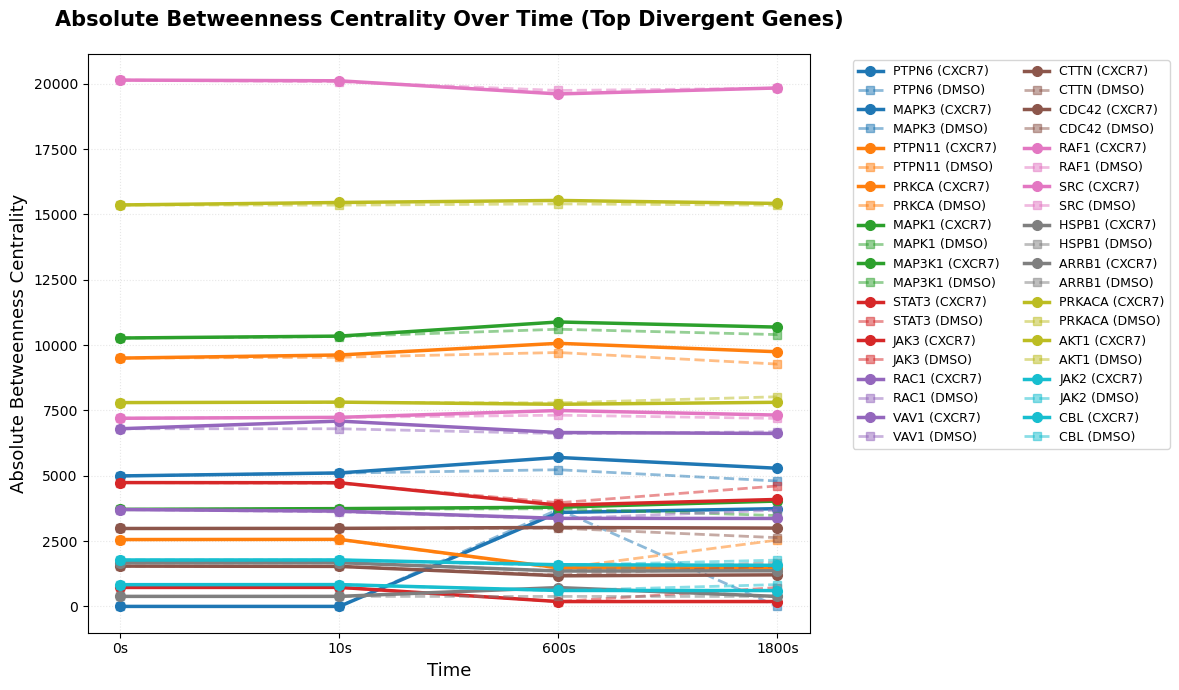

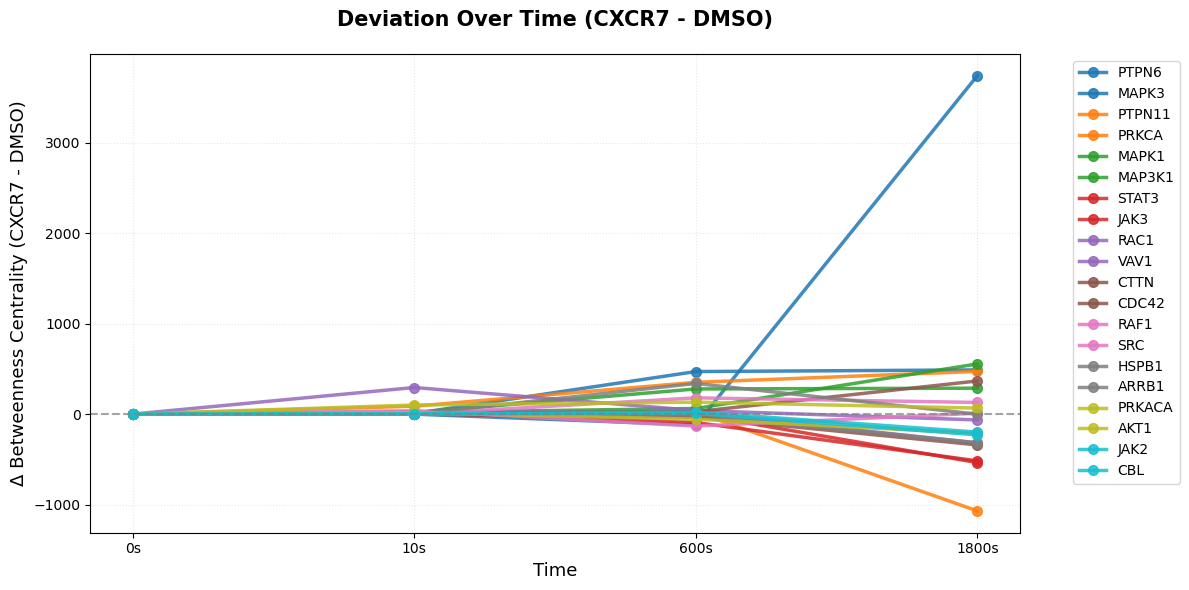


📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)
             Rank uniprot_id                                       phosphosite(s)  dtw_distance  cosine_dissimilarity  euclidean_distance      slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                                                                     
PTPN6           1     P29350              P29350;PTPN6;Y536;GQESEYGNITYPPAMK;3261      500.6912                0.3071           3742.2383  1110.1291     0.5744      0.2421        0.3162         0.6838   3740.3241  increasing
MAPK3           2     P27361                                                  NaN      143.9295                0.0010            677.9572   192.8270     0.8203      0.0943        1.0000         0.0000    488.2677  increasing
PTPN11          3     Q06124  Q

In [335]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")

metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    """Return pivot (gene × time) for ABSOLUTE betweenness values."""
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0, observed=False)
    return pivot

def cosine_dissimilarity(v1, v2):
    """1 - cosine similarity between two trajectories."""
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    """Dynamic Time Warping distance between two vectors."""
    alignment = dtw(v1.reshape(-1, 1), v2.reshape(-1, 1))
    return float(alignment.normalizedDistance)

def euclidean_distance(v1, v2):
    """Euclidean distance between two vectors."""
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(deviation_series):
    """Compute linear regression slope of deviation over time."""
    time_numeric = np.arange(len(deviation_series))
    slope, intercept, r_value, p_value, std_err = linregress(time_numeric, deviation_series)
    return slope, r_value**2, p_value

def compute_monotonic_trend(deviation_series):
    """Compute Spearman correlation for monotonic trend."""
    time_numeric = np.arange(len(deviation_series))
    rho, p_value = spearmanr(time_numeric, deviation_series)
    return rho, p_value

def directional_change(deviation_series):
    """Net change from first to last timepoint."""
    return deviation_series.iloc[-1] - deviation_series.iloc[0]

# ======================================================
# 🧮 Compute ABSOLUTE betweenness trajectories
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}

# Align by common genes
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)
cxcr7_absolute = pivots["CXCR7"].loc[common_genes]
dmso_absolute = pivots["DMSO"].loc[common_genes]

# Rename columns to timepoints for easier alignment
timepoints = ['0s', '10s', '600s', '1800s']
cxcr7_absolute.columns = timepoints
dmso_absolute.columns = timepoints

print(f"\n📊 CXCR7 absolute betweenness shape: {cxcr7_absolute.shape}")
print(f"📊 DMSO absolute betweenness shape: {dmso_absolute.shape}")

# ======================================================
# 🧮 Compute DEVIATION metrics (DTW, Cosine, Euclidean)
# ======================================================
print("\n🔍 Computing deviation metrics for all genes...")

divergence = []
for gene in common_genes:
    v_cxcr7 = np.array(cxcr7_absolute.loc[gene], dtype=float)
    v_dmso = np.array(dmso_absolute.loc[gene], dtype=float)
    
    # Compute divergence metrics
    cos_diff = cosine_dissimilarity(v_cxcr7, v_dmso)
    dtw_diff = dtw_distance(v_cxcr7, v_dmso)
    eucl_diff = euclidean_distance(v_cxcr7, v_dmso)
    
    divergence.append((gene, cos_diff, dtw_diff, eucl_diff))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 🧬 Add phosphosite information (merge by UniProt ID)
# ======================================================
phospho_path = base / "analysis" / "networks" / "prepared_data" / "phospho_intensity.csv"

if phospho_path.exists():
    phospho_df = pd.read_csv(phospho_path)
    phospho_df.columns = [c.lower() for c in phospho_df.columns]

    uniprot_col = next((c for c in phospho_df.columns if "uniprot" in c or "accession" in c or "protein" in c), None)
    gene_col = next((c for c in phospho_df.columns if "gene" in c), None)
    site_col = next((c for c in phospho_df.columns if "site" in c or "position" in c or "residue" in c), None)

    if uniprot_col and gene_col:
        subset_cols = [c for c in [gene_col, uniprot_col, site_col] if c]
        phospho_map = phospho_df[subset_cols].drop_duplicates()

        if site_col:
            phospho_map = (
                phospho_map.groupby([gene_col, uniprot_col])[site_col]
                .apply(lambda x: ";".join(sorted(set(x.dropna().astype(str)))))
                .reset_index()
                .rename(columns={site_col: "phosphosite(s)", gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            )
        else:
            phospho_map = phospho_map.rename(columns={gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            phospho_map["phosphosite(s)"] = np.nan

        if "uniprot_id" in metrics.columns:
            gene_to_uniprot = metrics[["gene_symbol", "uniprot_id"]].drop_duplicates()
        else:
            gene_to_uniprot = phospho_map[["gene_symbol", "uniprot_id"]].drop_duplicates()

        divergence_df = (
            divergence_df.reset_index()
            .merge(gene_to_uniprot, on="gene_symbol", how="left")
            .merge(phospho_map[["uniprot_id", "phosphosite(s)"]], on="uniprot_id", how="left")
            .set_index("gene_symbol")
        )

        front_cols = ["uniprot_id", "phosphosite(s)"]
        divergence_df = divergence_df[[*front_cols, *[c for c in divergence_df.columns if c not in front_cols]]]

# ======================================================
# 📈 Select top candidates
# ======================================================
N_TOP = 20
top_genes = divergence_df.head(N_TOP).index
delta_absolute = cxcr7_absolute.loc[top_genes] - dmso_absolute.loc[top_genes]

# ======================================================
# 📈 Compute temporal trend metrics
# ======================================================
trend_metrics = []
for gene in top_genes:
    dev_series = delta_absolute.loc[gene]
    slope, r2, p_val = compute_trend_slope(dev_series)
    rho, rho_p = compute_monotonic_trend(dev_series)
    net_change = directional_change(dev_series)
    trend_direction = 'increasing' if slope > 0 else ('decreasing' if slope < 0 else 'stable')
    trend_metrics.append({
        'gene_symbol': gene, 'slope': slope, 'r_squared': r2, 'slope_pval': p_val,
        'spearman_rho': rho, 'spearman_pval': rho_p, 'net_change': net_change, 'trend': trend_direction
    })
trend_df = pd.DataFrame(trend_metrics).set_index('gene_symbol')

# ======================================================
# 🎨 PLOT 1: Absolute betweenness centrality (CXCR7 vs DMSO)
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

fig, ax = plt.subplots(figsize=(12, 7))

for idx, gene in enumerate(top_genes):
    base_color = colors[idx]
    
    # CXCR7: solid line, full color
    ax.plot(timepoints, cxcr7_absolute.loc[gene], "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    
    # DMSO: dashed line, lighter shade
    ax.plot(timepoints, dmso_absolute.loc[gene], "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)

ax.set_title("Absolute Betweenness Centrality Over Time (Top Divergent Genes)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Absolute Betweenness Centrality", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 🎨 PLOT 2: Deviation over time (CXCR7 - DMSO)
# ======================================================
fig, ax = plt.subplots(figsize=(12, 6))

for idx, gene in enumerate(top_genes):
    ax.plot(timepoints, delta_absolute.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)

ax.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax.set_title("Deviation Over Time (CXCR7 - DMSO)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Δ Betweenness Centrality (CXCR7 - DMSO)", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 📊 COMBINED DEVIATION & TREND METRICS TABLES
# ======================================================

# Merge all data
combined_full = divergence_df.join(trend_df).round(4)

# Define column order
optional_cols = [c for c in ['uniprot_id', 'phosphosite(s)'] if c in combined_full.columns]
column_order = ['Rank'] + optional_cols + [
    'dtw_distance', 'cosine_dissimilarity', 'euclidean_distance',
    'slope', 'r_squared', 'slope_pval', 'spearman_rho', 'spearman_pval',
    'net_change', 'trend'
]

# ======================================================
# 📊 TABLE 1: Top genes by DTW distance
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)")
print("="*80)

combined_dtw = combined_full.sort_values('dtw_distance', ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, 'Rank', range(1, len(combined_dtw) + 1))
combined_dtw = combined_dtw[[c for c in column_order if c in combined_dtw.columns]]

print(combined_dtw.to_string())
print("="*80)

# ======================================================
# 📊 TABLE 2: Top genes by POSITIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Deviation)")
print("="*80)

combined_pos = combined_full[combined_full['net_change'] > 0].sort_values('net_change', ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, 'Rank', range(1, len(combined_pos) + 1))
    combined_pos = combined_pos[[c for c in column_order if c in combined_pos.columns]]
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found in top results.")
print("="*80)

# ======================================================
# 📊 TABLE 3: Top genes by NEGATIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Deviation)")
print("="*80)

combined_neg = combined_full[combined_full['net_change'] < 0].sort_values('net_change', ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, 'Rank', range(1, len(combined_neg) + 1))
    combined_neg = combined_neg[[c for c in column_order if c in combined_neg.columns]]
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found in top results.")
print("="*80)

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_absolute_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7_absolute.to_csv(out_dir / "cxcr7_absolute.csv")
dmso_absolute.to_csv(out_dir / "dmso_absolute.csv")
delta_absolute.to_csv(out_dir / "cxcr7_dmso_delta_absolute.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")

# Save all three tables
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

# Save plots
fig1, ax1 = plt.subplots(figsize=(12, 7))
for idx, gene in enumerate(top_genes):
    base_color = colors[idx]
    ax1.plot(timepoints, cxcr7_absolute.loc[gene], "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    ax1.plot(timepoints, dmso_absolute.loc[gene], "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)
ax1.set_title("Absolute Betweenness Centrality Over Time (Top Divergent Genes)", 
             fontsize=15, fontweight='bold', pad=20)
ax1.set_xlabel("Time", fontsize=13)
ax1.set_ylabel("Absolute Betweenness Centrality", fontsize=13)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax1.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "absolute_betweenness_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, gene in enumerate(top_genes):
    ax2.plot(timepoints, delta_absolute.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)
ax2.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax2.set_title("Deviation Over Time (CXCR7 - DMSO)", 
             fontsize=15, fontweight='bold', pad=20)
ax2.set_xlabel("Time", fontsize=13)
ax2.set_ylabel("Δ Betweenness Centrality (CXCR7 - DMSO)", fontsize=13)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax2.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "deviation_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✅ All results saved to: {out_dir}")
print(f"   📄 Data files:")
print(f"      - cxcr7_absolute.csv, dmso_absolute.csv")
print(f"      - cxcr7_dmso_delta_absolute.csv")
print(f"      - trajectory_deviation_metrics.csv")
print(f"      - temporal_trend_metrics.csv")
print(f"      - top_genes_by_dtw.csv (sorted by DTW distance)")
print(f"      - top_genes_positive_netchange.csv (increasing deviation)")
print(f"      - top_genes_negative_netchange.csv (decreasing deviation)")
print(f"   📊 Plot files:")
print(f"      - absolute_betweenness_trajectories.png")
print(f"      - deviation_trajectories.png")

### 5.1.2 Relative betweeness centrality changes - z-score normalized

Loaded betweenness metrics: (3249, 8)

🧮 Using mode: zscore
   CXCR7 shape: (467, 4)
   DMSO shape:  (467, 4)

📊 TABLE 1: TOP GENES BY DTW DISTANCE (ZSCORE mode)
             Rank  cosine_dissimilarity  dtw_distance  euclidean_distance   slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                  
CYLD            1                2.0000        1.2990              4.0000  1.3856     0.6000      0.2254        0.7746         0.2254      4.6188  increasing
BIRC6           2                2.0000        1.2990              4.0000  1.3856     0.6000      0.2254        0.7746         0.2254      4.6188  increasing
MAP3K1          3                1.9505        1.1435              3.9502  1.4572     0.6804      0.1751        1.0000         0.0000      4.7470  increasing
RGS19           4                1.9428        1

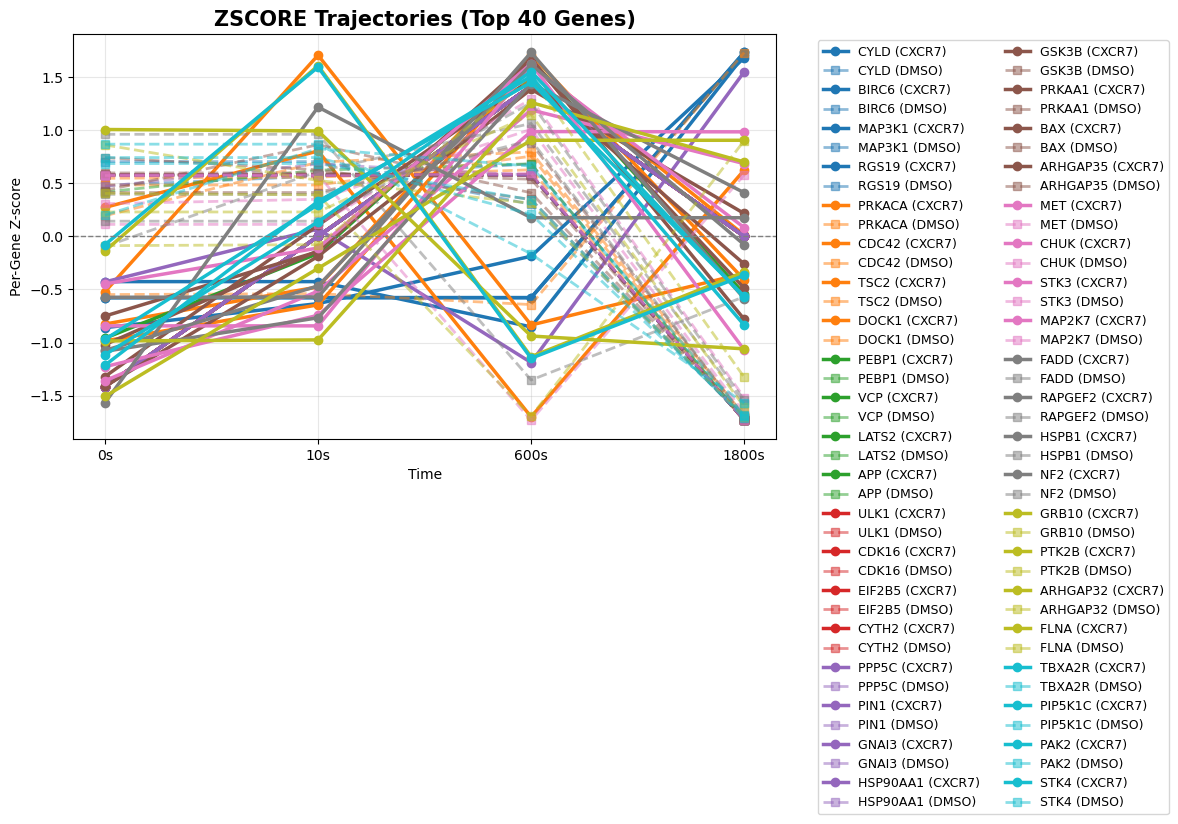

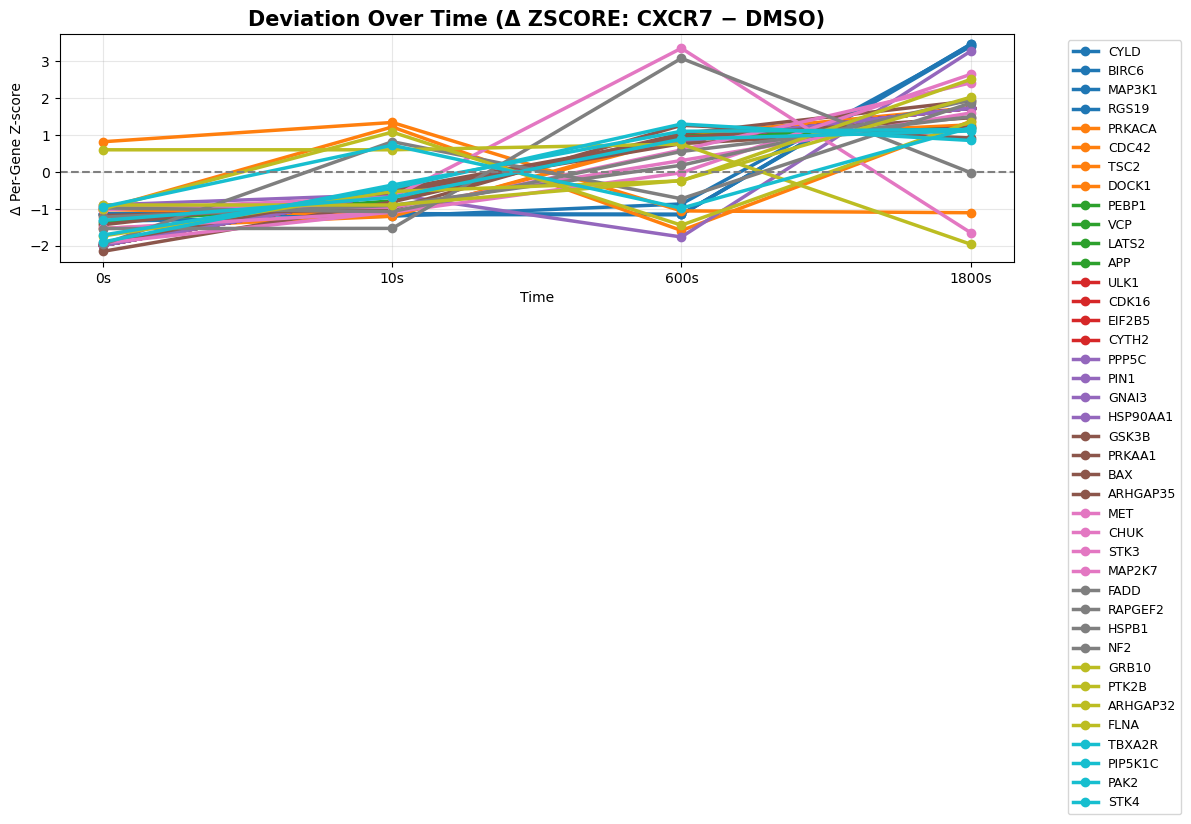


✅ Results saved to analysis/networks/subnetworks/betweenness_zscore_dynamics
   Mode: zscore
   📄 Files saved: metrics, top genes, plots, and trends


In [336]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# ⚙️ Select normalization mode: "absolute", "log2fc", "zscore"
# ======================================================
MODE = "zscore"  # options: "absolute", "log2fc", "zscore"

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
metrics["network"] = metrics["network"].astype(str)
print(f"Loaded betweenness metrics: {metrics.shape}")

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ["0s", "10s", "600s", "1800s"]

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)

def log2_fold_change_baseline0(pivot):
    baseline = pivot.iloc[:, 0].replace(0, np.nan)
    lfc = np.log2(pivot.div(baseline, axis=0))
    lfc = lfc.fillna(0)
    lfc.columns = timepoints
    return lfc

def zscore_per_gene(pivot):
    """Standard per-gene Z-score normalization (not baseline-anchored)."""
    norm = pivot.copy()
    for gene in pivot.index:
        vals = pivot.loc[gene].values
        if np.std(vals) > 0:
            z = (vals - np.mean(vals)) / np.std(vals)
        else:
            z = np.zeros_like(vals)
        norm.loc[gene] = z
    norm.columns = timepoints
    return norm

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(series):
    t = np.arange(len(series))
    slope, intercept, r, p, se = linregress(t, series)
    return slope, r**2, p

def compute_monotonic_trend(series):
    t = np.arange(len(series))
    rho, p = spearmanr(t, series)
    return rho, p

def directional_change(series):
    return series.iloc[-1] - series.iloc[0]

# ======================================================
# 🧮 Prepare betweenness matrices
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

if MODE == "absolute":
    cxcr7 = pivots["CXCR7"].loc[common_genes]
    dmso = pivots["DMSO"].loc[common_genes]
    cxcr7.columns = dmso.columns = timepoints
    label_y = "Absolute Betweenness Centrality"
elif MODE == "log2fc":
    cxcr7 = log2_fold_change_baseline0(pivots["CXCR7"].loc[common_genes])
    dmso = log2_fold_change_baseline0(pivots["DMSO"].loc[common_genes])
    label_y = "log₂ Fold-Change (vs 0 s)"
elif MODE == "zscore":
    cxcr7 = zscore_per_gene(pivots["CXCR7"].loc[common_genes])
    dmso = zscore_per_gene(pivots["DMSO"].loc[common_genes])
    label_y = "Per-Gene Z-score"
else:
    raise ValueError("MODE must be 'absolute', 'log2fc', or 'zscore'")

print(f"\n🧮 Using mode: {MODE}")
print(f"   CXCR7 shape: {cxcr7.shape}")
print(f"   DMSO shape:  {dmso.shape}")

# ======================================================
# 🧮 Compute Δ (CXCR7 − DMSO) and divergence metrics
# ======================================================
delta = cxcr7 - dmso
divergence = []

for gene in common_genes:
    v_cx, v_dm = np.array(cxcr7.loc[gene], dtype=float), np.array(dmso.loc[gene], dtype=float)
    divergence.append((
        gene,
        cosine_dissimilarity(v_cx, v_dm),
        dtw_distance(v_cx, v_dm),
        euclidean_distance(v_cx, v_dm)
    ))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 📈 Trend metrics for top genes
# ======================================================
N_TOP = 40
top_genes = divergence_df.head(N_TOP).index

trend_metrics = []
for gene in top_genes:
    s = delta.loc[gene]
    slope, r2, p = compute_trend_slope(s)
    rho, rp = compute_monotonic_trend(s)
    net = directional_change(s)
    trend = "increasing" if slope > 0 else ("decreasing" if slope < 0 else "stable")
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2,
        "slope_pval": p, "spearman_rho": rho, "spearman_pval": rp,
        "net_change": net, "trend": trend
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")
combined = divergence_df.join(trend_df).round(4)

# ======================================================
# 📊 Summary Tables
# ======================================================
print("\n" + "="*80)
print(f"📊 TABLE 1: TOP GENES BY DTW DISTANCE ({MODE.upper()} mode)")
print("="*80)
combined_dtw = combined.sort_values("dtw_distance", ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, "Rank", range(1, len(combined_dtw) + 1))
print(combined_dtw.to_string())
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Δ {MODE.upper()})")
print("="*80)
combined_pos = combined[combined["net_change"] > 0].sort_values("net_change", ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, "Rank", range(1, len(combined_pos) + 1))
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found.")
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Δ {MODE.upper()})")
print("="*80)
combined_neg = combined[combined["net_change"] < 0].sort_values("net_change", ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, "Rank", range(1, len(combined_neg) + 1))
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found.")
print("="*80)

# ======================================================
# 🎨 Visualization
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

# Plot 1: trajectories
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_genes):
    c = colors[i]
    ax.plot(timepoints, cxcr7.loc[g], "-o", lw=2.5, color=c, label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso.loc[g], "--s", lw=2, color=c, alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title(f"{MODE.upper()} Trajectories (Top {N_TOP} Genes)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(label_y)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Δ(CXCR7−DMSO)
fig, ax = plt.subplots(figsize=(12, 6))
for i, g in enumerate(top_genes):
    ax.plot(timepoints, delta.loc[g], "-o", lw=2.5, color=colors[i], label=g)
ax.axhline(0, color="gray", ls="--")
ax.set_title(f"Deviation Over Time (Δ {MODE.upper()}: CXCR7 − DMSO)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(f"Δ {label_y}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / f"betweenness_{MODE}_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7.to_csv(out_dir / f"cxcr7_{MODE}.csv")
dmso.to_csv(out_dir / f"dmso_{MODE}.csv")
delta.to_csv(out_dir / f"delta_{MODE}.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

print(f"\n✅ Results saved to {out_dir}")
print(f"   Mode: {MODE}")
print(f"   📄 Files saved: metrics, top genes, plots, and trends")


### 5.1.3 Relative betweeness centrality changes - Z score normalized to baseline

Loaded betweenness metrics: (3249, 8)

🧮 Using mode: zscore
   CXCR7 shape: (467, 4)
   DMSO shape:  (467, 4)

📊 TABLE 1: TOP GENES BY DTW DISTANCE (ZSCORE mode)
             Rank  cosine_dissimilarity  dtw_distance  euclidean_distance   slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                  
GSK3B           1                1.6080        1.4283              5.3543  1.4103     0.9843      0.0079        1.0000         0.0000      4.0837  increasing
STK3            2                1.5977        1.2167              5.0961  1.4718     0.9763      0.0119        1.0000         0.0000      4.3451  increasing
GNAI3           3                1.4082        1.1726              4.8852  1.2585     0.9899      0.0051        1.0000         0.0000      3.7236  increasing
VCP             4                1.4082        1

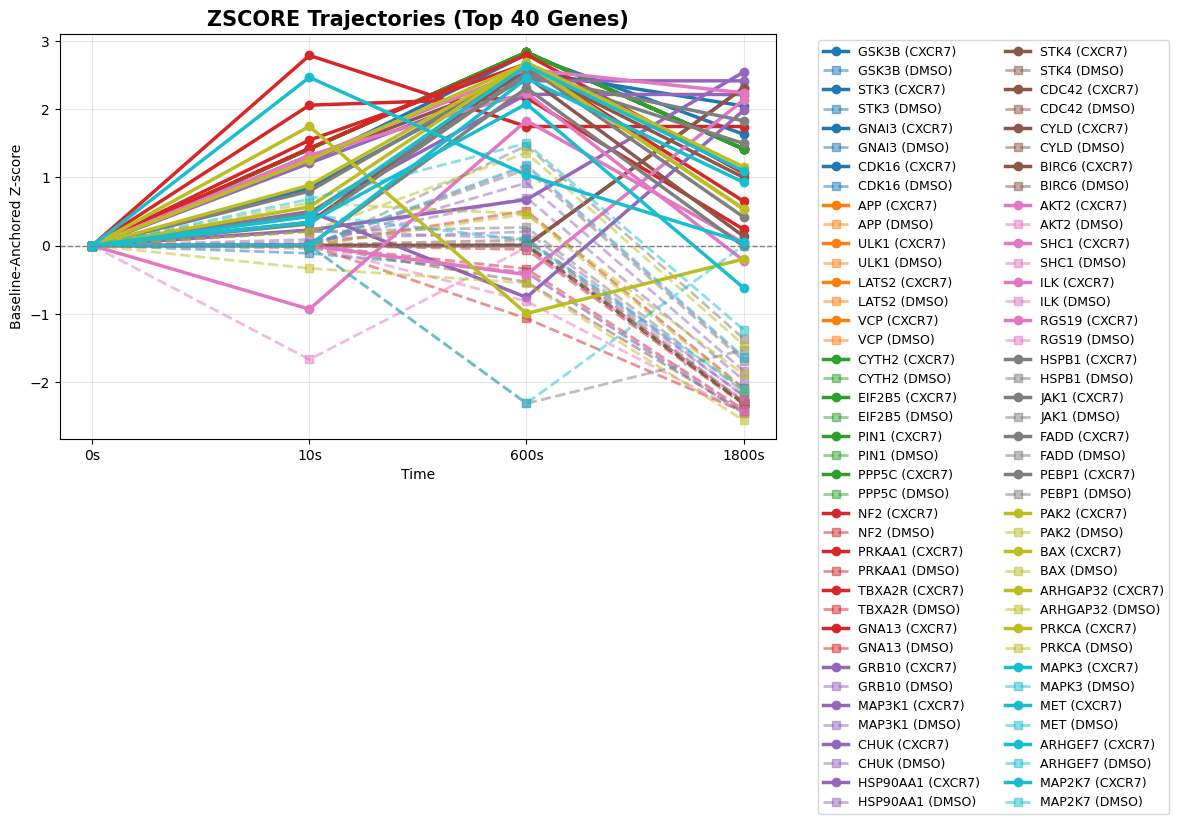

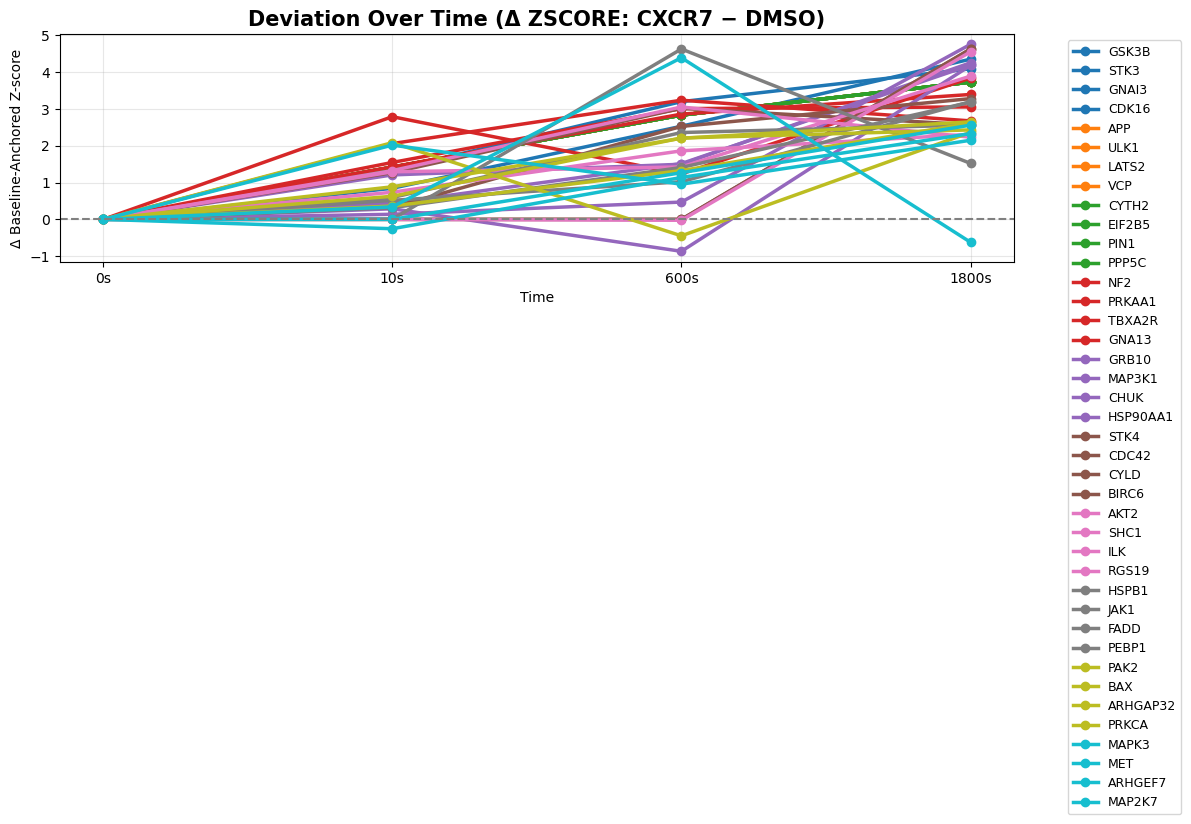


✅ Results saved to analysis/networks/subnetworks/betweenness_zscore_dynamics
   Mode: zscore
   📄 Files saved: metrics, top genes, plots, and trends


In [337]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# ⚙️ Select normalization mode: "absolute", "log2fc", "zscore"
# ======================================================
MODE = "zscore"  # options: "absolute", "log2fc", "zscore"

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
metrics["network"] = metrics["network"].astype(str)
print(f"Loaded betweenness metrics: {metrics.shape}")

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ["0s", "10s", "600s", "1800s"]

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)

def log2_fold_change_baseline0(pivot):
    baseline = pivot.iloc[:, 0].replace(0, np.nan)
    lfc = np.log2(pivot.div(baseline, axis=0))
    lfc = lfc.fillna(0)
    lfc.columns = timepoints
    return lfc

def zscore_baseline0(pivot):
    norm = pivot.copy()
    for gene in pivot.index:
        vals = pivot.loc[gene].values
        if np.std(vals) > 0:
            z = (vals - np.mean(vals)) / np.std(vals)
        else:
            z = np.zeros_like(vals)
        z = z - z[0]  # baseline shift
        norm.loc[gene] = z
    norm.columns = timepoints
    return norm

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(series):
    t = np.arange(len(series))
    slope, intercept, r, p, se = linregress(t, series)
    return slope, r**2, p

def compute_monotonic_trend(series):
    t = np.arange(len(series))
    rho, p = spearmanr(t, series)
    return rho, p

def directional_change(series):
    return series.iloc[-1] - series.iloc[0]

# ======================================================
# 🧮 Prepare betweenness matrices
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

if MODE == "absolute":
    cxcr7 = pivots["CXCR7"].loc[common_genes]
    dmso = pivots["DMSO"].loc[common_genes]
    cxcr7.columns = dmso.columns = timepoints
    label_y = "Absolute Betweenness Centrality"
elif MODE == "log2fc":
    cxcr7 = log2_fold_change_baseline0(pivots["CXCR7"].loc[common_genes])
    dmso = log2_fold_change_baseline0(pivots["DMSO"].loc[common_genes])
    label_y = "log₂ Fold-Change (vs 0 s)"
elif MODE == "zscore":
    cxcr7 = zscore_baseline0(pivots["CXCR7"].loc[common_genes])
    dmso = zscore_baseline0(pivots["DMSO"].loc[common_genes])
    label_y = "Baseline-Anchored Z-score"
else:
    raise ValueError("MODE must be 'absolute', 'log2fc', or 'zscore'")

print(f"\n🧮 Using mode: {MODE}")
print(f"   CXCR7 shape: {cxcr7.shape}")
print(f"   DMSO shape:  {dmso.shape}")

# ======================================================
# 🧮 Compute Δ (CXCR7 − DMSO) and divergence metrics
# ======================================================
delta = cxcr7 - dmso
divergence = []

for gene in common_genes:
    v_cx, v_dm = np.array(cxcr7.loc[gene], dtype=float), np.array(dmso.loc[gene], dtype=float)
    divergence.append((
        gene,
        cosine_dissimilarity(v_cx, v_dm),
        dtw_distance(v_cx, v_dm),
        euclidean_distance(v_cx, v_dm)
    ))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 📈 Trend metrics for top genes
# ======================================================
N_TOP = 40
top_genes = divergence_df.head(N_TOP).index

trend_metrics = []
for gene in top_genes:
    s = delta.loc[gene]
    slope, r2, p = compute_trend_slope(s)
    rho, rp = compute_monotonic_trend(s)
    net = directional_change(s)
    trend = "increasing" if slope > 0 else ("decreasing" if slope < 0 else "stable")
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2,
        "slope_pval": p, "spearman_rho": rho, "spearman_pval": rp,
        "net_change": net, "trend": trend
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")
combined = divergence_df.join(trend_df).round(4)

# ======================================================
# 📊 Summary Tables
# ======================================================
print("\n" + "="*80)
print(f"📊 TABLE 1: TOP GENES BY DTW DISTANCE ({MODE.upper()} mode)")
print("="*80)
combined_dtw = combined.sort_values("dtw_distance", ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, "Rank", range(1, len(combined_dtw) + 1))
print(combined_dtw.to_string())
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Δ {MODE.upper()})")
print("="*80)
combined_pos = combined[combined["net_change"] > 0].sort_values("net_change", ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, "Rank", range(1, len(combined_pos) + 1))
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found.")
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Δ {MODE.upper()})")
print("="*80)
combined_neg = combined[combined["net_change"] < 0].sort_values("net_change", ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, "Rank", range(1, len(combined_neg) + 1))
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found.")
print("="*80)

# ======================================================
# 🎨 Visualization
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

# Plot 1: trajectories
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_genes):
    c = colors[i]
    ax.plot(timepoints, cxcr7.loc[g], "-o", lw=2.5, color=c, label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso.loc[g], "--s", lw=2, color=c, alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title(f"{MODE.upper()} Trajectories (Top {N_TOP} Genes)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(label_y)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Δ(CXCR7−DMSO)
fig, ax = plt.subplots(figsize=(12, 6))
for i, g in enumerate(top_genes):
    ax.plot(timepoints, delta.loc[g], "-o", lw=2.5, color=colors[i], label=g)
ax.axhline(0, color="gray", ls="--")
ax.set_title(f"Deviation Over Time (Δ {MODE.upper()}: CXCR7 − DMSO)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(f"Δ {label_y}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / f"betweenness_{MODE}_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7.to_csv(out_dir / f"cxcr7_{MODE}.csv")
dmso.to_csv(out_dir / f"dmso_{MODE}.csv")
delta.to_csv(out_dir / f"delta_{MODE}.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

print(f"\n✅ Results saved to {out_dir}")
print(f"   Mode: {MODE}")
print(f"   📄 Files saved: metrics, top genes, plots, and trends")


### 5.1.4 Relative betweeness centrality changes - fold change

Loaded betweenness metrics: (3249, 8)

🧮 Computing log2 fold-change relative to 0s baseline...
   CXCR7 log2FC shape: (467, 4)
   DMSO log2FC shape:  (467, 4)

🔍 Computing trajectory dissimilarity metrics (log2FC)...


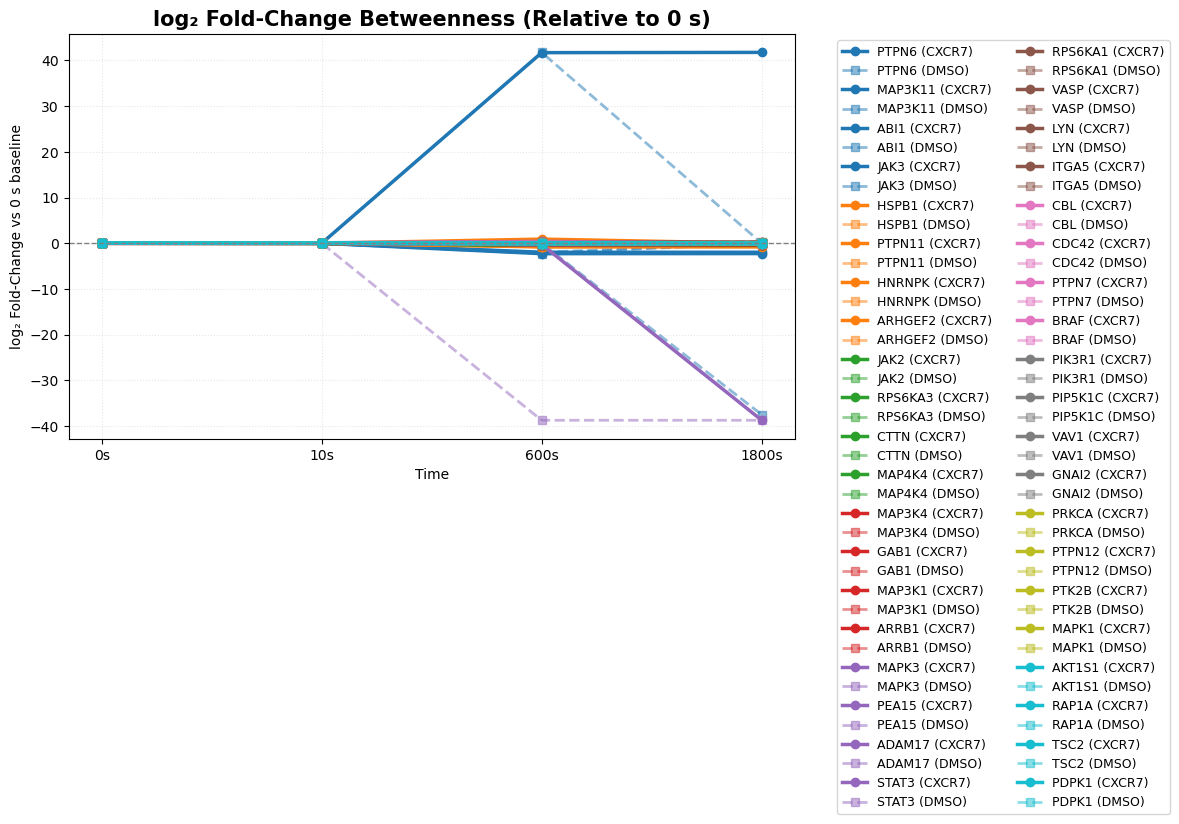

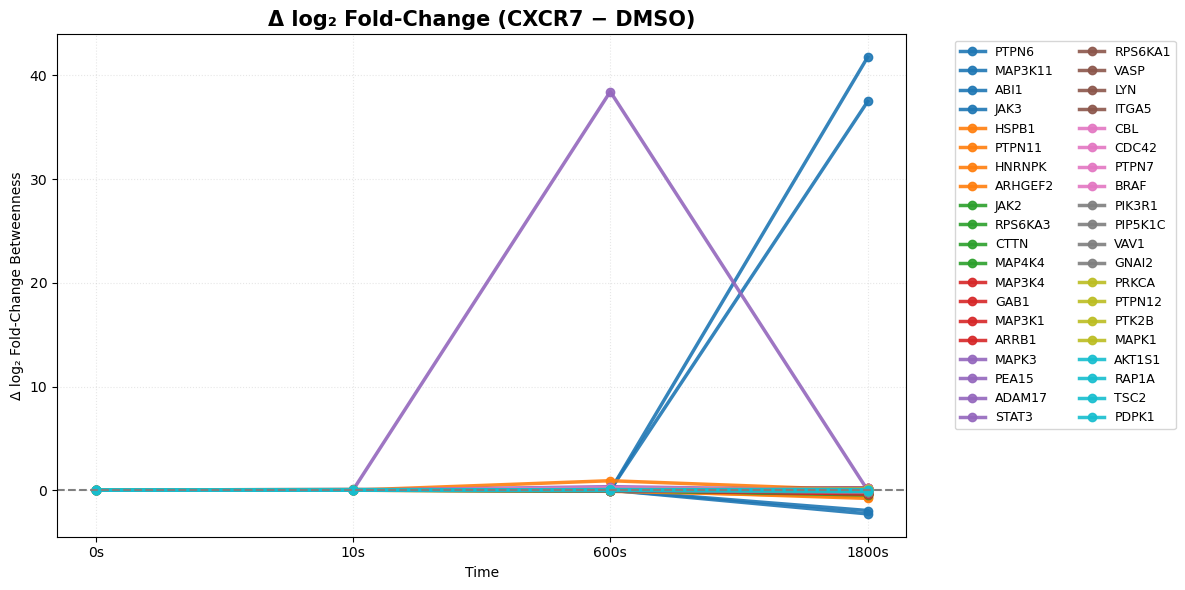


📊 TOP GENES BY DTW DISTANCE (Relative log2FC trajectories)
             Rank  cosine_dissimilarity  dtw_distance  euclidean_distance  AUC_absDelta  mean_absDelta    slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                                
PTPN6           1                0.2934        5.2339             41.7663       20.9304        10.4534  12.5252     0.5991      0.2260        0.3162         0.6838     41.7663  increasing
MAP3K11         2                0.2596        4.6896             37.4916       18.7850         9.3827  11.2473     0.6004      0.2251        0.8000         0.2000     37.4916  increasing
ABI1            3                0.2973        0.2875              2.2828        1.1414         0.5707  -0.6848     0.6000      0.2254       -0.7746         0.2254     -2.2828  decreasing


In [246]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")
metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ['0s', '10s', '600s', '1800s']

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network",
                          values="betweenness", fill_value=0, observed=False)

def log2_fold_change(pivot, pseudocount=1e-9):
    """Return log2 fold-change relative to baseline (0s), with pseudocount for stability."""
    baseline = pivot.iloc[:, 0]
    lfc = np.log2((pivot + pseudocount).div(baseline + pseudocount, axis=0))
    lfc.columns = timepoints
    return lfc

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    """Safe DTW distance with NaN/Inf handling."""
    v1 = np.nan_to_num(v1, nan=0.0, posinf=0.0, neginf=0.0)
    v2 = np.nan_to_num(v2, nan=0.0, posinf=0.0, neginf=0.0)
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(deviation_series):
    t = np.arange(len(deviation_series))
    slope, intercept, r, p, se = linregress(t, deviation_series)
    return slope, r**2, p

def compute_monotonic_trend(deviation_series):
    t = np.arange(len(deviation_series))
    rho, p = spearmanr(t, deviation_series)
    return rho, p

def directional_change(deviation_series):
    return deviation_series.iloc[-1] - deviation_series.iloc[0]

# ======================================================
# 🧮 Compute RELATIVE (log2FC) betweenness trajectories
# ======================================================
print("\n🧮 Computing log2 fold-change relative to 0s baseline...")

pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

cxcr7_lfc = log2_fold_change(pivots["CXCR7"].loc[common_genes])
dmso_lfc  = log2_fold_change(pivots["DMSO"].loc[common_genes])

print(f"   CXCR7 log2FC shape: {cxcr7_lfc.shape}")
print(f"   DMSO log2FC shape:  {dmso_lfc.shape}")

# ======================================================
# 🧮 Compute RELATIVE DEVIATION (CXCR7 − DMSO)
# ======================================================
delta_lfc = cxcr7_lfc - dmso_lfc

print("\n🔍 Computing trajectory dissimilarity metrics (log2FC)...")

divergence = []
for gene in common_genes:
    v_cx = np.array(cxcr7_lfc.loc[gene], dtype=float)
    v_dm = np.array(dmso_lfc.loc[gene], dtype=float)

    cos_diff = cosine_dissimilarity(v_cx, v_dm)
    dtw_diff = dtw_distance(v_cx, v_dm)
    eucl_diff = euclidean_distance(v_cx, v_dm)
    auc = np.trapezoid(np.abs(v_cx - v_dm))
    mean_diff = np.mean(np.abs(v_cx - v_dm))

    divergence.append((gene, cos_diff, dtw_diff, eucl_diff, auc, mean_diff))

divergence_df = (
    pd.DataFrame(divergence,
        columns=["gene_symbol","cosine_dissimilarity","dtw_distance",
                 "euclidean_distance","AUC_absDelta","mean_absDelta"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 📈 Select top candidates
# ======================================================
N_TOP = 40
top_genes = divergence_df.head(N_TOP).index

# ======================================================
# 📈 Temporal trend metrics
# ======================================================
trend_metrics = []
for gene in top_genes:
    dev_series = delta_lfc.loc[gene]
    slope, r2, p = compute_trend_slope(dev_series)
    rho, rho_p = compute_monotonic_trend(dev_series)
    net = directional_change(dev_series)
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2,
        "slope_pval": p, "spearman_rho": rho, "spearman_pval": rho_p,
        "net_change": net, "trend": "increasing" if slope>0 else
                     ("decreasing" if slope<0 else "stable")
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")

# ======================================================
# 🎨 PLOT 1: log2FC trajectories (CXCR7 vs DMSO)
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_genes):
    c = colors[i]
    ax.plot(timepoints, cxcr7_lfc.loc[g], "-o", lw=2.5, color=c,
            label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso_lfc.loc[g], "--s", lw=2, color=c,
            alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title("log₂ Fold-Change Betweenness (Relative to 0 s)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("log₂ Fold-Change vs 0 s baseline")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout(); plt.show()

# ======================================================
# 🎨 PLOT 2: Δlog2FC = CXCR7 − DMSO
# ======================================================
fig, ax = plt.subplots(figsize=(12,6))
for i,g in enumerate(top_genes):
    ax.plot(timepoints, delta_lfc.loc[g], "-o", lw=2.5,
            color=colors[i], alpha=0.9, label=g)
ax.axhline(0, color="gray", ls="--", lw=1.5)
ax.set_title("Δ log₂ Fold-Change (CXCR7 − DMSO)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("Δ log₂ Fold-Change Betweenness")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout(); plt.show()

# ======================================================
# 📊 Combine metrics
# ======================================================
combined = divergence_df.join(trend_df).round(4)
combined.insert(0,"Rank", range(1,len(combined)+1))
print("\n📊 TOP GENES BY DTW DISTANCE (Relative log2FC trajectories)")
print(combined.head(N_TOP).to_string())

# ======================================================
# 💾 Save
# ======================================================
out_dir = in_dir / "betweenness_relative_log2FC"
out_dir.mkdir(exist_ok=True)
cxcr7_lfc.to_csv(out_dir/"cxcr7_log2fc.csv")
dmso_lfc.to_csv(out_dir/"dmso_log2fc.csv")
delta_lfc.to_csv(out_dir/"delta_log2fc.csv")
divergence_df.to_csv(out_dir/"trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir/"temporal_trend_metrics.csv")
combined.head(N_TOP).to_csv(out_dir/"top_genes_by_dtw.csv")

print(f"\n✅ Results saved to {out_dir}")


### 5.1.5 Betweeness centrality chnages - log2FC and Combined Metrices (Baseline-Relative Dynamic Distance (BRDD))

✅ Using Baseline-Relative Dynamic Distance (BRDD) — DTW-stabilized version
Loaded betweenness metrics: (3249, 8)

🧮 Mode: BRDD (baseline-relative log₂FC)
   CXCR7: (467, 4), DMSO: (467, 4)

✅ Computed BRDD metrics for 467 genes (stabilized)
📊 Sorted by DTW distance (top 40)


cosine        dtw  euclidean  delta_slope  abs_delta_slope  \
gene_symbol                                                                 
PTPN6        0.423442  11.749951  36.184337    12.525165        12.525165   
MAP3K11      0.208117  10.537323  32.457396    11.247279        11.247279   
ADAM17       0.416888   8.445866  33.293987     3.844038         3.844038   
ABI1         0.425928   0.644236   1.976974    -0.684844         0.684844   
JAK3         0.418423   0.550422   1.697257    -0.588488         0.588488   
CASP6        0.418382   0.404356   1.597567    -0.177406         0.177406   
HSPB1        1.777060   0.254900   0.793111     0.090780         0.090780   
PTPN11       0.418422   0.225870   0.691597    -0.234817         0.234817   
HNRNPK       0.371010   0.163968   0.519916    -0.198652         0.198652   
JAK2         0.441893   0.132509   0.407260    -0.137485         0.137485   
ARHGEF2      0.245634   0.122171   0.372164    -0.136946         0.136946   
MAP3K4       0.000000   0.104354   0.321328    -0.111311         0.111311   
GAB1         0.425079   0.096045   0.292960    -0.099810         0.099810   
CTTN         0.376791   0.095969   0.299938    -0.111518         0.111518   
ITGB1        0.325906   0.092113   0.344088     0.031885         0.031885   
MAP4K4       0.401825   0.092058   0.287285    -0.104102         0.104102   
RPS6KA3      0.372491   0.088602   0.273986    -0.105290         0.105290   
ARRB1        0.419745   0.084679   0.260103    -0.091209         0.091209   
PEA15        0.696257   0.077359   0.298129     0.034417         0.034417   
RPS6KA1      0.441976   0.064581   0.195048    -0.070529         0.070529   

             delta_auc  abs_delta_auc  cosine_norm  dtw_norm  euclidean_norm  \
gene_symbol                                                                    
PTPN6        17.355376      17.355376     0.211721  1.000000        1.000000   
MAP3K11      15.665890      15.665890     0.104059  0.896797        0.897001   
ADAM17       38.454559      38.454559     0.208444  0.718800        0.920122   
ABI1         -0.951172       0.951172     0.212964  0.054829        0.054636   
JAK3         -0.811079       0.811079     0.209212  0.046845        0.046906   
CASP6        -1.828730       1.828730     0.209191  0.034413        0.044151   
HSPB1         0.918010       0.918010     0.888530  0.021694        0.021919   
PTPN11       -0.300809       0.300809     0.209211  0.019223        0.019113   
HNRNPK       -0.366394       0.366394     0.185505  0.013955        0.014369   
JAK2         -0.171457       0.171457     0.220946  0.011277        0.011255   
ARHGEF2      -0.227231       0.227231     0.122817  0.010398        0.010285   
MAP3K4       -0.154599       0.154599     0.000000  0.008881        0.008880   
GAB1         -0.131532       0.131532     0.212539  0.008174        0.008096   
CTTN         -0.190530       0.190530     0.188395  0.008168        0.008289   
ITGB1         0.379478       0.379478     0.162953  0.007839        0.009509   
MAP4K4       -0.165325       0.165325     0.200912  0.007835        0.007939   
RPS6KA3      -0.197372       0.197372     0.186245  0.007541        0.007572   
ARRB1        -0.126770       0.126770     0.209873  0.007207        0.007188   
PEA15         0.344232       0.344232     0.348128  0.006584        0.008239   
RPS6KA1      -0.111327       0.111327     0.220988  0.005496        0.005390   

             delta_slope_norm  abs_delta_slope_norm  delta_auc_norm  \
gene_symbol                                                           
PTPN6                1.000000              1.000000        0.476230   
MAP3K11              0.903264              0.897975        0.434290   
ADAM17               0.342837              0.306905        1.000000   
ABI1                 0.000000              0.054677        0.021785   
JAK3                 0.007294              0.046984        0.025262   
CASP6                0.038413              0.014164        0.0

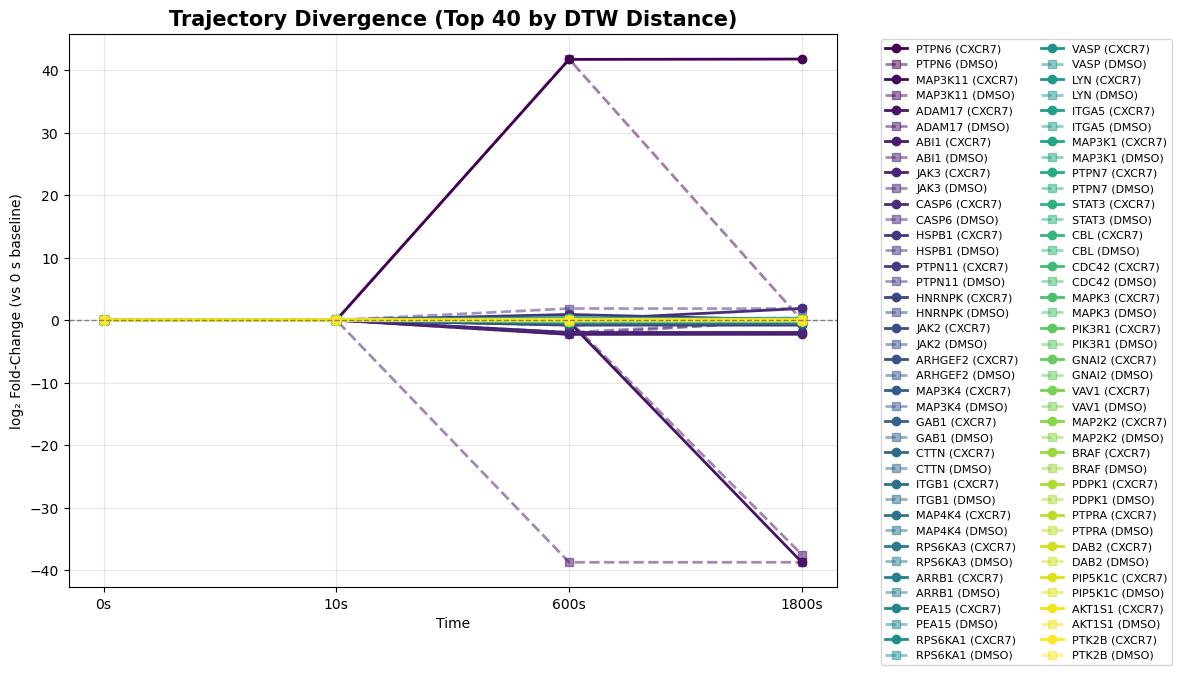

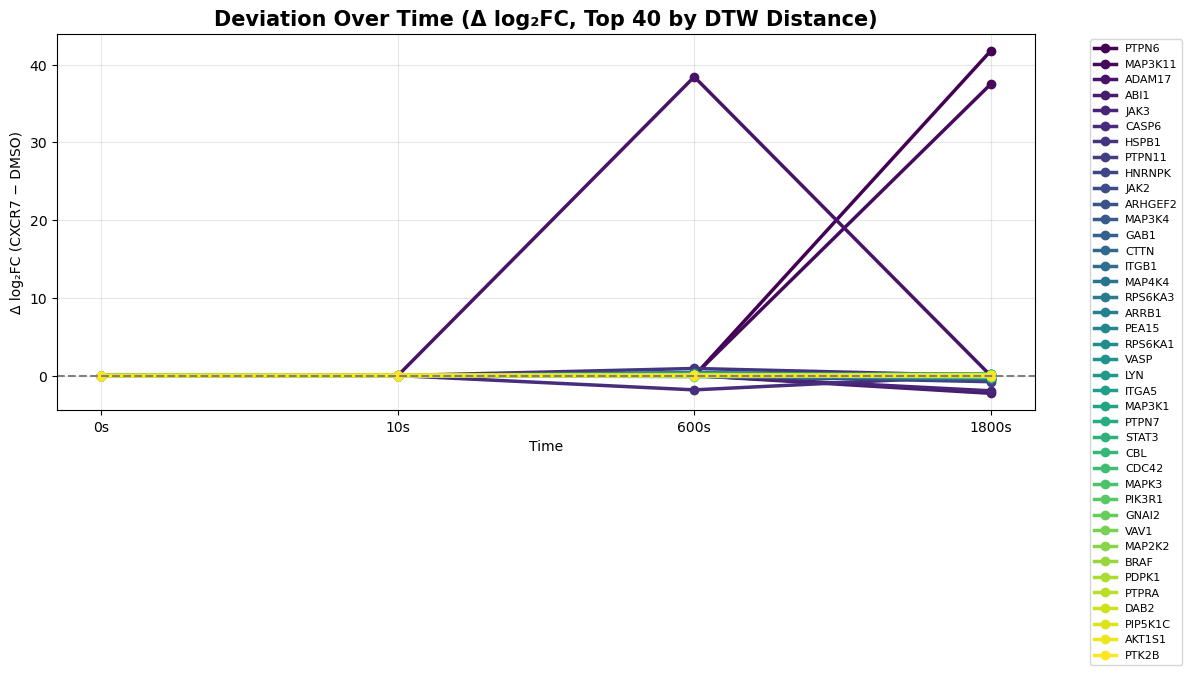


✅ DTW-based BRDD analysis complete and stabilized! Results saved to: analysis/networks/subnetworks/betweenness_dtw_dynamics_stable


<Figure size 640x480 with 0 Axes>

In [372]:
# ======================================================
# 🧬 BASELINE-RELATIVE DYNAMIC DISTANCE (BRDD) — SORT BY DTW (IMPROVED)
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial.distance import cosine
from dtw import dtw
from scipy.integrate import simpson
from pathlib import Path

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    "N_TOP": 40,
    "PRIMARY_METRIC": "dtw",
    "SAVE_PLOTS": True,
    "PLOT_DPI": 300,
    "PSEUDOCOUNT": 1e-9
}

print("✅ Using Baseline-Relative Dynamic Distance (BRDD) — DTW-stabilized version")

# ======================================================
# 💾 Load betweenness data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
metrics["network"] = metrics["network"].astype(str)
print(f"Loaded betweenness metrics: {metrics.shape}")

# ======================================================
# 🧭 Define trajectories and timepoints
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ["0s", "10s", "600s", "1800s"]

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    pivot = df.pivot_table(index="gene_symbol", columns="network",
                           values="betweenness", fill_value=0)
    return pivot

def log2fc_baseline0(df, pseudocount=1e-9):
    baseline = df.iloc[:, 0]
    lfc = np.log2((df + pseudocount).div(baseline + pseudocount, axis=0))
    lfc.columns = timepoints
    return lfc

def sanitize_vector(v):
    """Replace NaN, inf with finite values and center vector for stability."""
    v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
    if np.all(v == 0):
        return v
    v = v - np.mean(v)  # center trajectory (avoids inflated DTW for offset)
    return v

def cosine_dissimilarity(v1, v2):
    v1, v2 = sanitize_vector(v1), sanitize_vector(v2)
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    v1, v2 = sanitize_vector(v1), sanitize_vector(v2)
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    v1, v2 = sanitize_vector(v1), sanitize_vector(v2)
    return float(np.linalg.norm(v1 - v2))

def compute_slope(series):
    t = np.arange(len(series))
    s, _, _, _, _ = linregress(t, series)
    return s

# ======================================================
# 🧮 Prepare log2FC trajectories
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

cxcr7 = log2fc_baseline0(pivots["CXCR7"].loc[common_genes], CONFIG["PSEUDOCOUNT"])
dmso  = log2fc_baseline0(pivots["DMSO"].loc[common_genes], CONFIG["PSEUDOCOUNT"])
label_y = "log₂ Fold-Change (vs 0 s baseline)"

print(f"\n🧮 Mode: BRDD (baseline-relative log₂FC)")
print(f"   CXCR7: {cxcr7.shape}, DMSO: {dmso.shape}")

# ======================================================
# 🧮 Compute deviation metrics per gene
# ======================================================
results = []
for gene in common_genes:
    v_cx = cxcr7.loc[gene].values.astype(float)
    v_dm = dmso.loc[gene].values.astype(float)

    # Distance metrics
    cos_diff = cosine_dissimilarity(v_cx, v_dm)
    dtw_diff = dtw_distance(v_cx, v_dm)
    eucl_diff = euclidean_distance(v_cx, v_dm)

    # Trend metrics
    x = np.arange(len(v_cx))
    s1, _, _, _, _ = linregress(x, v_cx)
    s2, _, _, _, _ = linregress(x, v_dm)
    delta_slope = s1 - s2
    abs_delta_slope = abs(delta_slope)

    # AUC metrics
    delta_auc = simpson(v_cx, x=x) - simpson(v_dm, x=x)
    abs_delta_auc = abs(delta_auc)

    results.append([gene, cos_diff, dtw_diff, eucl_diff, delta_slope, abs_delta_slope, delta_auc, abs_delta_auc])

metrics_df = pd.DataFrame(
    results,
    columns=[
        "gene_symbol", "cosine", "dtw", "euclidean",
        "delta_slope", "abs_delta_slope", "delta_auc", "abs_delta_auc"
    ]
).set_index("gene_symbol")

# Replace infinities and NaNs globally
metrics_df.replace([np.inf, -np.inf], np.nan, inplace=True)
metrics_df.fillna(0, inplace=True)

# ======================================================
# ⚙️ Min–max normalization (0–1)
# ======================================================
for col in ["cosine", "dtw", "euclidean", "delta_slope", "abs_delta_slope", "delta_auc", "abs_delta_auc"]:
    cmin, cmax = np.nanmin(metrics_df[col]), np.nanmax(metrics_df[col])
    metrics_df[f"{col}_norm"] = 0 if cmax == cmin else (metrics_df[col] - cmin) / (cmax - cmin)

# ======================================================
# 🔢 Sort and summarize (by DTW distance)
# ======================================================
metrics_df = metrics_df.sort_values("dtw", ascending=False)
top_df = metrics_df.head(CONFIG["N_TOP"])

print(f"\n✅ Computed BRDD metrics for {len(metrics_df)} genes (stabilized)")
print(f"📊 Sorted by DTW distance (top {CONFIG['N_TOP']})")
display(top_df.head(20))

# ======================================================
# 🎨 Visualization
# ======================================================
colors = plt.cm.viridis(np.linspace(0, 1, CONFIG["N_TOP"]))

# Plot 1: Trajectories (log2FC)
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_df.index):
    ax.plot(timepoints, cxcr7.loc[g], "-o", lw=2, color=colors[i], label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso.loc[g], "--s", lw=2, color=colors[i], alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title(f"Trajectory Divergence (Top {CONFIG['N_TOP']} by DTW Distance)", fontsize=15, fontweight="bold")
ax.set_xlabel("Time"); ax.set_ylabel(label_y)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Δ(CXCR7 − DMSO)
delta = cxcr7 - dmso
fig, ax = plt.subplots(figsize=(12, 6))
for i, g in enumerate(top_df.index):
    ax.plot(timepoints, delta.loc[g], "-o", lw=2.5, color=colors[i], label=g)
ax.axhline(0, color="gray", ls="--")
ax.set_title(f"Deviation Over Time (Δ log₂FC, Top {CONFIG['N_TOP']} by DTW Distance)", fontsize=15, fontweight="bold")
ax.set_xlabel("Time"); ax.set_ylabel("Δ log₂FC (CXCR7 − DMSO)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_dtw_dynamics_stable"
out_dir.mkdir(exist_ok=True)

cxcr7.to_csv(out_dir / "cxcr7_log2fc.csv")
dmso.to_csv(out_dir / "dmso_log2fc.csv")
delta.to_csv(out_dir / "delta_log2fc.csv")
metrics_df.to_csv(out_dir / "betweenness_dtw_metrics.csv")
top_df.to_csv(out_dir / f"top_{CONFIG['N_TOP']}_genes_by_dtw.csv")

if CONFIG["SAVE_PLOTS"]:
    plt.savefig(out_dir / f"top_{CONFIG['N_TOP']}_dtw_trajectories.png", dpi=CONFIG["PLOT_DPI"], bbox_inches="tight")

print(f"\n✅ DTW-based BRDD analysis complete and stabilized! Results saved to: {out_dir}")


### 5.1.6 Betweeness centrality changes - combined score

In [370]:
# ======================================================
# 🧩 COMBINE ABSOLUTE + NORMALIZED METRICS INTO ROBUST SCORES
# ======================================================
from scipy.stats import rankdata

def robust_scale(series):
    """Robust, non-parametric normalization using median and IQR."""
    s = series.replace([np.inf, -np.inf], np.nan).fillna(0)
    median = np.median(s)
    iqr = np.subtract(*np.percentile(s, [75, 25]))
    if iqr == 0:
        # Fallback to rank-based scaling
        ranks = rankdata(s)
        return (ranks - np.min(ranks)) / (np.max(ranks) - np.min(ranks))
    scaled = (s - median) / (iqr + 1e-9)
    # Rescale to 0–1 after robust transformation
    return (scaled - np.min(scaled)) / (np.max(scaled) - np.min(scaled))

print("\n⚙️ Computing robust non-parametric combined scores...")

# Ensure safe numeric conversions
for c in ["dtw", "abs_delta_slope", "abs_delta_auc"]:
    metrics_df[c] = pd.to_numeric(metrics_df[c], errors="coerce").fillna(0)

# ======================================================
# 🧮 Robustly normalize absolute and normalized metrics
# ======================================================
metrics_df["dtw_robust"] = robust_scale(metrics_df["dtw"])
metrics_df["abs_delta_slope_robust"] = robust_scale(metrics_df["abs_delta_slope"])
metrics_df["abs_delta_auc_robust"] = robust_scale(metrics_df["abs_delta_auc"])

# Combine both absolute and normalized versions
metrics_df["combined_dtw"] = (
    0.5 * metrics_df["dtw_robust"] +
    0.5 * metrics_df["dtw_norm"]
)

metrics_df["combined_slope"] = (
    0.5 * metrics_df["abs_delta_slope_robust"] +
    0.5 * metrics_df["abs_delta_slope_norm"]
)

metrics_df["combined_auc"] = (
    0.5 * metrics_df["abs_delta_auc_robust"] +
    0.5 * metrics_df["abs_delta_auc_norm"]
)

# ======================================================
# 🧾 Rank and summarize
# ======================================================
metrics_df["rank_combined_dtw"] = rankdata(-metrics_df["combined_dtw"], method="dense")
metrics_df["rank_combined_slope"] = rankdata(-metrics_df["combined_slope"], method="dense")
metrics_df["rank_combined_auc"] = rankdata(-metrics_df["combined_auc"], method="dense")

print("\n📊 Top genes by each combined metric:")
for label, col in {
    "DTW": "combined_dtw",
    "Slope": "combined_slope",
    "AUC": "combined_auc"
}.items():
    print(f"\n🔹 {label} Combined Metric (Top 10):")
    display(
        metrics_df.sort_values(col, ascending=False)
                  .head(30)[[
                      col,
                      f"rank_combined_{label.lower()}",
                      "dtw", "abs_delta_slope", "abs_delta_auc"
                  ]]
    )

# ======================================================
# 💾 Save results
# ======================================================
combined_out = out_dir / "combined_metrics"
combined_out.mkdir(exist_ok=True)

metrics_df.to_csv(combined_out / "metrics_with_combined_scores.csv")

# Optionally: export top 50 by each combined score
metrics_df.sort_values("combined_dtw", ascending=False).head(50).to_csv(combined_out / "top_by_combined_dtw.csv")
metrics_df.sort_values("combined_slope", ascending=False).head(50).to_csv(combined_out / "top_by_combined_slope.csv")
metrics_df.sort_values("combined_auc", ascending=False).head(50).to_csv(combined_out / "top_by_combined_auc.csv")

print(f"\n✅ Combined robust metrics computed and saved in: {combined_out}")



⚙️ Computing robust non-parametric combined scores...

📊 Top genes by each combined metric:

🔹 DTW Combined Metric (Top 10):


combined_dtw  rank_combined_dtw        dtw  abs_delta_slope  \
gene_symbol                                                                
PTPN6            1.000000                  1  11.749951        12.525165   
MAP3K11          0.896797                  2  10.537323        11.247279   
ADAM17           0.718800                  3   8.445866         3.844038   
ABI1             0.054829                  4   0.644236         0.684844   
JAK3             0.046845                  5   0.550422         0.588488   
CASP6            0.034413                  6   0.404356         0.177406   
HSPB1            0.021694                  7   0.254900         0.090780   
PTPN11           0.019223                  8   0.225870         0.234817   
HNRNPK           0.013955                  9   0.163968         0.198652   
JAK2             0.011277                 10   0.132509         0.137485   
ARHGEF2          0.010398                 11   0.122171         0.136946   
MAP3K4           0.008881                 12   0.104354         0.111311   
GAB1             0.008174                 13   0.096045         0.099810   
CTTN             0.008168                 14   0.095969         0.111518   
ITGB1            0.007839                 15   0.092113         0.031885   
MAP4K4           0.007835                 16   0.092058         0.104102   
RPS6KA3          0.007541                 17   0.088602         0.105290   
ARRB1            0.007207                 18   0.084679         0.091209   
PEA15            0.006584                 19   0.077359         0.034417   
RPS6KA1          0.005496                 20   0.064581         0.070529   
VASP             0.005436                 21   0.063875         0.071187   
LYN              0.005152                 22   0.060532         0.066822   
ITGA5            0.004936                 23   0.057997         0.067512   
MAP3K1           0.004375                 24   0.051403         0.065703   
PTPN7            0.004305                 25   0.050583         0.022275   
STAT3            0.004284                 26   0.050340         0.055335   
CBL              0.004281                 27   0.050298         0.049538   
CDC42            0.004129                 28   0.048517         0.057578   
MAPK3            0.004029                 29   0.047340         0.054176   
PIK3R1           0.003554                 30   0.041760         0.040978   

             abs_delta_auc  
gene_symbol                 
PTPN6            17.355376  
MAP3K11          15.665890  
ADAM17           38.454559  
ABI1              0.951172  
JAK3              0.811079  
CASP6             1.828730  
HSPB1             0.918010  
PTPN11            0.300809  
HNRNPK            0.366394  
JAK2              0.171457  
ARHGEF2           0.227231  
MAP3K4            0.154599  
GAB1              0.131532  
CTTN              0.190530  
ITGB1             0.379478  
MAP4K4            0.165325  
RPS6KA3           0.197372  
ARRB1             0.126770  
PEA15             0.344232  
RPS6KA1           0.111327  
VASP              0.111403  
LYN               0.109046  
ITGA5             0.093767  
MAP3K1            0.121968  
PTPN7             0.235529  
STAT3             0.099736  
CBL               0.049771  
CDC42             0.093269  
MAPK3             0.184905  
PIK3R1            0.042341


🔹 Slope Combined Metric (Top 10):


combined_slope  rank_combined_slope        dtw  abs_delta_slope  \
gene_symbol                                                                    
PTPN6              1.000000                    1  11.749951        12.525165   
MAP3K11            0.897975                    2  10.537323        11.247279   
ADAM17             0.306905                    3   8.445866         3.844038   
ABI1               0.054677                    4   0.644236         0.684844   
JAK3               0.046984                    5   0.550422         0.588488   
PTPN11             0.018748                    6   0.225870         0.234817   
HNRNPK             0.015860                    7   0.163968         0.198652   
CASP6              0.014164                    8   0.404356         0.177406   
JAK2               0.010977                    9   0.132509         0.137485   
ARHGEF2            0.010934                   10   0.122171         0.136946   
CTTN               0.008904                   11   0.095969         0.111518   
MAP3K4             0.008887                   12   0.104354         0.111311   
RPS6KA3            0.008406                   13   0.088602         0.105290   
MAP4K4             0.008311                   14   0.092058         0.104102   
GAB1               0.007969                   15   0.096045         0.099810   
ARRB1              0.007282                   16   0.084679         0.091209   
HSPB1              0.007248                   17   0.254900         0.090780   
VASP               0.005684                   18   0.063875         0.071187   
RPS6KA1            0.005631                   19   0.064581         0.070529   
ITGA5              0.005390                   20   0.057997         0.067512   
LYN                0.005335                   21   0.060532         0.066822   
MAP3K1             0.005246                   22   0.051403         0.065703   
CDC42              0.004597                   23   0.048517         0.057578   
STAT3              0.004418                   24   0.050340         0.055335   
MAPK3              0.004325                   25   0.047340         0.054176   
CBL                0.003955                   26   0.050298         0.049538   
PIK3R1             0.003272                   27   0.041760         0.040978   
VAV1               0.003158                   28   0.034567         0.039550   
GNAI2              0.002984                   29   0.038266         0.037375   
PEA15              0.002748                   30   0.077359         0.034417   

             abs_delta_auc  
gene_symbol                 
PTPN6            17.355376  
MAP3K11          15.665890  
ADAM17           38.454559  
ABI1              0.951172  
JAK3              0.811079  
PTPN11            0.300809  
HNRNPK            0.366394  
CASP6             1.828730  
JAK2              0.171457  
ARHGEF2           0.227231  
CTTN              0.190530  
MAP3K4            0.154599  
RPS6KA3           0.197372  
MAP4K4            0.165325  
GAB1              0.131532  
ARRB1             0.126770  
HSPB1             0.918010  
VASP              0.111403  
RPS6KA1           0.111327  
ITGA5             0.093767  
LYN               0.109046  
MAP3K1            0.121968  
CDC42             0.093269  
STAT3             0.099736  
MAPK3             0.184905  
CBL               0.049771  
PIK3R1            0.042341  
VAV1              0.034024  
GNAI2             0.035916  
PEA15             0.344232


🔹 AUC Combined Metric (Top 10):


combined_auc  rank_combined_auc        dtw  abs_delta_slope  \
gene_symbol                                                                
ADAM17           1.000000                  1   8.445866         3.844038   
PTPN6            0.451322                  2  11.749951        12.525165   
MAP3K11          0.407387                  3  10.537323        11.247279   
CASP6            0.047556                  4   0.404356         0.177406   
ABI1             0.024735                  5   0.644236         0.684844   
HSPB1            0.023873                  6   0.254900         0.090780   
JAK3             0.021092                  7   0.550422         0.588488   
ITGB1            0.009868                  8   0.092113         0.031885   
HNRNPK           0.009528                  9   0.163968         0.198652   
PEA15            0.008952                 10   0.077359         0.034417   
PTPN11           0.007822                 11   0.225870         0.234817   
PTPN7            0.006125                 12   0.050583         0.022275   
ARHGEF2          0.005909                 13   0.122171         0.136946   
RPS6KA3          0.005133                 14   0.088602         0.105290   
CTTN             0.004955                 15   0.095969         0.111518   
MAPK3            0.004808                 16   0.047340         0.054176   
JAK2             0.004459                 17   0.132509         0.137485   
MAP4K4           0.004299                 18   0.092058         0.104102   
MAP3K4           0.004020                 19   0.104354         0.111311   
MAP2K2           0.003678                 20   0.033276         0.016799   
GAB1             0.003420                 21   0.096045         0.099810   
ARRB1            0.003297                 22   0.084679         0.091209   
MAP3K1           0.003172                 23   0.051403         0.065703   
PTPRA            0.003159                 24   0.027188         0.010736   
BRAF             0.003090                 25   0.030398         0.027282   
VASP             0.002897                 26   0.063875         0.071187   
RPS6KA1          0.002895                 27   0.064581         0.070529   
LYN              0.002836                 28   0.060532         0.066822   
STAT3            0.002594                 29   0.050340         0.055335   
PRKCA            0.002537                 30   0.021457         0.025306   

             abs_delta_auc  
gene_symbol                 
ADAM17           38.454559  
PTPN6            17.355376  
MAP3K11          15.665890  
CASP6             1.828730  
ABI1              0.951172  
HSPB1             0.918010  
JAK3              0.811079  
ITGB1             0.379478  
HNRNPK            0.366394  
PEA15             0.344232  
PTPN11            0.300809  
PTPN7             0.235529  
ARHGEF2           0.227231  
RPS6KA3           0.197372  
CTTN              0.190530  
MAPK3             0.184905  
JAK2              0.171457  
MAP4K4            0.165325  
MAP3K4            0.154599  
MAP2K2            0.141434  
GAB1              0.131532  
ARRB1             0.126770  
MAP3K1            0.121968  
PTPRA             0.121481  
BRAF              0.118833  
VASP              0.111403  
RPS6KA1           0.111327  
LYN               0.109046  
STAT3             0.099736  
PRKCA             0.097562


✅ Combined robust metrics computed and saved in: analysis/networks/subnetworks/betweenness_dtw_dynamics_stable/combined_metrics


## 5.2 Phsophosite divergence anaylsis CXCR7 vs DMSO base on log2fc

### 5.2.1 Preparation

In [263]:
# ======================================================
# 💾 Load phosphoproteomics intensities
# ======================================================
import pandas as pd
from pathlib import Path

base = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
phospho_path = base / "phosphoproteomics" / "data" / "processed_data"

phospho_intensity = pd.read_csv(phospho_path / "norm_intensity.txt", sep="\t", index_col=0)

print(f"✅ Loaded phosphoproteomics intensity table: {phospho_intensity.shape}")
print("\n📊  column names:\n")
for col in phospho_intensity.columns[:70]:
    print("   ", col)


✅ Loaded phosphoproteomics intensity table: (3772, 70)

📊  column names:

    x0sek_Ctrl_01
    x0sek_Ctrl_02
    x0sek_Ctrl_03
    x0sek_Ctrl_04
    x0sek_Ctrl_05
    x0sek_Ctrl_06
    x0sek_Ctrl_07
    x0sek_Ctrl_08
    x0sek_Ctrl_09
    x0sek_Ctrl_10
    x10sek_CXCR7_01
    x10sek_CXCR7_02
    x10sek_CXCR7_03
    x10sek_CXCR7_04
    x10sek_CXCR7_05
    x10sek_CXCR7_06
    x10sek_CXCR7_07
    x10sek_CXCR7_08
    x10sek_CXCR7_09
    x10sek_CXCR7_10
    x10sek_DMSO_01
    x10sek_DMSO_02
    x10sek_DMSO_03
    x10sek_DMSO_04
    x10sek_DMSO_05
    x10sek_DMSO_06
    x10sek_DMSO_07
    x10sek_DMSO_08
    x10sek_DMSO_09
    x10sek_DMSO_10
    x1800sek_CXCR7_01
    x1800sek_CXCR7_02
    x1800sek_CXCR7_03
    x1800sek_CXCR7_04
    x1800sek_CXCR7_05
    x1800sek_CXCR7_06
    x1800sek_CXCR7_07
    x1800sek_CXCR7_08
    x1800sek_CXCR7_09
    x1800sek_CXCR7_10
    x1800sek_DMSO_01
    x1800sek_DMSO_02
    x1800sek_DMSO_03
    x1800sek_DMSO_04
    x1800sek_DMSO_05
    x1800sek_DMSO_06
    x1800s

In [339]:
# ======================================================
# 🧩 PHOSPHOPROTEOMICS TABLE PREPARATION
# ======================================================
import pandas as pd
from pathlib import Path
import re

# === Load phosphoproteomics intensities ===
base = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
phospho_path = base / "phosphoproteomics" / "data" / "processed_data"

phospho_intensity = pd.read_csv(phospho_path / "norm_intensity.txt", sep="\t", index_col=0)
print(f"✅ Loaded phosphoproteomics intensity table: {phospho_intensity.shape}")

# ======================================================
# 🧭 Step 1: Harmonize column names
# ======================================================
# Clean names: remove "x", standardize separator to "_"
phospho_intensity.columns = (
    phospho_intensity.columns
    .str.replace("^x", "", regex=True)  # remove prefix 'x'
    .str.replace("sek_", "s_", regex=False)  # optional: 0sek -> 0s
    .str.replace("__", "_", regex=False)
)

print("\n✅ Harmonized column names (first 8):")
print(phospho_intensity.columns[:500].tolist())

# ======================================================
# 🧬 Step 2: Extract UniProt ID and gene symbol
# ======================================================
# Row index example: Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1
pattern = re.compile(r"(?P<uniprot_id>[A-Z0-9\-]+);(?P<gene_symbol>[A-Za-z0-9]+);")

def parse_index(rowname):
    match = pattern.search(rowname)
    if match:
        return match.group("uniprot_id"), match.group("gene_symbol")
    return None, None

parsed = phospho_intensity.index.to_series().apply(parse_index)
phospho_intensity["uniprot_id"] = parsed.apply(lambda x: x[0])
phospho_intensity["gene_symbol"] = parsed.apply(lambda x: x[1])

# ======================================================
# 🧾 Step 3: Reorder columns for clarity
# ======================================================
# Keep annotation columns at front
cols_order = ["uniprot_id", "gene_symbol"] + phospho_intensity.columns[:-2].tolist()
phospho_intensity = phospho_intensity[cols_order]

# ======================================================
# 🔍 Step 4: Preview
# ======================================================
print("\n✅ Table preview:")
display(phospho_intensity.head(5)[["uniprot_id", "gene_symbol"] + list(phospho_intensity.columns[:30])])


✅ Loaded phosphoproteomics intensity table: (3772, 70)

✅ Harmonized column names (first 8):
['0s_Ctrl_01', '0s_Ctrl_02', '0s_Ctrl_03', '0s_Ctrl_04', '0s_Ctrl_05', '0s_Ctrl_06', '0s_Ctrl_07', '0s_Ctrl_08', '0s_Ctrl_09', '0s_Ctrl_10', '10s_CXCR7_01', '10s_CXCR7_02', '10s_CXCR7_03', '10s_CXCR7_04', '10s_CXCR7_05', '10s_CXCR7_06', '10s_CXCR7_07', '10s_CXCR7_08', '10s_CXCR7_09', '10s_CXCR7_10', '10s_DMSO_01', '10s_DMSO_02', '10s_DMSO_03', '10s_DMSO_04', '10s_DMSO_05', '10s_DMSO_06', '10s_DMSO_07', '10s_DMSO_08', '10s_DMSO_09', '10s_DMSO_10', '1800s_CXCR7_01', '1800s_CXCR7_02', '1800s_CXCR7_03', '1800s_CXCR7_04', '1800s_CXCR7_05', '1800s_CXCR7_06', '1800s_CXCR7_07', '1800s_CXCR7_08', '1800s_CXCR7_09', '1800s_CXCR7_10', '1800s_DMSO_01', '1800s_DMSO_02', '1800s_DMSO_03', '1800s_DMSO_04', '1800s_DMSO_05', '1800s_DMSO_06', '1800s_DMSO_07', '1800s_DMSO_08', '1800s_DMSO_09', '1800s_DMSO_10', '600s_CXCR7_01', '600s_CXCR7_02', '600s_CXCR7_03', '600s_CXCR7_04', '600s_CXCR7_05', '600s_CXCR7_06', '600

uniprot_id gene_symbol  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1              Q9H9P5        UNKL   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4               Q969X0      RILPL2   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5          Q5VY43       PEAR1   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10     O00410        IPO5   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11       P16157        ANK1   

                                                uniprot_id gene_symbol  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1              Q9H9P5        UNKL   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4               Q969X0      RILPL2   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5          Q5VY43       PEAR1   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10     O00410        IPO5   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11       P16157        ANK1   

                                                 0s_Ctrl_01  0s_Ctrl_02  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1            13.597979   13.918964   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4             13.612067   13.489626   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5        38.084983   39.743858   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10   18.057984   17.615148   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11     16.429011   17.146357   

                                                 0s_Ctrl_03  0s_Ctrl_04  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1            13.303412   13.320175   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4             13.312046   13.943136   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5        39.907811   40.186267   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10   19.516947   18.045793   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11     16.727113   17.199776   

                                                 0s_Ctrl_05  0s_Ctrl_06  ...  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1            14.597456   13.396662  ...   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4             13.445734   12.929919  ...   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5        38.515840   38.389777  ...   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10   18.909073   17.275418  ...   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11     17.371291   17.383012  ...   

                                                 10s_CXCR7_09  10s_CXCR7_10  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1              14.560227     14.307135   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4               13.668541     13.505542   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5          36.606789     38.136462   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10     18.644474     18.720554   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11       16.929005     17.016061   

                                                 10s_DMSO_01  10s_DMSO_02  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1             13.860049    14.506737   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4              13.774751    13.534278   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5         39.379149    38.914611   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10    17.473975    19.767297   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11      17.636295    17.466131   

                                                 10s_DMSO_03  10s_DMSO_04  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1             13.407653    13.816841   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4              13.204804    13.504671   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5         38.747520    38.638901   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10    18.972201    17.495739   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11      16.780528    17.365581   

                                                 10s_DMSO_05  10s_DMSO_06  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1             14.043100    13.842932   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4              13.752991    13.802541   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5         37.517115    37.819456   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10    19.146338    18

In [340]:
print(phospho_intensity.columns[:175].tolist())



['uniprot_id', 'gene_symbol', '0s_Ctrl_01', '0s_Ctrl_02', '0s_Ctrl_03', '0s_Ctrl_04', '0s_Ctrl_05', '0s_Ctrl_06', '0s_Ctrl_07', '0s_Ctrl_08', '0s_Ctrl_09', '0s_Ctrl_10', '10s_CXCR7_01', '10s_CXCR7_02', '10s_CXCR7_03', '10s_CXCR7_04', '10s_CXCR7_05', '10s_CXCR7_06', '10s_CXCR7_07', '10s_CXCR7_08', '10s_CXCR7_09', '10s_CXCR7_10', '10s_DMSO_01', '10s_DMSO_02', '10s_DMSO_03', '10s_DMSO_04', '10s_DMSO_05', '10s_DMSO_06', '10s_DMSO_07', '10s_DMSO_08', '10s_DMSO_09', '10s_DMSO_10', '1800s_CXCR7_01', '1800s_CXCR7_02', '1800s_CXCR7_03', '1800s_CXCR7_04', '1800s_CXCR7_05', '1800s_CXCR7_06', '1800s_CXCR7_07', '1800s_CXCR7_08', '1800s_CXCR7_09', '1800s_CXCR7_10', '1800s_DMSO_01', '1800s_DMSO_02', '1800s_DMSO_03', '1800s_DMSO_04', '1800s_DMSO_05', '1800s_DMSO_06', '1800s_DMSO_07', '1800s_DMSO_08', '1800s_DMSO_09', '1800s_DMSO_10', '600s_CXCR7_01', '600s_CXCR7_02', '600s_CXCR7_03', '600s_CXCR7_04', '600s_CXCR7_05', '600s_CXCR7_06', '600s_CXCR7_07', '600s_CXCR7_08', '600s_CXCR7_09', '600s_CXCR7_10', 

In [341]:
# Count number of phosphosites per UniProt
site_counts = phospho_intensity['uniprot_id'].value_counts()
print(site_counts.head(10))

# Check if any proteins have multiple sites
multi_site_proteins = site_counts[site_counts > 1]
print(f"Proteins with >1 phosphosite: {len(multi_site_proteins)}")


uniprot_id
O95810    33
Q9UDY2    26
O60229    25
Q9UBW5    24
P78559    24
O43182    23
Q9C0C9    22
Q9Y2L6    22
P21333    22
Q9Y6F6    19
Name: count, dtype: int64
Proteins with >1 phosphosite: 729


In [342]:
# ======================================================
# 🧮 PHOSPHOSITE TRAJECTORY PREPARATION (CXCR7 vs DMSO)
# ======================================================
import pandas as pd
import numpy as np
import re
from scipy.stats import sem

# ======================================================
# 🧭 Step 1: Extract metadata (timepoint, condition, replicate)
# ======================================================
pattern = re.compile(r'(?P<time>\d+s)_(?P<condition>[A-Za-z0-9]+)_(?P<rep>\d+)')

meta = []
for col in phospho_intensity.columns[2:]:
    match = pattern.match(col)
    if match:
        meta.append(match.groupdict())
    else:
        meta.append({'time': None, 'condition': None, 'rep': None})

meta_df = pd.DataFrame(meta, index=phospho_intensity.columns[2:])
print("✅ Extracted metadata for conditions/timepoints:")
display(meta_df.head())

# ======================================================
# 🧩 Step 2: Identify timepoints and conditions
# ======================================================
timepoints = sorted(meta_df['time'].dropna().unique(), key=lambda x: int(x.replace('s','')))
conditions = sorted(meta_df['condition'].dropna().unique())

print(f"🕒 Timepoints: {timepoints}")
print(f"🧪 Conditions: {conditions}")

# ======================================================
# 🧮 Step 3: Compute mean ± 95% CI (with shared baseline)
# ======================================================
def compute_summary(df, condition, time):
    """
    Compute mean ±95% CI for a given condition and timepoint.
    Uses 0s_Ctrl_* as the baseline for all conditions.
    """
    if time == "0s":
        # Shared baseline: untreated controls
        cols = [c for c in df.columns if c.startswith("0s_Ctrl_")]
    else:
        cols = [c for c in df.columns if f"{time}_{condition}_" in c]

    if not cols:
        # Fallback in case some condition/timepoint missing
        return pd.DataFrame({
            f'{time}_{condition}_mean': np.nan,
            f'{time}_{condition}_lower': np.nan,
            f'{time}_{condition}_upper': np.nan
        }, index=df.index)

    vals = df[cols].astype(float)
    mean = vals.mean(axis=1)
    ci95 = 1.96 * sem(vals, axis=1, nan_policy='omit')
    lower = mean - ci95
    upper = mean + ci95
    return pd.DataFrame({
        f'{time}_{condition}_mean': mean,
        f'{time}_{condition}_lower': lower,
        f'{time}_{condition}_upper': upper
    })

# Build per-condition/timepoint summaries
summary_tables = []
for cond in conditions:
    for tp in timepoints:
        summary_tables.append(compute_summary(phospho_intensity, cond, tp))

# Merge all summaries horizontally
phospho_summary = pd.concat(summary_tables, axis=1)
phospho_summary[['uniprot_id', 'gene_symbol']] = phospho_intensity[['uniprot_id', 'gene_symbol']]

# ======================================================
# 🧾 Step 4: Build trajectory tables (condition-specific)
# ======================================================
def extract_condition_summary(df, condition, stat='mean'):
    """Pivot trajectory for one condition using summary stats."""
    cols = [c for c in df.columns if c.endswith(f"_{condition}_{stat}")]
    sub = df[cols].copy()
    sub.columns = [re.match(r'(\d+s)', c).group(1) for c in cols]
    sub = sub[sorted(sub.columns, key=lambda x: int(x.replace('s','')))]
    return sub

cxcr7_mean = extract_condition_summary(phospho_summary, 'CXCR7', 'mean')
dmso_mean  = extract_condition_summary(phospho_summary, 'DMSO', 'mean')

cxcr7_lower = extract_condition_summary(phospho_summary, 'CXCR7', 'lower')
cxcr7_upper = extract_condition_summary(phospho_summary, 'CXCR7', 'upper')
dmso_lower  = extract_condition_summary(phospho_summary, 'DMSO', 'lower')
dmso_upper  = extract_condition_summary(phospho_summary, 'DMSO', 'upper')

# ======================================================
# 🔍 Step 5: Verify baseline consistency
# ======================================================
print("\n🔍 Checking that baseline (0s) is shared across CXCR7 and DMSO:")
equal_baseline = np.allclose(cxcr7_mean['0s'], dmso_mean['0s'], equal_nan=True)
print(f"Baseline identical across conditions? {equal_baseline}")

if not equal_baseline:
    diff = (cxcr7_mean['0s'] - dmso_mean['0s']).abs().mean()
    print(f"⚠️ Average baseline difference: {diff:.4f}")

# ======================================================
# 🔬 Step 6: Example trajectory preview
# ======================================================
example_idx = 0
example_gene = phospho_intensity.iloc[example_idx]['gene_symbol']

print(f"\nExample phosphosite trajectory for {example_gene}:")
example_df = pd.DataFrame({
    'CXCR7_mean': cxcr7_mean.iloc[example_idx],
    'CXCR7_lower': cxcr7_lower.iloc[example_idx],
    'CXCR7_upper': cxcr7_upper.iloc[example_idx],
    'DMSO_mean': dmso_mean.iloc[example_idx],
    'DMSO_lower': dmso_lower.iloc[example_idx],
    'DMSO_upper': dmso_upper.iloc[example_idx],
})
display(example_df)


✅ Extracted metadata for conditions/timepoints:


time condition rep
0s_Ctrl_01   0s      Ctrl  01
0s_Ctrl_02   0s      Ctrl  02
0s_Ctrl_03   0s      Ctrl  03
0s_Ctrl_04   0s      Ctrl  04
0s_Ctrl_05   0s      Ctrl  05

🕒 Timepoints: ['0s', '10s', '600s', '1800s']
🧪 Conditions: ['CXCR7', 'Ctrl', 'DMSO']

🔍 Checking that baseline (0s) is shared across CXCR7 and DMSO:
Baseline identical across conditions? True

Example phosphosite trajectory for UNKL:


CXCR7_mean  CXCR7_lower  CXCR7_upper  DMSO_mean  DMSO_lower  DMSO_upper
0s      13.672758    13.438880    13.906636  13.672758   13.438880   13.906636
10s     14.089384    13.843131    14.335637  13.826191   13.601314   14.051069
600s    13.883830    13.562613    14.205048  14.074508   13.895511   14.253505
1800s   14.165251    13.882434    14.448067  13.942101   13.732289   14.151913

### 5.1.2 Top psite divergence

✅ Analysis configuration:
   N_TOP                     = 50
   PRIMARY_METRIC            = abs_delta_slope
   WEIGHT_ABS                = 0.5
   WEIGHT_SLOPE              = 0.25
   WEIGHT_AUC                = 0.25
   SAVE_PLOTS                = True
   PLOT_DPI                  = 300

📋 Columns in metrics_df:
['uniprot_id', 'gene_symbol', 'cosine', 'dtw', 'euclidean', 'delta_slope', 'abs_delta_slope', 'delta_slope_rel', 'abs_delta_slope_rel', 'delta_auc', 'abs_delta_auc', 'cosine_norm', 'dtw_norm', 'euclidean_norm', 'delta_slope_norm', 'abs_delta_slope_norm', 'delta_slope_rel_norm', 'abs_delta_slope_rel_norm', 'delta_auc_norm', 'abs_delta_auc_norm', 'combined_score']

✅ Computed metrics for 3772 phosphosites
📊 Sorted by: abs_delta_slope


uniprot_id gene_symbol  \
phosphosite_id                                                              
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                      Q6WCQ1       MPRIP   
Q9C0C9;UBE2O;S1220;DHTDQTSETAPDASVPPSVKPK;3728         Q9C0C9       UBE2O   
Q8IZ21;PHACTR4;S590;RLSQRPTPEELEQR;5982                Q8IZ21     PHACTR4   
O60890;OPHN1;S652;KSPSRPILDGK;5906                     O60890       OPHN1   
Q9H2G2;SLK;S340;RASSDLSIASSEEDK;172                    Q9H2G2         SLK   
P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;2928     P22059        OSBP   
P50552;VASP;S239;KVSKQEEASGGPTAPK;4109                 P50552        VASP   
Q96C24;SYTL4;S296;SVPGLNVDMEEEEEEEDIDHLVK;2429         Q96C24       SYTL4   
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDET...     Q14432       PDE3A   
O95810;CAVIN2;S364|S366;ATSRGSNSGMDSNIDLTIVEDEE...     O95810      CAVIN2   
Q8N3D4;EHBP1L1;S310;KGSDALRPPVPQGEDEVPK;3945           Q8N3D4     EHBP1L1   
Q8NEN9;PDZD8;S967;LSEPGTDLVEPSPK;965                   Q8NEN9       PDZD8   
Q6PJF5;RHBDF2;S313;EEMSSMPDDVFESPPLSASYFR;3478         Q6PJF5      RHBDF2   
O43182;ARHGAP6;S363|S366;GAMSVDSITDLDDNQSR;2887        O43182     ARHGAP6   
Q86X29;LSR;S464;GPALTPIRDEEWGGHSPR;3147                Q86X29         LSR   
P02671;FGA;S524;HRHPDEAAFFDTASTGK;4727                 P02671         FGA   
Q8N699;MYCT1;S135|S138|S141;RSNLSLASLTFQR;24           Q8N699       MYCT1   
Q96KC8;DNAJC1;S479|S480;QKDFDIAEQNESSDEESLRK;5747      Q96KC8      DNAJC1   
Q9BZ72;PITPNM2;S867;APDALSHTPSVRR;6126                 Q9BZ72     PITPNM2   
O76074;PDE5A;S86;GHTESCSCPLQQSPR;2823                  O76074       PDE5A   

                                                      cosine       dtw  \
phosphosite_id                                                           
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                   0.000286  0.555358   
Q9C0C9;UBE2O;S1220;DHTDQTSETAPDASVPPSVKPK;3728      0.775837  0.574886   
Q8IZ21;PHACTR4;S590;RLSQRPTPEELEQR;5982             0.000573  0.353193   
O60890;OPHN1;S652;KSPSRPILDGK;5906                  0.000131  0.634324   
Q9H2G2;SLK;S340;RASSDLSIASSEEDK;172                 0.000860  0.540782   
P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;2928  0.000120  0.518422   
P50552;VASP;S239;KVSKQEEASGGPTAPK;4109              0.000178  0.380507   
Q96C24;SYTL4;S296;SVPGLNVDMEEEEEEEDIDHLVK;2429      0.000769  0.661400   
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDET...  0.000699  0.494681   
O95810;CAVIN2;S364|S366;ATSRGSNSGMDSNIDLTIVEDEE...  0.000245  0.358093   
Q8N3D4;EHBP1L1;S310;KGSDALRPPVPQGEDEVPK;3945        0.002232  0.432099   
Q8NEN9;PDZD8;S967;LSEPGTDLVEPSPK;965                0.014561  0.380750   
Q6PJF5;RHBDF2;S313;EEMSSMPDDVFESPPLSASYFR;3478      0.000464  0.426755   
O43182;ARHGAP6;S363|S366;GAMSVDSITDLDDNQSR;2887     0.000477  0.375599   
Q86X29;LSR;S464;GPALTPIRDEEWGGHSPR;3147             0.000345  0.411676   
P02671;FGA;S524;HRHPDEAAFFDTASTGK;4727              0.000131  0.357661   
Q8N699;MYCT1;S135|S138|S141;RSNLSLASLTFQR;24        0.000078  0.421037   
Q96KC8;DNAJC1;S479|S480;QKDFDIAEQNESSDEESLRK;5747   0.000779  0.332940   
Q9BZ72;PITPNM2;S867;APDALSHTPSVRR;6126              0.002313  0.399157   
O76074;PDE5A;S86;GHTESCSCPLQQSPR;2823               0.000243  0.342340   

                                                    euclidean  delta_slope  \
phosphosite_id                                                               
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                    2.486613     0.782063   
Q9C0C9;UBE2O;S1220;DHTDQTSETAPDASVPPSVKPK;3728       2.612379    -0.715642   
Q8IZ21;PHACTR4;S590;RLSQRPTPEELEQR;5982              2.061222    -0.676820   
O60890;OPHN1;S652;KSPSRPILDGK;5906                   2.623327     0.673443   
Q9H2G2;SLK;S340;RASSDLSIASSEEDK;172                  2.056584    -0.660897   
P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;2928   2.401800     0.610132   
P50552;VASP;S239;KVSKQEEASGGPTAPK;4109               2.234159     0.609701   
Q96C24;SYTL4;S296;SVPGLNV

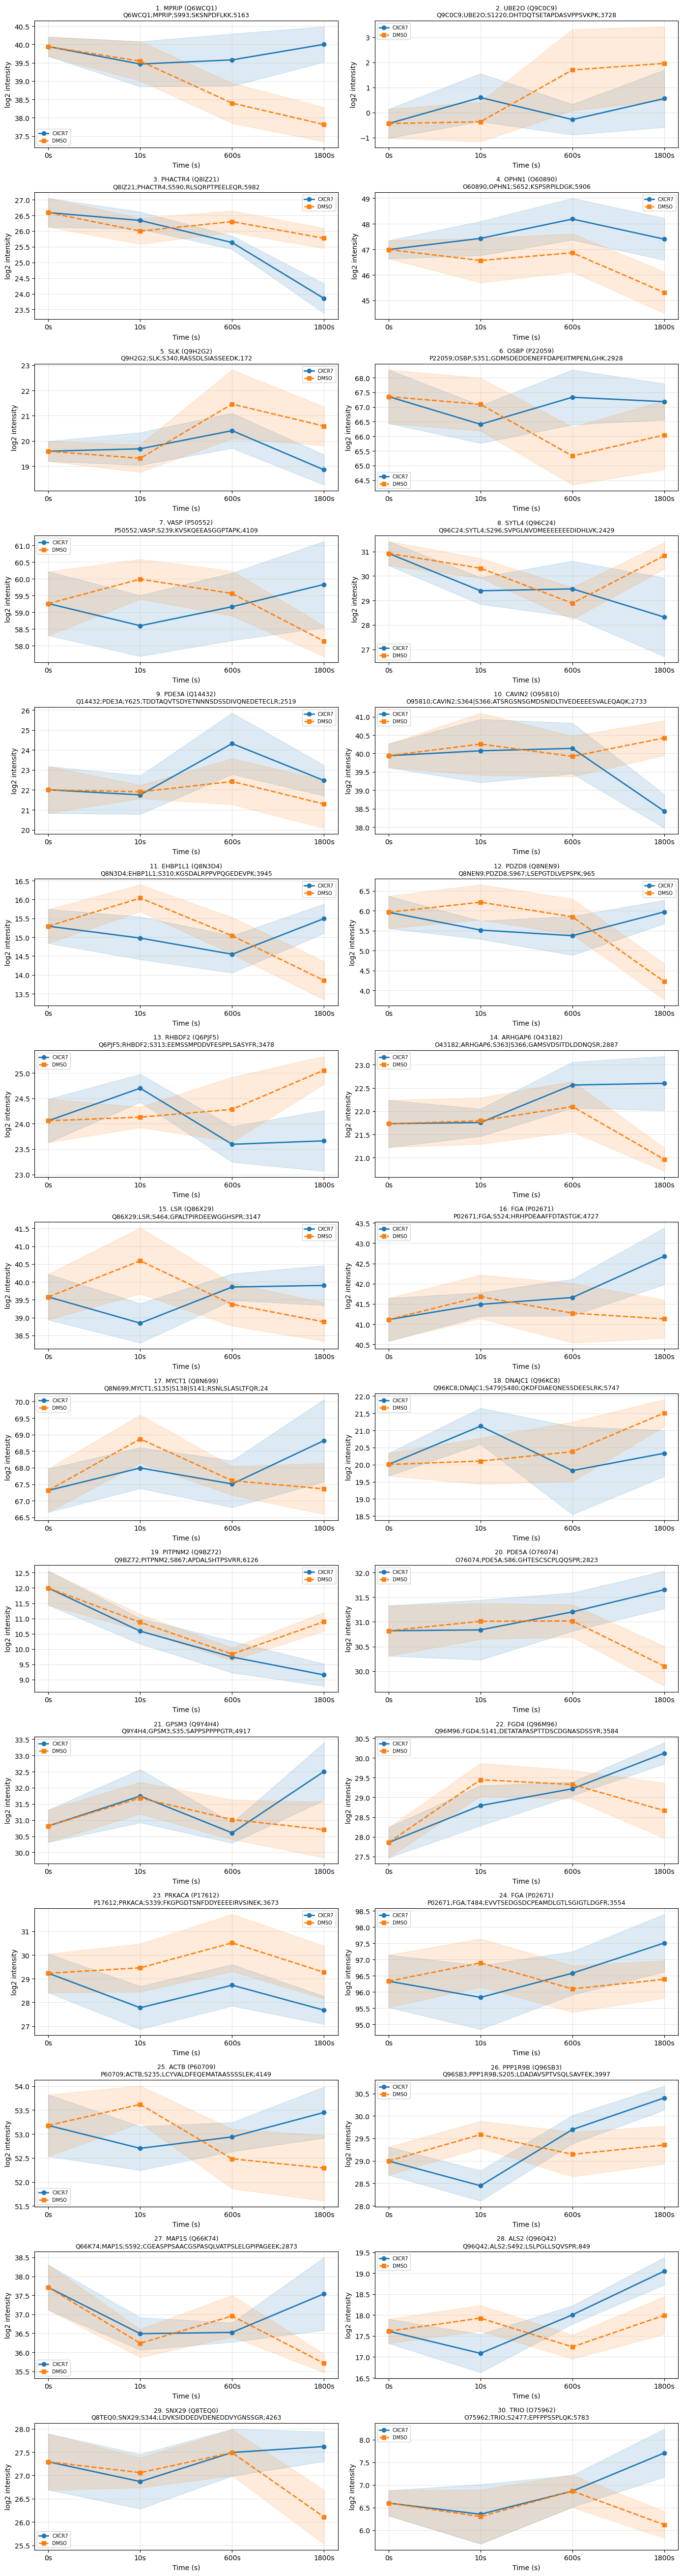


✅ Analysis complete! Sorted by 'abs_delta_slope'. Results saved to: phosphoproteomics/analysis/trajectory_deviation


In [362]:
# ======================================================
# 📊 PHOSPHOSITE TRAJECTORY DEVIATION ANALYSIS (site-level)
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from dtw import dtw
from scipy.integrate import simpson
from scipy.stats import linregress

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_TOP': 50,                           # Number of top phosphosites to report/plot
    'PRIMARY_METRIC': 'abs_delta_slope',  # Options: combined_score, dtw, cosine, euclidean, delta_auc, abs_delta_auc, delta_slope, abs_delta_slope, delta_slope_rel, abs_delta_slope_rel
    'WEIGHT_ABS': 0.5,
    'WEIGHT_SLOPE': 0.25,
    'WEIGHT_AUC': 0.25,
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("✅ Analysis configuration:")
for k, v in CONFIG.items():
    print(f"   {k:25s} = {v}")

# ======================================================
# 🧩 Step 1: Ensure proper index and site info
# ======================================================
if phospho_intensity.index.name is None:
    phospho_intensity.index.name = "phosphosite_id"

phospho_summary = phospho_summary.copy()
phospho_summary["phosphosite_id"] = phospho_intensity.index
phospho_summary = phospho_summary.set_index("phosphosite_id")

# Align all derived tables
for df in [cxcr7_mean, dmso_mean, cxcr7_lower, cxcr7_upper, dmso_lower, dmso_upper]:
    df.index = phospho_summary.index

# ======================================================
# 🧮 Step 2: Compute all metrics per phosphosite
# ======================================================
results = []
for site_id, row in phospho_summary.iterrows():
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    v_cxcr7 = cxcr7_mean.loc[site_id].values.astype(float)
    v_dmso  = dmso_mean.loc[site_id].values.astype(float)

    # === Distance metrics ===
    cos_diff = cosine(v_cxcr7, v_dmso) if not np.all(v_cxcr7 == v_dmso) else 0
    alignment = dtw(v_cxcr7.reshape(-1, 1), v_dmso.reshape(-1, 1))
    dtw_diff = float(alignment.normalizedDistance)
    eucl_diff = np.linalg.norm(v_cxcr7 - v_dmso)

    # === Trend metrics ===
    x = np.arange(len(v_cxcr7))
    s1, _, _, _, _ = linregress(x, v_cxcr7)
    s2, _, _, _, _ = linregress(x, v_dmso)
    delta_slope = s1 - s2
    abs_delta_slope = abs(delta_slope)

    delta_auc = simpson(v_cxcr7, x=x) - simpson(v_dmso, x=x)
    abs_delta_auc = abs(delta_auc)

    # === Baseline normalization ===
    baseline_cxcr7 = v_cxcr7[0] if v_cxcr7[0] != 0 else np.nan
    baseline_dmso  = v_dmso[0] if v_dmso[0] != 0 else np.nan

    norm_slope_cxcr7 = s1 / baseline_cxcr7 if not np.isnan(baseline_cxcr7) else np.nan
    norm_slope_dmso  = s2 / baseline_dmso if not np.isnan(baseline_dmso) else np.nan

    delta_slope_rel = norm_slope_cxcr7 - norm_slope_dmso
    abs_delta_slope_rel = abs(delta_slope_rel)

    results.append([
        site_id, uid, gene,
        cos_diff, dtw_diff, eucl_diff,
        delta_slope, abs_delta_slope,
        delta_slope_rel, abs_delta_slope_rel,
        delta_auc, abs_delta_auc
    ])

metrics_df = pd.DataFrame(
    results,
    columns=[
        'phosphosite_id', 'uniprot_id', 'gene_symbol',
        'cosine', 'dtw', 'euclidean',
        'delta_slope', 'abs_delta_slope',
        'delta_slope_rel', 'abs_delta_slope_rel',
        'delta_auc', 'abs_delta_auc'
    ]
).set_index('phosphosite_id')

# ======================================================
# ⚙️ Step 3: Normalize and combine
# ======================================================
for col in ['cosine', 'dtw', 'euclidean',
            'delta_slope', 'abs_delta_slope',
            'delta_slope_rel', 'abs_delta_slope_rel',
            'delta_auc', 'abs_delta_auc']:
    col_min, col_max = np.nanmin(metrics_df[col]), np.nanmax(metrics_df[col])
    metrics_df[f'{col}_norm'] = 0 if col_max == col_min else (metrics_df[col] - col_min) / (col_max - col_min)

metrics_df['combined_score'] = (
    CONFIG['WEIGHT_ABS']   * metrics_df['dtw_norm'] +
    CONFIG['WEIGHT_SLOPE'] * metrics_df['abs_delta_slope_rel_norm'] +
    CONFIG['WEIGHT_AUC']   * metrics_df['abs_delta_auc_norm']
)

# ======================================================
# 🔢 Step 4: Sort dynamically by selected metric
# ======================================================
print("\n📋 Columns in metrics_df:")
print(metrics_df.columns.tolist())

metric_to_sort = CONFIG['PRIMARY_METRIC']
if metric_to_sort not in metrics_df.columns:
    raise ValueError(f"❌ PRIMARY_METRIC '{metric_to_sort}' not found in metrics_df columns!")

metrics_df = metrics_df.sort_values(metric_to_sort, ascending=False)
top_df = metrics_df.head(CONFIG['N_TOP'])

print(f"\n✅ Computed metrics for {len(metrics_df)} phosphosites")
print(f"📊 Sorted by: {metric_to_sort}")
display(top_df.head(20))

# ======================================================
# 🎨 Step 5: Visualization (with site-level labels)
# ======================================================
timepoints = ['0s', '10s', '600s', '1800s']
n_plots = min(30, len(top_df))
fig, axes = plt.subplots(nrows=n_plots // 2, ncols=2, figsize=(14, 3.5 * (n_plots // 2)))
axes = axes.flatten()

for i, (site_id, row) in enumerate(top_df.iloc[:n_plots].iterrows()):
    gene = row['gene_symbol']
    uid  = row['uniprot_id']

    cx_mean = cxcr7_mean.loc[site_id]
    cx_lo   = cxcr7_lower.loc[site_id]
    cx_hi   = cxcr7_upper.loc[site_id]
    dm_mean = dmso_mean.loc[site_id]
    dm_lo   = dmso_lower.loc[site_id]
    dm_hi   = dmso_upper.loc[site_id]

    ax = axes[i]
    ax.fill_between(timepoints, cx_lo, cx_hi, color='tab:blue', alpha=0.15)
    ax.plot(timepoints, cx_mean, '-o', color='tab:blue', label='CXCR7', lw=2)
    ax.fill_between(timepoints, dm_lo, dm_hi, color='tab:orange', alpha=0.15)
    ax.plot(timepoints, dm_mean, '--s', color='tab:orange', label='DMSO', lw=2)

    ax.set_title(f"{i+1}. {gene} ({uid})\n{site_id}", fontsize=9)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("log2 intensity")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ======================================================
# 💾 Step 6: Save results
# ======================================================
out_dir = base / "phosphoproteomics" / "analysis" / "trajectory_deviation"
out_dir.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(out_dir / "phosphosite_deviation_metrics_all.csv")
top_df.to_csv(out_dir / f"top_{CONFIG['N_TOP']}_phosphosites_sorted_by_{metric_to_sort}.csv")

if CONFIG['SAVE_PLOTS']:
    fig.savefig(out_dir / f"top_{n_plots}_phosphosite_trajectories_sorted_by_{metric_to_sort}.png",
                dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')

print(f"\n✅ Analysis complete! Sorted by '{metric_to_sort}'. Results saved to: {out_dir}")


### 5.1.3 Psites of interest

✅ Analysis configuration:
   N_TOP                     = 50
   PRIMARY_METRIC            = abs_delta_slope
   WEIGHT_ABS                = 0.5
   WEIGHT_SLOPE              = 0.25
   WEIGHT_AUC                = 0.25
   SAVE_PLOTS                = True
   PLOT_DPI                  = 300

🎯 Found 61 phosphosites matching kinase/adaptor patterns.

✅ Computed metrics for 61 phosphosites (filtered)
📊 Sorted by: abs_delta_slope


uniprot_id gene_symbol  \
phosphosite_id                                                              
P17612;PRKACA;S339;FKGPGDTSNFDDYEEEEIRVSINEK;3673      P17612      PRKACA   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...     P12931         SRC   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296                 P29353        SHC1   
P12931;SRC;S51;GPSAAFAPAAAEPK;3238                     P12931         SRC   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1325            Q05655       PRKCD   
P29353;SHC1;S139;HGSFVNKPTR;4972                       P29353        SHC1   
Q04759;PRKCQ;S676;EFLNEKPRLSFADR;5500                  Q04759       PRKCQ   
Q13322;GRB10;S428;SVSENSLVAMDFSGQTGR;2423              Q13322       GRB10   
Q05655;PRKCD;T141;SEDEAKFPTMNRR;5402                   Q05655       PRKCD   
Q07889;SOS1;S1134|S1137;SASVSSISLTK;4889               Q07889        SOS1   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1326            Q05655       PRKCD   
P31323;PRKAR2B;S114;ASVCAEAYNPDEEEDDAESR;3158          P31323     PRKAR2B   
Q13976;PRKG1;T517;TWTFCGTPEYVAPEIILNK;1504             Q13976       PRKG1   
Q04759;PRKCQ;S695;NFSFMNPGMER;1208                     Q04759       PRKCQ   
P10644;PRKAR1A;S83;EDEISPPPPNPVVK;4745                 P10644     PRKAR1A   
Q04759;PRKCQ;S695;NFSFMNPGMER;1210                     Q04759       PRKCQ   
Q96B36;AKT1S1;S88|S92;AATAARPPAPPPAPQPPSPTPSPPR...     Q96B36      AKT1S1   
Q13976;PRKG1;S273;EDSPSEDPVFLR;3467                    Q13976       PRKG1   
P31323;PRKAR2B;S83|S85;GVNFAEEPMQSDSEDGEEEEAAPA...     P31323     PRKAR2B   
P62993;GRB2;S90;ESESAPGDFSLSVK;3801                    P62993        GRB2   

                                                      cosine       dtw  \
phosphosite_id                                                           
P17612;PRKACA;S339;FKGPGDTSNFDDYEEEEIRVSINEK;3673   0.000327  0.650567   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...  0.000073  0.493827   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296              0.000204  0.408989   
P12931;SRC;S51;GPSAAFAPAAAEPK;3238                  0.000418  0.360950   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1325         0.000370  0.239000   
P29353;SHC1;S139;HGSFVNKPTR;4972                    0.000119  0.217939   
Q04759;PRKCQ;S676;EFLNEKPRLSFADR;5500               0.000101  0.158819   
Q13322;GRB10;S428;SVSENSLVAMDFSGQTGR;2423           0.000252  0.263607   
Q05655;PRKCD;T141;SEDEAKFPTMNRR;5402                0.000088  0.218731   
Q07889;SOS1;S1134|S1137;SASVSSISLTK;4889            0.000093  0.129356   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1326         0.000159  0.499792   
P31323;PRKAR2B;S114;ASVCAEAYNPDEEEDDAESR;3158       0.009256  0.148463   
Q13976;PRKG1;T517;TWTFCGTPEYVAPEIILNK;1504          0.000136  0.055980   
Q04759;PRKCQ;S695;NFSFMNPGMER;1208                  0.000109  0.145387   
P10644;PRKAR1A;S83;EDEISPPPPNPVVK;4745              0.000411  0.110322   
Q04759;PRKCQ;S695;NFSFMNPGMER;1210                  0.000014  0.146203   
Q96B36;AKT1S1;S88|S92;AATAARPPAPPPAPQPPSPTPSPPR...  0.000015  0.098003   
Q13976;PRKG1;S273;EDSPSEDPVFLR;3467                 0.000216  0.075275   
P31323;PRKAR2B;S83|S85;GVNFAEEPMQSDSEDGEEEEAAPA...  0.000034  0.061601   
P62993;GRB2;S90;ESESAPGDFSLSVK;3801                 0.000057  0.101470   

                                                    euclidean  delta_slope  \
phosphosite_id                                                               
P17612;PRKACA;S339;FKGPGDTSNFDDYEEEEIRVSINEK;3673    2.935535    -0.490960   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...   1.996177     0.413172   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296               1.948615     0.406014   
P12931;SRC;S51;GPSAAFAPAAAEPK;3238                   1.072877    -0.343476   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1325          0.929334     0.294267   
P29353;SHC1;S139;HGSFVNKPTR;4972                     1.194620     0.286617   
Q04759;PRKCQ;S676;EFLNEKPRLSFADR;5500                0.834473    -0.256341   
Q13322;GRB10;S428;SVSENSL

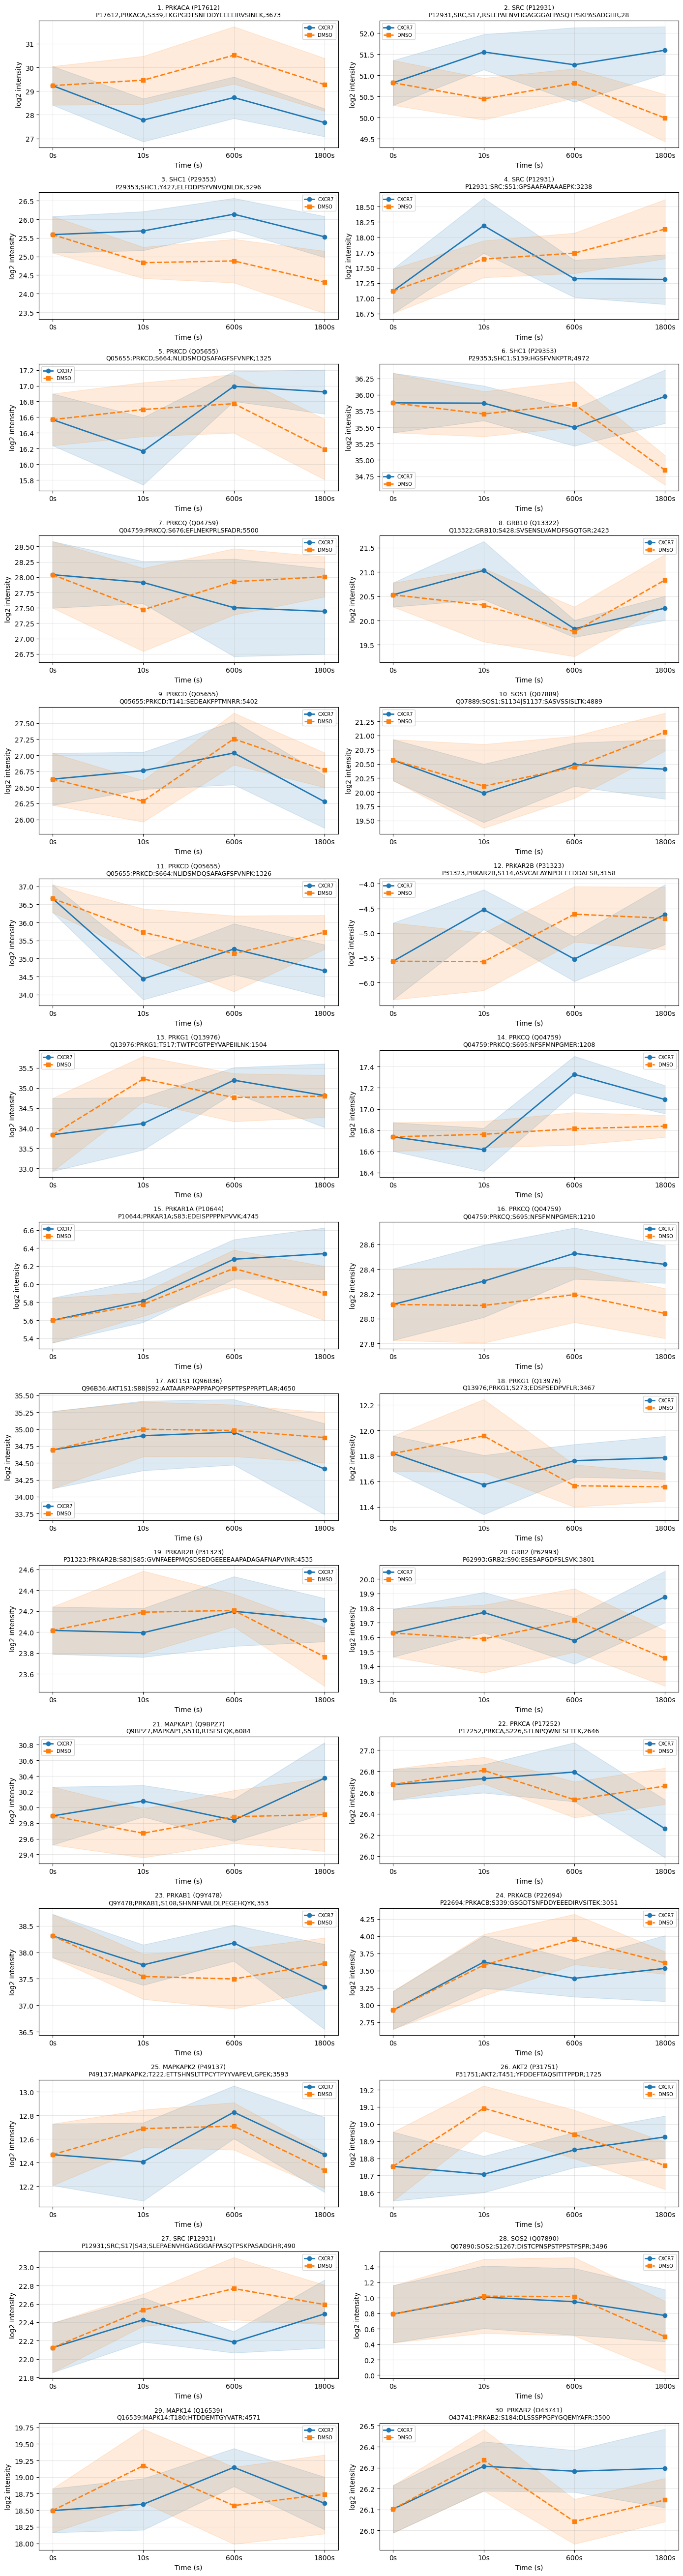


✅ Kinase/adaptor-focused analysis complete! Sorted by 'abs_delta_slope'. Results saved to: /storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation/phosphoproteomics/analysis/trajectory_deviation


In [347]:
# ======================================================
# 📊 PHOSPHOSITE TRAJECTORY DEVIATION ANALYSIS (Kinases / Adaptors)
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from dtw import dtw
from scipy.integrate import simpson
from scipy.stats import linregress
import re

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_TOP': 50,                           # Number of top phosphosites to report/plot
    'PRIMARY_METRIC': 'abs_delta_slope',  # Sort by: combined_score, dtw, cosine, euclidean, delta_auc, abs_delta_auc, delta_slope, abs_delta_slope, delta_slope_rel, abs_delta_slope_rel
    'WEIGHT_ABS': 0.5,
    'WEIGHT_SLOPE': 0.25,
    'WEIGHT_AUC': 0.25,
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("✅ Analysis configuration:")
for k, v in CONFIG.items():
    print(f"   {k:25s} = {v}")

# ======================================================
# 🧩 Step 1: Ensure proper index and site info
# ======================================================
if phospho_intensity.index.name is None:
    phospho_intensity.index.name = "phosphosite_id"

phospho_summary = phospho_summary.copy()
phospho_summary["phosphosite_id"] = phospho_intensity.index
phospho_summary = phospho_summary.set_index("phosphosite_id")

# Align all derived tables
for df in [cxcr7_mean, dmso_mean, cxcr7_lower, cxcr7_upper, dmso_lower, dmso_upper]:
    df.index = phospho_summary.index

# ======================================================
# 🧮 Step 2: Compute all metrics per phosphosite
# ======================================================
results = []
for site_id, row in phospho_summary.iterrows():
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    v_cxcr7 = cxcr7_mean.loc[site_id].values.astype(float)
    v_dmso  = dmso_mean.loc[site_id].values.astype(float)

    # === Distance metrics ===
    cos_diff = cosine(v_cxcr7, v_dmso) if not np.all(v_cxcr7 == v_dmso) else 0
    alignment = dtw(v_cxcr7.reshape(-1, 1), v_dmso.reshape(-1, 1))
    dtw_diff = float(alignment.normalizedDistance)
    eucl_diff = np.linalg.norm(v_cxcr7 - v_dmso)

    # === Trend metrics ===
    x = np.arange(len(v_cxcr7))
    s1, _, _, _, _ = linregress(x, v_cxcr7)
    s2, _, _, _, _ = linregress(x, v_dmso)
    delta_slope = s1 - s2
    abs_delta_slope = abs(delta_slope)

    delta_auc = simpson(v_cxcr7, x=x) - simpson(v_dmso, x=x)
    abs_delta_auc = abs(delta_auc)

    # === Baseline normalization ===
    baseline_cxcr7 = v_cxcr7[0] if v_cxcr7[0] != 0 else np.nan
    baseline_dmso  = v_dmso[0] if v_dmso[0] != 0 else np.nan

    norm_slope_cxcr7 = s1 / baseline_cxcr7 if not np.isnan(baseline_cxcr7) else np.nan
    norm_slope_dmso  = s2 / baseline_dmso if not np.isnan(baseline_dmso) else np.nan

    delta_slope_rel = norm_slope_cxcr7 - norm_slope_dmso
    abs_delta_slope_rel = abs(delta_slope_rel)

    results.append([
        site_id, uid, gene,
        cos_diff, dtw_diff, eucl_diff,
        delta_slope, abs_delta_slope,
        delta_slope_rel, abs_delta_slope_rel,
        delta_auc, abs_delta_auc
    ])

metrics_df = pd.DataFrame(
    results,
    columns=[
        'phosphosite_id', 'uniprot_id', 'gene_symbol',
        'cosine', 'dtw', 'euclidean',
        'delta_slope', 'abs_delta_slope',
        'delta_slope_rel', 'abs_delta_slope_rel',
        'delta_auc', 'abs_delta_auc'
    ]
).set_index('phosphosite_id')

# ======================================================
# ⚙️ Step 3: Normalize and combine
# ======================================================
for col in ['cosine', 'dtw', 'euclidean',
            'delta_slope', 'abs_delta_slope',
            'delta_slope_rel', 'abs_delta_slope_rel',
            'delta_auc', 'abs_delta_auc']:
    col_min, col_max = np.nanmin(metrics_df[col]), np.nanmax(metrics_df[col])
    metrics_df[f'{col}_norm'] = 0 if col_max == col_min else (metrics_df[col] - col_min) / (col_max - col_min)

metrics_df['combined_score'] = (
    CONFIG['WEIGHT_ABS']   * metrics_df['dtw_norm'] +
    CONFIG['WEIGHT_SLOPE'] * metrics_df['abs_delta_slope_rel_norm'] +
    CONFIG['WEIGHT_AUC']   * metrics_df['abs_delta_auc_norm']
)

# ======================================================
# 🎯 Step 4: Filter by kinase/adaptor interest patterns
# ======================================================
interest_patterns = [
    r'^PRKA', r'^PRKC', r'^AKT', r'^SRC',
    r'^MAPK', r'^PRKG', r'^ARRB',
    r'^SOS', r'^SHC', r'^GRB'
]
interest_regex = re.compile('|'.join(interest_patterns), flags=re.IGNORECASE)

metrics_interest = metrics_df[metrics_df['gene_symbol'].str.contains(interest_regex, na=False)]
print(f"\n🎯 Found {len(metrics_interest)} phosphosites matching kinase/adaptor patterns.")

if metrics_interest.empty:
    print("⚠️ No matches found. Showing global top instead.")
    metrics_interest = metrics_df.copy()

# ======================================================
# 🔢 Step 5: Sort dynamically by selected metric
# ======================================================
metric_to_sort = CONFIG['PRIMARY_METRIC']
if metric_to_sort not in metrics_interest.columns:
    raise ValueError(f"❌ PRIMARY_METRIC '{metric_to_sort}' not found in metrics_df columns!")

metrics_interest = metrics_interest.sort_values(metric_to_sort, ascending=False)
top_df = metrics_interest.head(CONFIG['N_TOP'])

print(f"\n✅ Computed metrics for {len(metrics_interest)} phosphosites (filtered)")
print(f"📊 Sorted by: {metric_to_sort}")
display(top_df.head(20))

# ======================================================
# 🎨 Step 6: Visualization (with site-level labels)
# ======================================================
timepoints = ['0s', '10s', '600s', '1800s']
n_plots = min(30, len(top_df))
fig, axes = plt.subplots(nrows=n_plots // 2, ncols=2, figsize=(14, 3.5 * (n_plots // 2)))
axes = axes.flatten()

for i, (site_id, row) in enumerate(top_df.iloc[:n_plots].iterrows()):
    gene = row['gene_symbol']
    uid  = row['uniprot_id']

    cx_mean = cxcr7_mean.loc[site_id]
    cx_lo   = cxcr7_lower.loc[site_id]
    cx_hi   = cxcr7_upper.loc[site_id]
    dm_mean = dmso_mean.loc[site_id]
    dm_lo   = dmso_lower.loc[site_id]
    dm_hi   = dmso_upper.loc[site_id]

    ax = axes[i]
    ax.fill_between(timepoints, cx_lo, cx_hi, color='tab:blue', alpha=0.15)
    ax.plot(timepoints, cx_mean, '-o', color='tab:blue', label='CXCR7', lw=2)
    ax.fill_between(timepoints, dm_lo, dm_hi, color='tab:orange', alpha=0.15)
    ax.plot(timepoints, dm_mean, '--s', color='tab:orange', label='DMSO', lw=2)

    ax.set_title(f"{i+1}. {gene} ({uid})\n{site_id}", fontsize=9)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("log2 intensity")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ======================================================
# 💾 Step 7: Save results
# ======================================================
out_dir = base / "phosphoproteomics" / "analysis" / "trajectory_deviation"
out_dir.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(out_dir / "phosphosite_deviation_metrics_all_psite-of-interest.csv")
metrics_interest.to_csv(out_dir / f"phosphosite_interest_metrics_sorted_by_{metric_to_sort}.csv")
top_df.to_csv(out_dir / f"top_{CONFIG['N_TOP']}_interest_phosphosites_sorted_by_{metric_to_sort}.csv")

if CONFIG['SAVE_PLOTS']:
    fig.savefig(out_dir / f"top_{n_plots}_interest_phosphosite_trajectories_sorted_by_{metric_to_sort}.png",
                dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')

print(f"\n✅ Kinase/adaptor-focused analysis complete! Sorted by '{metric_to_sort}'. Results saved to: {out_dir}")


## 5.3 Decision point: log2FC/psitedeviation and network betweenescentrality

### 5.3.1 Load data

In [390]:
# ======================================================
# 🧬 Step 1–2: Load, Collapse, Build Metadata, and Attach to g_gcc
# ======================================================
import pandas as pd
import igraph as ig
from pathlib import Path

# ======================================================
# 📁 PATH SETUP (robust)
# ======================================================
# Try both absolute and relative structures
BASE_ABS = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
BASE_REL = Path(".")  # local analysis folder

# Prefer the one that actually exists
if (BASE_ABS / "phosphoproteomics").exists():
    BASE = BASE_ABS
    print("📂 Using absolute project path")
else:
    BASE = BASE_REL
    print("📂 Using relative path (local analysis folder)")

# Define file paths
PHOSPHO_PATH = BASE / "phosphoproteomics" / "analysis" / "trajectory_deviation" / "phosphosite_deviation_metrics_all.csv"
BETWEENNESS_PATH = BASE / "phosphoproteomics" / "analysis" / "networks" / "subnetworks" / "betweenness_dtw_dynamics_stable" / "betweenness_dtw_metrics.csv"
PREPARED_DIR = BASE / "analysis" / "networks" / "prepared_data"
OUTPUT_DIR = BASE / "phosphoproteomics" / "analysis" / "trajectory_deviation"


📂 Using absolute project path


In [392]:
# ======================================================
# 📥 LOAD PHOSPHOSITE DEVIATION METRICS
# ======================================================
phospho_metrics = pd.read_csv(PHOSPHO_PATH)
print(f"✅ Loaded phosphosite deviation metrics: {phospho_metrics.shape[0]} sites × {phospho_metrics.shape[1]} columns")

# ======================================================
# 🧮 COLLAPSE TO PROTEIN LEVEL (highest |ΔSlope|)
# ======================================================
phospho_sorted = phospho_metrics.sort_values("abs_delta_slope", ascending=False)
protein_metrics = (
    phospho_sorted
    .groupby(["uniprot_id", "gene_symbol"], as_index=False)
    .first()
    .sort_values("abs_delta_slope", ascending=False)
)
print(f"✅ Collapsed to top phosphosite per protein → {protein_metrics.shape[0]} proteins")

# Preview top 10 proteins with full metrics context
display(top_site_per_protein.head(10))

# Save collapsed data
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
protein_metrics.to_csv(OUTPUT_DIR / "top_site_per_protein.csv", index=False)
print(f"💾 Saved → {OUTPUT_DIR / 'top_site_per_protein.csv'}")

✅ Loaded phosphosite deviation metrics: 3772 sites × 22 columns
✅ Collapsed to top phosphosite per protein → 1313 proteins


uniprot_id gene_symbol  \
723      Q6WCQ1       MPRIP   
1051     Q9C0C9       UBE2O   
812      Q8IZ21     PHACTR4   
114      O60890       OPHN1   
1067     Q9H2G2         SLK   
279      P22059        OSBP   
388      P50552        VASP   
938      Q96C24       SYTL4   
562      Q14432       PDE3A   
167      O95810      CAVIN2   

                                         phosphosite_id    cosine       dtw  \
723                   Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163  0.000286  0.555358   
1051     Q9C0C9;UBE2O;S1220;DHTDQTSETAPDASVPPSVKPK;3728  0.775837  0.574886   
812             Q8IZ21;PHACTR4;S590;RLSQRPTPEELEQR;5982  0.000573  0.353193   
114                  O60890;OPHN1;S652;KSPSRPILDGK;5906  0.000131  0.634324   
1067                Q9H2G2;SLK;S340;RASSDLSIASSEEDK;172  0.000860  0.540782   
279   P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;...  0.000120  0.518422   
388              P50552;VASP;S239;KVSKQEEASGGPTAPK;4109  0.000178  0.380507   
938      Q96C24;SYTL4;S296;SVPGLNVDMEEEEEEEDIDHLVK;2429  0.000769  0.661400   
562   Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDE...  0.000699  0.494681   
167   O95810;CAVIN2;S364|S366;ATSRGSNSGMDSNIDLTIVEDE...  0.000245  0.358093   

      euclidean  delta_slope  abs_delta_slope  delta_slope_rel  \
723    2.486613     0.782063         0.782063         0.019580   
1051   2.612379    -0.715642         0.715642         1.611505   
812    2.061222    -0.676820         0.676820        -0.025454   
114    2.623327     0.673443         0.673443         0.014330   
1067   2.056584    -0.660897         0.660897        -0.033730   
279    2.401800     0.610132         0.610132         0.009059   
388    2.234159     0.609701         0.609701         0.010288   
938    2.738952    -0.601727         0.601727        -0.019460   
562    2.243751     0.559688         0.559688         0.025433   
167    2.012974    -0.557612         0.557612        -0.013961   

      abs_delta_slope_rel  ...  cosine_norm  dtw_norm  euclidean_norm  \
723              0.019580  ...     0.000155  0.724796        0.512996   
1051             1.611505  ...     0.420909  0.750439        0.539068   
812              0.025454  ...     0.000311  0.459331        0.424810   
114              0.014330  ...     0.000071  0.828487        0.541337   
1067             0.033730  ...     0.000466  0.705656        0.423848   
279              0.009059  ...     0.000065  0.676295        0.495413   
388              0.010288  ...     0.000096  0.495198        0.460660   
938              0.019460  ...     0.000417  0.864041        0.565307   
562              0.025433  ...     0.000379  0.645121        0.462649   
167              0.013961  ...     0.000133  0.465766        0.414808   

      delta_slope_norm  abs_delta_slope_norm  delta_slope_rel_norm  \
723           1.000000              1.000000              0.022945   
1051          0.000000              0.915067              0.043398   
812           0.025921              0.865424              0.022367   
114           0.927476              0.861106              0.022878   
1067          0.036553              0.845062              0.022260   
279           0.885204              0.780148              0.022810   
388           0.884916              0.779598              0.022826   
938           0.076060              0.769401              0.022444   
562           0.851523              0.715644              0.023020   
167           0.105515              0.712991              0.022514   

      abs_delta_slope_rel_norm  delta_auc_norm  abs_delta_auc_norm  \
723                   0.000257        0.776381            0.436516   
1051                  0.021185        0.380017            0.296846   
812                   0.000335        0.416984            0.228445   
114                   0.000188        0.928553            0.718084   
1067                  0.000443        0.386465            0.284916   
279                   0.000119        0.733059            0.356356   
3

💾 Saved → /storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation/phosphoproteomics/analysis/trajectory_deviation/top_site_per_protein.csv


In [394]:
# ======================================================
# 💾 LOAD OPTIONAL BETWEENNESS / DTW METRICS
# ======================================================
from pathlib import Path

# Primary and fallback locations
betw_paths = [
    BASE / "phosphoproteomics" / "analysis" / "networks" / "subnetworks" / "betweenness_dtw_dynamics_stable" / "betweenness_dtw_metrics.csv",
    BASE / "analysis" / "networks" / "subnetworks" / "betweenness_dtw_dynamics_stable" / "betweenness_dtw_metrics.csv",
    Path("analysis/networks/subnetworks/betweenness_dtw_dynamics_stable/betweenness_dtw_metrics.csv")
]

betw_metrics = None
for p in betw_paths:
    if p.exists():
        betw_metrics = pd.read_csv(p, index_col=0)
        print(f"✅ Loaded betweenness/DTW metrics from: {p}")
        print(f"   Shape: {betw_metrics.shape}")
        break

if betw_metrics is None:
    print("⚠️  Betweenness/DTW metrics not found in expected locations — continuing without them.")


✅ Loaded betweenness/DTW metrics from: analysis/networks/subnetworks/betweenness_dtw_dynamics_stable/betweenness_dtw_metrics.csv
   Shape: (467, 14)


In [396]:
from pathlib import Path
import pandas as pd

# Define input directory (relative to your notebook)
in_dir = Path("analysis") / "networks" / "prepared_data"

# Load the proteome fold-change table
prot_fc = pd.read_csv(in_dir / "proteome_fc.csv", index_col=0)

print(f"✅ Loaded proteome_fc.csv → {prot_fc.shape[0]} proteins × {prot_fc.shape[1]} columns")
display(prot_fc.head(5))


✅ Loaded proteome_fc.csv → 2326 proteins × 10 columns


logFC.10  P.Value.10  adj.P.Val.10  logFC.600  P.Value.600  \
UniProt                                                                  
A0A075B6I0  0.229630    0.326486      0.999876   0.148452     0.513700   
A0A0A0MS15  0.087997    0.869758      0.999876  -0.130536     0.802694   
A0A0B4J1U7  0.018450    0.967442      0.999876   0.020623     0.962613   
A0A0B4J1X5  0.119885    0.604642      0.999876   0.015170     0.946281   
A0A0B4J1Y9  0.073269    0.750885      0.999876   0.126968     0.572246   

            adj.P.Val.600  logFC.1800  P.Value.1800  adj.P.Val.1800  \
UniProt                                                               
A0A075B6I0       0.999896   -0.030090      0.894522          0.9993   
A0A0A0MS15       0.999896   -0.031189      0.952384          0.9993   
A0A0B4J1U7       0.999896    0.044284      0.919826          0.9993   
A0A0B4J1X5       0.999896    0.109947      0.625630          0.9993   
A0A0B4J1Y9       0.999896    0.031596      0.888107          0.9993   

           gene_symbol  
UniProt                 
A0A075B6I0  A0A075B6I0  
A0A0A0MS15  A0A0A0MS15  
A0A0B4J1U7  A0A0B4J1U7  
A0A0B4J1X5  A0A0B4J1X5  
A0A0B4J1Y9  A0A0B4J1Y9

### 5.3.2 Build metadata 

In [397]:
import pandas as pd

# Ensure consistent naming
psite_df = top_site_per_protein.copy()
psite_df = psite_df.rename(columns={"uniprot_id": "UniProt"})

# Extract relevant columns from proteome FC table
prot_meta = prot_fc.reset_index().rename(columns={"index": "UniProt"})
if "gene_symbol" not in prot_meta.columns:
    prot_meta["gene_symbol"] = prot_meta["UniProt"]

prot_meta = prot_meta[["UniProt", "gene_symbol"]].drop_duplicates()

# Merge: keep all phosphosites, fill missing UniProt/gene_symbol from proteome data
metadata = (
    psite_df.merge(prot_meta, on="UniProt", how="outer", suffixes=("_phospho", "_prot"))
)

# Prefer phospho gene symbol (more specific), fall back to proteome gene symbol
metadata["gene_symbol"] = metadata["gene_symbol_phospho"].combine_first(metadata["gene_symbol_prot"])

# Fill missing numeric metrics with zeros
numeric_cols = [
    "delta_slope", "abs_delta_slope", "delta_auc", "abs_delta_auc", "combined_score",
    "dtw", "abs_delta_slope_norm", "abs_delta_auc_norm"
]
for col in numeric_cols:
    if col in metadata.columns:
        metadata[col] = metadata[col].fillna(0)

# Clean up redundant columns
metadata = metadata.drop(columns=["gene_symbol_phospho", "gene_symbol_prot"], errors="ignore")

print(f"✅ Unified metadata table: {metadata.shape[0]} entries × {metadata.shape[1]} columns")
display(metadata.head(10))


✅ Unified metadata table: 2916 entries × 22 columns


UniProt                                     phosphosite_id    cosine  \
0  A0A075B6I0                                                NaN       NaN   
1  A0A0A0MS15                                                NaN       NaN   
2  A0A0B4J1U7                                                NaN       NaN   
3  A0A0B4J1X5                                                NaN       NaN   
4  A0A0B4J1Y9                                                NaN       NaN   
5  A0A0C4DH43                                                NaN       NaN   
6      A0AVT1                                                NaN       NaN   
7      A0FGR8        A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736  0.000170   
8      A1A4S6  A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664  0.000017   
9      A1L0T0                                                NaN       NaN   

        dtw  euclidean  delta_slope  abs_delta_slope  delta_slope_rel  \
0  0.000000        NaN     0.000000         0.000000              NaN   
1  0.000000        NaN     0.000000         0.000000              NaN   
2  0.000000        NaN     0.000000         0.000000              NaN   
3  0.000000        NaN     0.000000         0.000000              NaN   
4  0.000000        NaN     0.000000         0.000000              NaN   
5  0.000000        NaN     0.000000         0.000000              NaN   
6  0.000000        NaN     0.000000         0.000000              NaN   
7  0.248443   0.836646     0.228243         0.228243         0.015580   
8  0.078184   0.244207     0.077003         0.077003         0.004077   
9  0.000000        NaN     0.000000         0.000000              NaN   

   abs_delta_slope_rel  delta_auc  ...  dtw_norm  euclidean_norm  \
0                  NaN   0.000000  ...       NaN             NaN   
1                  NaN   0.000000  ...       NaN             NaN   
2                  NaN   0.000000  ...       NaN             NaN   
3                  NaN   0.000000  ...       NaN             NaN   
4                  NaN   0.000000  ...       NaN             NaN   
5                  NaN   0.000000  ...       NaN             NaN   
6                  NaN   0.000000  ...       NaN             NaN   
7             0.015580   0.980959  ...  0.321783        0.170948   
8             0.004077   0.089862  ...  0.098215        0.048132   
9                  NaN   0.000000  ...       NaN             NaN   

   delta_slope_norm  abs_delta_slope_norm  delta_slope_rel_norm  \
0               NaN              0.000000                   NaN   
1               NaN              0.000000                   NaN   
2               NaN              0.000000                   NaN   
3               NaN              0.000000                   NaN   
4               NaN              0.000000                   NaN   
5               NaN              0.000000                   NaN   
6               NaN              0.000000                   NaN   
7          0.630221              0.291820              0.022894   
8          0.529240              0.098427              0.022746   
9               NaN              0.000000                   NaN   

   abs_delta_slope_rel_norm  delta_auc_norm  abs_delta_auc_norm  \
0                       NaN             NaN            0.000000   
1                       NaN             NaN            0.000000   
2                       NaN             NaN            0.000000   
3                       NaN             NaN            0.000000   
4                       NaN             NaN            0.000000   
5                       NaN             NaN            0.000000   
6                       NaN             NaN            0.000000   
7                  0.000205        0.656560            0.214808   
8                  0.000054        0.551093            0.019660   
9                       NaN             NaN            0.000000   

   combined_score  gene_symbol  
0        0.000000   A0A075B6I0  
1        0.000000   A0A0A0MS15  
2        0.000000  

In [398]:
import pandas as pd

def parse_phosphosite_id(psite_id):
    """Split composite phosphosite_id like 'A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736'."""
    if pd.isna(psite_id):
        return pd.Series({"UniProt": None, "gene_symbol": None, "site": None})
    parts = str(psite_id).split(";")
    return pd.Series({
        "UniProt": parts[0] if len(parts) > 0 else None,
        "gene_symbol": parts[1] if len(parts) > 1 else None,
        "site": parts[2] if len(parts) > 2 else None
    })

# Apply extraction to your table
metadata_extracted = metadata.copy()
parsed_cols = metadata_extracted["phosphosite_id"].apply(parse_phosphosite_id)
metadata_extracted[["UniProt_extracted", "gene_symbol_extracted", "site"]] = parsed_cols

# Fill missing UniProt/gene_symbol from extracted values
metadata_extracted["UniProt"] = metadata_extracted["UniProt"].combine_first(metadata_extracted["UniProt_extracted"])
metadata_extracted["gene_symbol"] = metadata_extracted["gene_symbol"].combine_first(metadata_extracted["gene_symbol_extracted"])

# Drop helper columns
metadata_extracted = metadata_extracted.drop(columns=["UniProt_extracted", "gene_symbol_extracted"], errors="ignore")

print(f"✅ Parsed phosphosite_id fields → UniProt, gene_symbol, site")
display(metadata_extracted.head(10)[["phosphosite_id", "UniProt", "gene_symbol", "site"]])


✅ Parsed phosphosite_id fields → UniProt, gene_symbol, site


phosphosite_id     UniProt gene_symbol  \
0                                                NaN  A0A075B6I0  A0A075B6I0   
1                                                NaN  A0A0A0MS15  A0A0A0MS15   
2                                                NaN  A0A0B4J1U7  A0A0B4J1U7   
3                                                NaN  A0A0B4J1X5  A0A0B4J1X5   
4                                                NaN  A0A0B4J1Y9  A0A0B4J1Y9   
5                                                NaN  A0A0C4DH43  A0A0C4DH43   
6                                                NaN      A0AVT1        UBA6   
7        A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736      A0FGR8       ESYT2   
8  A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664      A1A4S6    ARHGAP10   
9                                                NaN      A1L0T0       HACL2   

   site  
0  None  
1  None  
2  None  
3  None  
4  None  
5  None  
6  None  
7  S758  
8  S591  
9  None

In [399]:
# 1️⃣ Proteins with at least one phosphosite (non-null site)
proteins_with_psites = metadata_extracted[metadata_extracted["site"].notna()]["UniProt"].nunique()

# 2️⃣ Proteins without phosphosite (site is NaN)
proteins_without_psites = metadata_extracted[metadata_extracted["site"].isna()]["UniProt"].nunique()

# 3️⃣ Total unique proteins
total_proteins = metadata_extracted["UniProt"].nunique()

print(f"🧬 Total unique proteins: {total_proteins}")
print(f"⚡ Proteins with phosphosites: {proteins_with_psites}")
print(f"💤 Proteins without phosphosites: {proteins_without_psites}")
print(f"📊 Fraction with phosphosites: {proteins_with_psites / total_proteins:.2%}")


🧬 Total unique proteins: 2912
⚡ Proteins with phosphosites: 1309
💤 Proteins without phosphosites: 1603
📊 Fraction with phosphosites: 44.95%


### 5.3.3 Attach phosphosite metrics and metadata  to existing g_gcc

In [400]:
# ======================================================
# 🌐 ATTACH METADATA (phosphosite + proteome metrics) TO g_gcc
# ======================================================
import pandas as pd

if "g_gcc" not in locals():
    print("⚠️ No g_gcc found in memory — skipping network annotation for now.")
else:
    print(f"🧩 Attaching metadata to g_gcc ({g_gcc.vcount()} nodes)...")

    # Prepare UniProt list from network nodes
    node_names = g_gcc.vs["name"]
    nodes_df = pd.DataFrame({"UniProt": node_names})

    # Merge metadata with node list
    annot = nodes_df.merge(metadata_extracted, on="UniProt", how="left")

    # Fill missing categorical and numeric values
    annot["gene_symbol"] = annot["gene_symbol"].fillna("")
    annot["phosphosite_id"] = annot["phosphosite_id"].fillna("")
    annot["site"] = annot["site"].fillna("")

    metric_cols = [
        "delta_slope", "abs_delta_slope", "delta_auc", "abs_delta_auc",
        "combined_score", "dtw", "abs_delta_slope_norm", "abs_delta_auc_norm"
    ]
    for col in metric_cols:
        if col in annot.columns:
            annot[col] = annot[col].fillna(0)

    # Push attributes into igraph vertex attributes
    attach_cols = ["gene_symbol", "phosphosite_id", "site"] + [
        col for col in metric_cols if col in annot.columns
    ]
    for col in attach_cols:
        g_gcc.vs[col] = annot[col].tolist()

    print(f"✅ Annotated {len(g_gcc.vs)} vertices with {len(attach_cols)} attributes")

    # ------------------------------------------------------
    # Optional: attach DTW metrics from betw_metrics
    # ------------------------------------------------------
    if betw_metrics is not None and "gene_symbol" in betw_metrics.columns:
        betw_map = betw_metrics.set_index("gene_symbol").to_dict(orient="index")
        g_gcc.vs["dtw_betw"] = [None] * g_gcc.vcount()
        g_gcc.vs["combined_dtw_betw"] = [None] * g_gcc.vcount()
        for v in g_gcc.vs:
            gs = v["gene_symbol"]
            if gs in betw_map:
                v["dtw_betw"] = betw_map[gs].get("dtw", None)
                v["combined_dtw_betw"] = betw_map[gs].get("combined_dtw", None)
        print("✅ Added DTW betweenness metrics for matching gene symbols")

    # ------------------------------------------------------
    # Summary table
    # ------------------------------------------------------
    summary_cols = ["name", "gene_symbol", "site", "delta_slope", "abs_delta_slope", "delta_auc", "abs_delta_auc", "combined_score"]
    summary_cols = [c for c in summary_cols if c in g_gcc.vs.attributes()]

    summary_df = pd.DataFrame({col: g_gcc.vs[col] for col in summary_cols})
    print(f"\n📊 Annotated vertices summary: {summary_df.shape[0]} nodes")
    display(summary_df.head(10))


🧩 Attaching metadata to g_gcc (581 nodes)...
✅ Annotated 581 vertices with 11 attributes

📊 Annotated vertices summary: 581 nodes


name gene_symbol  site  delta_slope  abs_delta_slope  delta_auc  \
0  P0DP24       CALM2           0.000000         0.000000   0.000000   
1  Q9Y210       TRPC6   S94     0.079137         0.079137  -0.009224   
2  P06241         FYN   S25     0.067988         0.067988  -0.150654   
3  P49137    MAPKAPK2  T222     0.079732         0.079732  -0.177862   
4  Q16539      MAPK14  T180     0.075121         0.075121  -0.207030   
5  P31749        AKT1  S129     0.045927         0.045927  -0.903394   
6  O15111        CHUK           0.000000         0.000000   0.000000   
7  P19838       NFKB1           0.000000         0.000000   0.000000   
8  P27986      PIK3R1           0.000000         0.000000   0.000000   
9  P78536      ADAM17  S791    -0.096917         0.096917  -0.131354   

   abs_delta_auc  combined_score  
0       0.000000        0.000000  
1       0.009224        0.095635  
2       0.150654        0.047711  
3       0.177862        0.066835  
4       0.207030        0.037743  
5       0.903394        0.167479  
6       0.000000        0.000000  
7       0.000000        0.000000  
8       0.000000        0.000000  
9       0.131354        0.112439

In [ ]:
# ------------------------------------------------------
# 6️⃣ (Optional) Save annotated GCC to file
# ------------------------------------------------------
graph_out = base / "phosphoproteomics" / "analysis" / "network" / "gcc_annotated.graphml"
g_gcc.write_graphml(graph_out)
print(f"💾 Saved annotated GCC → {graph_out}")

### 5.3.4 Subgroups of note and decision metrices

In [403]:
# ======================================================
# 🧭 STEP 4–5: Define Subsets and Compute Subset-Relative Metrics
# ======================================================
import numpy as np
import pandas as pd
import igraph as ig

print(f"🔧 Using {g_gcc.vcount()} nodes to define subsets and compute metrics")

# ------------------------------------------------------
# 1️⃣ Define subsets
# ------------------------------------------------------
df_nodes = pd.DataFrame({
    "name": g_gcc.vs["name"],
    "gene_symbol": g_gcc.vs["gene_symbol"],
    "delta_auc": g_gcc.vs["delta_auc"],
    "abs_delta_auc": g_gcc.vs["abs_delta_auc"],
})

N_TOP = 50  # adjustable subset size

subset_defs = {
    "TopAbsDeltaAUC": df_nodes.nlargest(N_TOP, "abs_delta_auc")["name"].tolist(),
    "TopDeltaAUC_Up": df_nodes.nlargest(N_TOP, "delta_auc")["name"].tolist(),
    "TopDeltaAUC_Down": df_nodes.nsmallest(N_TOP, "delta_auc")["name"].tolist(),
}

print(f"✅ Defined subsets (each of size {N_TOP}): {list(subset_defs.keys())}")

🔧 Using 581 nodes to define subsets and compute metrics
✅ Defined subsets (each of size 50): ['TopAbsDeltaAUC', 'TopDeltaAUC_Up', 'TopDeltaAUC_Down']


In [404]:
# ------------------------------------------------------
# 2️⃣ Helper functions for per-node subset metrics
# ------------------------------------------------------
def avg_distance_to_subset(graph, subset_names):
    """
    Compute mean shortest-path distance from each node to nodes in subset.
    Compatible with igraph >=0.10.
    """
    name_to_idx = {v["name"]: i for i, v in enumerate(graph.vs)}
    subset_idx = [name_to_idx[n] for n in subset_names if n in name_to_idx]
    
    # Compute distance matrix (directed mode)
    dist = np.array(graph.distances(mode="out"))
    
    avg_dists = []
    for i in range(graph.vcount()):
        d = [dist[i][j] for j in subset_idx if np.isfinite(dist[i][j])]
        avg_dists.append(np.mean(d) if len(d) > 0 else np.nan)
    return avg_dists

def count_reach(graph, subset_names, mode="out"):
    """For each node, count how many subset nodes are reachable (up/down)."""
    name_to_idx = {v["name"]: i for i, v in enumerate(graph.vs)}
    subset_idx = [name_to_idx[n] for n in subset_names if n in name_to_idx]
    reach_counts = np.zeros(graph.vcount())
    for i, v in enumerate(graph.vs):
        neigh = graph.neighborhood(i, mode=mode)
        reach_counts[i] = sum(j in subset_idx for j in neigh)
    return reach_counts

def neighbor_composition(graph):
    """Return for each node: number of incoming/outgoing neighbors."""
    indeg = graph.indegree()
    outdeg = graph.outdegree()
    return indeg, outdeg


In [405]:
# ------------------------------------------------------
# 3️⃣ Compute core global metrics (used across subsets)
# ------------------------------------------------------
g_gcc.vs["betweenness"] = g_gcc.betweenness(directed=True)
max_betw = max(g_gcc.vs["betweenness"]) or 1
g_gcc.vs["betweenness_frac"] = [b / max_betw for b in g_gcc.vs["betweenness"]]

ppr = g_gcc.personalized_pagerank(directed=True)
max_ppr = max(ppr)
g_gcc.vs["ppr_reach"] = [x / max_ppr for x in ppr]

indeg, outdeg = neighbor_composition(g_gcc)
g_gcc.vs["n_input"] = indeg
g_gcc.vs["n_target"] = outdeg

In [406]:
# ------------------------------------------------------
# 4️⃣ Compute metrics for each subset
# ------------------------------------------------------
subset_metrics = []

for subset_name, subset_list in subset_defs.items():
    print(f"\n📊 Computing metrics relative to subset: {subset_name}")

    # Distance & reach relative to subset
    avg_dist = avg_distance_to_subset(g_gcc, subset_list)
    reach_down = count_reach(g_gcc, subset_list, mode="out")
    reach_up = count_reach(g_gcc, subset_list, mode="in")

    # Create table of metrics
    tmp_df = pd.DataFrame({
        "UniProt": g_gcc.vs["name"],
        "gene_symbol": g_gcc.vs["gene_symbol"],
        "subset": subset_name,
        "delta_auc": g_gcc.vs["delta_auc"],
        "abs_delta_auc": g_gcc.vs["abs_delta_auc"],
        "betweenness_frac": g_gcc.vs["betweenness_frac"],
        "ppr_reach": g_gcc.vs["ppr_reach"],
        "avg_dist_to_subset": avg_dist,
        "reach_upstream_to_subset": reach_up,
        "reach_downstream_to_subset": reach_down,
        "n_input": g_gcc.vs["n_input"],
        "n_target": g_gcc.vs["n_target"],
    })
    subset_metrics.append(tmp_df)



📊 Computing metrics relative to subset: TopAbsDeltaAUC

📊 Computing metrics relative to subset: TopDeltaAUC_Up

📊 Computing metrics relative to subset: TopDeltaAUC_Down


In [408]:
# Merge all subset-specific metrics
subset_metrics_df = pd.concat(subset_metrics, ignore_index=True)
print(f"\n✅ Computed subset-relative metrics for {subset_metrics_df.shape[0]} node–subset pairs")

# ------------------------------------------------------
# 5️⃣ Save results
# ------------------------------------------------------
out_dir = BASE / "phosphoproteomics" / "analysis" / "networks" / "subset_metrics"
out_dir.mkdir(parents=True, exist_ok=True)
subset_metrics_path = out_dir / f"subset_metrics_N{N_TOP}.csv"
subset_metrics_df.to_csv(subset_metrics_path, index=False)
print(f"💾 Saved → {subset_metrics_path}")

# Preview
display(subset_metrics_df.head(40))



✅ Computed subset-relative metrics for 1743 node–subset pairs
💾 Saved → /storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation/phosphoproteomics/analysis/networks/subset_metrics/subset_metrics_N50.csv


UniProt gene_symbol          subset  delta_auc  abs_delta_auc  \
0   P0DP24       CALM2  TopAbsDeltaAUC   0.000000       0.000000   
1   Q9Y210       TRPC6  TopAbsDeltaAUC  -0.009224       0.009224   
2   P06241         FYN  TopAbsDeltaAUC  -0.150654       0.150654   
3   P49137    MAPKAPK2  TopAbsDeltaAUC  -0.177862       0.177862   
4   Q16539      MAPK14  TopAbsDeltaAUC  -0.207030       0.207030   
5   P31749        AKT1  TopAbsDeltaAUC  -0.903394       0.903394   
6   O15111        CHUK  TopAbsDeltaAUC   0.000000       0.000000   
7   P19838       NFKB1  TopAbsDeltaAUC   0.000000       0.000000   
8   P27986      PIK3R1  TopAbsDeltaAUC   0.000000       0.000000   
9   P78536      ADAM17  TopAbsDeltaAUC  -0.131354       0.131354   
10  P05067         APP  TopAbsDeltaAUC   0.000000       0.000000   
11  O14672      ADAM10  TopAbsDeltaAUC   0.290941       0.290941   
12  P17252       PRKCA  TopAbsDeltaAUC  -0.005338       0.005338   
13  P18206         VCL  TopAbsDeltaAUC   0.012928       0.012928   
14  P30086       PEBP1  TopAbsDeltaAUC   0.000000       0.000000   
15  P04049        RAF1  TopAbsDeltaAUC   0.564337       0.564337   
16  P42574       CASP3  TopAbsDeltaAUC   0.000000       0.000000   
17  Q13177        PAK2  TopAbsDeltaAUC  -0.971407       0.971407   
18  P06396         GSN  TopAbsDeltaAUC   1.302329       1.302329   
19  Q05209      PTPN12  TopAbsDeltaAUC   1.574198       1.574198   
20  Q05397        PTK2  TopAbsDeltaAUC  -0.603115       0.603115   
21  O43318      MAP3K7  TopAbsDeltaAUC   0.595313       0.595313   
22  P45985      MAP2K4  TopAbsDeltaAUC  -0.452361       0.452361   
23  P63000        RAC1  TopAbsDeltaAUC   0.000000       0.000000   
24  P42345        MTOR  TopAbsDeltaAUC   0.067807       0.067807   
25  Q8N122       RPTOR  TopAbsDeltaAUC   0.208893       0.208893   
26  Q96B36      AKT1S1  TopAbsDeltaAUC  -0.337258       0.337258   
27  O95352        ATG7  TopAbsDeltaAUC   0.000000       0.000000   
28  Q9NT62        ATG3  TopAbsDeltaAUC   0.000000       0.000000   
29  P17655       CAPN2  TopAbsDeltaAUC   0.000000       0.000000   
30  P55957         BID  TopAbsDeltaAUC   0.000000       0.000000   
31  P07384       CAPN1  TopAbsDeltaAUC   0.000000       0.000000   
32  Q13813      SPTAN1  TopAbsDeltaAUC  -0.683000       0.683000   
33  Q04637      EIF4G1  TopAbsDeltaAUC  -0.107538       0.107538   
34  P78344      EIF4G2  TopAbsDeltaAUC   0.106134       0.106134   
35  O43432      EIF4G3  TopAbsDeltaAUC   0.368663       0.368663   
36  P55212       CASP6  TopAbsDeltaAUC   0.000000       0.000000   
37  P08670         VIM  TopAbsDeltaAUC   0.468225       0.468225   
38  P11233        RALA  TopAbsDeltaAUC   0.000000       0.000000   
39  Q15311      RALBP1  TopAbsDeltaAUC   0.402456       0.402456   

    betweenness_frac  ppr_reach  avg_dist_to_subset  reach_upstream_to_subset  \
0           0.000000   0.027571               3.675                       0.0   
1           0.000000   0.037840                 NaN                       0.0   
2           0.136391   0.171200               2.975                       1.0   
3           0.040215   0.070775               3.775                       0.0   
4           0.418388   0.635247               3.175                       2.0   
5           0.868529   0.394503               2.250                       1.0   
6           0.022913   0.210910               4.625                       2.0   
7           0.037965   0.497336               4.725                       1.0   
8           0.039658   0.128638               3.125                       1.0   
9           0.018541   0.067605               3.675                       0.0   
10          0.009286   0.171624                 NaN                       0.0   
11          0.000065   0.051006                 NaN                       0.0   
12          0.634826   0.304281               2.400                       2.0   
13          0.000000   0.039374                 NaN                       1.0   

### 5.3.5 Classify nodes based on decision metrices

In [414]:
import numpy as np
import pandas as pd

# Copy the subset metrics table
df = subset_metrics_df.copy()

# ======================================================
# 🧮 Normalize key network & activity features
# ======================================================
for col in ["betweenness_frac", "ppr_reach", "abs_delta_auc"]:
    df[f"{col}_z"] = (df[col] - df[col].mean()) / (df[col].std() + 1e-8)

# Directional reach balance (downstream vs upstream)
df["reach_balance"] = (
    (df["reach_downstream_to_subset"] - df["reach_upstream_to_subset"]) /
    (df["reach_downstream_to_subset"] + df["reach_upstream_to_subset"] + 1e-6)
)
df["reach_balance_z"] = (df["reach_balance"] - df["reach_balance"].mean()) / (df["reach_balance"].std() + 1e-8)

# ======================================================
# 🧬 Derived features
# ======================================================
df["is_kinase"] = df["gene_symbol"].str.upper().str.contains(r"(MAPK|PRK|AKT|SRC|ERK|JNK)").astype(int)

# Scale to 0–1 range for comparability
def scale01(x):
    return (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-9)

for col in ["betweenness_frac", "ppr_reach", "abs_delta_auc"]:
    df[f"{col}_01"] = scale01(df[col])

# ======================================================
# 🧠 Define role-specific composite scores
# ======================================================
df["score_receptor"]  = (1 - df["abs_delta_auc_01"]) * (1 - np.maximum(df["reach_balance_z"], 0)) * df["ppr_reach_01"]
df["score_adapter"]   = df["betweenness_frac_01"] * (1 - abs(df["reach_balance_z"])) * 0.8
df["score_decision"]  = df["betweenness_frac_01"] * df["ppr_reach_01"]
df["score_amplifier"] = df["abs_delta_auc_01"] * df["betweenness_frac_01"] * np.maximum(df["reach_balance_z"], 0)
df["score_effector"]  = df["abs_delta_auc_01"] * np.maximum(df["reach_balance_z"], 0) * (1 - df["betweenness_frac_01"])
df["score_flexible"]  = df["betweenness_frac_01"] * df["ppr_reach_01"] * (1 - df["abs_delta_auc_01"])
df["score_silent"]    = (1 - df["abs_delta_auc_01"]) * (1 - df["ppr_reach_01"]) * np.maximum(df["reach_balance_z"], 0)
df["score_kinase"]    = df["is_kinase"] * 0.8 + 0.2 * df["betweenness_frac_01"]

# ======================================================
# 🏷️ Assign the best-fit role per node
# ======================================================
score_cols = [c for c in df.columns if c.startswith("score_")]
df["role_score"] = df[score_cols].max(axis=1)
df["role"] = df[score_cols].idxmax(axis=1).str.replace("score_", "")

# ======================================================
# 🧹 Deduplicate by UniProt (average numeric columns only)
# ======================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns
agg_dict = {c: "mean" for c in numeric_cols}
agg_dict["role"] = lambda x: x.value_counts().index[0]

df = (
    df.groupby(["UniProt", "gene_symbol"], as_index=False)
      .agg(agg_dict)
)

# ======================================================
# 🧾 Optional: retain subset provenance (if available)
# ======================================================
if "subset" in subset_metrics_df.columns:
    subset_info = (
        subset_metrics_df.groupby("UniProt")["subset"]
        .unique()
        .apply(lambda x: ",".join(sorted(set(x))))
        .reset_index()
    )
    df = df.merge(subset_info, on="UniProt", how="left")

# ======================================================
# 📊 Summarize roles
# ======================================================
summary = df["role"].value_counts().reset_index()
summary.columns = ["role", "n_genes"]
display(summary)

# ======================================================
# 🔝 Top 10 per role
# ======================================================
cols_show = [
    "gene_symbol", "UniProt", "betweenness_frac",
    "ppr_reach", "abs_delta_auc", "reach_balance", "role_score"
]

print("\n📊 Top 10 nodes per role (by score):\n")
for r in summary["role"]:
    top = (
        df[df["role"] == r]
        .sort_values("role_score", ascending=False)
        .head(10)[cols_show]
    )
    print(f"=== {r} (n={len(df[df['role']==r])}) ===")
    display(top)


role  n_genes
0    silent      422
1  receptor      139
2    kinase       16
3  effector        2
4   adapter        2


📊 Top 10 nodes per role (by score):

=== silent (n=422) ===


gene_symbol UniProt  betweenness_frac  ppr_reach  abs_delta_auc  \
310     PPP2R2A  P63151          0.000000   0.027571       0.000000   
320        CDK5  Q00535          0.031676   0.031981       0.000000   
80        GNAI2  P04899          0.025914   0.052798       0.000000   
170        JAK1  P23458          0.024165   0.071003       0.000000   
247    MAPKAPK2  P49137          0.040215   0.070775       0.177862   
228       CASP3  P42574          0.323397   0.132268       0.000000   
200        AKT2  P31751          0.010628   0.044579       0.503433   
195     PRKAR1B  P31321          0.000000   0.027571       0.000000   
87        PRKCB  P05771          0.009852   0.030546       0.000000   
336      PTPN11  Q06124          0.088707   0.186295       0.334816   

     reach_balance  role_score  
310       0.999999    2.207860  
320       0.999999    2.197849  
80        0.999999    2.150584  
170       0.999999    2.109249  
247       0.999999    2.027592  
228       0.999999    1.970150  
200       0.999999    1.930090  
195       0.666666    1.738574  
87        0.666666    1.734728  
336       0.999999    1.712023

=== receptor (n=139) ===


gene_symbol UniProt  betweenness_frac  ppr_reach  abs_delta_auc  \
533       BIRC6  Q9NR09          0.003296   1.000000       0.383428   
186      PIK3R1  P27986          0.039658   0.128638       0.000000   
208         NF2  P35240          0.005555   0.050095       0.149738   
166         CBL  P22681          0.068371   0.246132       0.034060   
361        STK3  Q13188          0.026754   0.126834       0.275364   
305        RAC1  P63000          0.345829   0.747786       0.000000   
535      DIABLO  Q9NR28          0.000360   0.554421       0.000000   
337         BTK  Q06187          0.002946   0.076836       1.437402   
157       NFKB1  P19838          0.037965   0.497336       0.000000   
155      SLC9A1  P19634          0.015646   0.485899       0.109861   

     reach_balance  role_score  
533       0.000000    0.794790  
186      -0.333333    0.728752  
208      -0.333333    0.710268  
166       0.000000    0.705165  
361      -0.333333    0.684927  
305       0.000000    0.642608  
535      -0.666666    0.517885  
337       0.111111    0.501884  
157      -0.666666    0.461771  
155      -0.333333    0.419396

=== kinase (n=16) ===


gene_symbol UniProt  betweenness_frac  ppr_reach  abs_delta_auc  \
357      PRKAA1  Q13131          0.080272   0.042556       0.000000   
183       MAPK3  P27361          0.267495   0.350359       0.000000   
146       PRKCA  P17252          0.634826   0.304281       0.005338   
188       MAPK1  P28482          0.526991   0.445739       0.000000   
129         SRC  P12931          1.000000   0.708734       2.490372   
199        AKT1  P31749          0.868529   0.394503       0.903394   
147      PRKACA  P17612          0.362082   0.193579       4.566348   
428      MAPK14  Q16539          0.418388   0.635247       0.207030   
433    MAPKAPK3  Q16644          0.002867   0.055990       0.000000   
489      AKT1S1  Q96B36          0.001366   0.056475       0.337258   

     reach_balance  role_score  
357       0.222222    1.268649  
183       0.266667    1.060661  
146       0.600000    1.045017  
188       0.444444    1.023074  
129       0.326923    1.000000  
199       0.602116    0.973706  
147       0.471861    0.924994  
428      -0.999999    0.883678  
433       0.000000    0.800573  
489      -0.333333    0.800273

=== effector (n=2) ===


gene_symbol UniProt  betweenness_frac  ppr_reach  abs_delta_auc  \
449       TAOK1  Q7L7X3               0.0   0.027571       2.607201   
43        OPHN1  O60890               0.0   0.027571       3.279046   

     reach_balance  role_score  
449       0.111111    0.207240  
43        0.000000    0.095043

=== adapter (n=2) ===


gene_symbol UniProt  betweenness_frac  ppr_reach  abs_delta_auc  \
210        IRS1  P35568          0.285865   0.175662        0.18987   
363      MAP3K1  Q13233          0.205855   0.224520        1.28647   

     reach_balance  role_score  
210       0.222222    0.712728  
363       0.111111    0.252623

In [415]:
import numpy as np
import pandas as pd

# ======================================================
# ⚙️ Setup
# ======================================================
df = subset_metrics_df.copy()

# Detect available reach variants automatically
reach_cols = [c for c in df.columns if "ppr_reach" in c]
print(f"🧭 Detected reach variants: {reach_cols}")

# ======================================================
# 🧮 Normalize key network & activity features
# ======================================================
for col in ["betweenness_frac", "abs_delta_auc"] + reach_cols:
    if col in df:
        df[f"{col}_z"] = (df[col] - df[col].mean()) / (df[col].std() + 1e-8)
        df[f"{col}_01"] = (df[col] - np.nanmin(df[col])) / (np.nanmax(df[col]) - np.nanmin(df[col]) + 1e-9)

# Directional reach balance (downstream vs upstream)
df["reach_balance"] = (
    (df.get("reach_downstream_to_subset", 0) - df.get("reach_upstream_to_subset", 0)) /
    (df.get("reach_downstream_to_subset", 0) + df.get("reach_upstream_to_subset", 0) + 1e-6)
)
df["reach_balance_z"] = (df["reach_balance"] - df["reach_balance"].mean()) / (df["reach_balance"].std() + 1e-8)

# ======================================================
# 🧬 Derived categorical features
# ======================================================
df["is_kinase"] = df["gene_symbol"].str.upper().str.contains(r"(MAPK|PRK|AKT|SRC|ERK|JNK)").astype(int)

# ======================================================
# 🧩 Composite reach aggregates
# ======================================================
# mean of all reach variants as "ppr_reach_global"
reach_01_cols = [f"{c}_01" for c in reach_cols if f"{c}_01" in df.columns]
if reach_01_cols:
    df["ppr_reach_global"] = df[reach_01_cols].mean(axis=1)
else:
    df["ppr_reach_global"] = scale01(df.get("ppr_reach", 0))

# optional: bias towards up/downreach
df["reach_up_vs_down"] = (
    df.get("ppr_reach_upregulated", 0) - df.get("ppr_reach_downregulated", 0)
)

# ======================================================
# 🧠 Define role-specific composite scores
# ======================================================
# These combine both global reach and directional reach
df["score_receptor"] = (
    (1 - df["abs_delta_auc_01"])
    * (1 - np.maximum(df["reach_balance_z"], 0))
    * df["ppr_reach_global"]
    * (1 + df["reach_up_vs_down"])  # more upstream nodes = more receptor-like
)

df["score_adapter"] = (
    df["betweenness_frac_01"]
    * (1 - abs(df["reach_balance_z"]))
    * (1 + df["ppr_reach_global"])
    * 0.5
)

df["score_decision"] = (
    df["betweenness_frac_01"]
    * df["ppr_reach_global"]
    * (1 + abs(df["reach_up_vs_down"]))
)

df["score_amplifier"] = (
    df["abs_delta_auc_01"]
    * df["betweenness_frac_01"]
    * np.maximum(df["reach_balance_z"], 0)
    * (1 + df.get("ppr_reach_downregulated_01", 0))
)

df["score_effector"] = (
    df["abs_delta_auc_01"]
    * np.maximum(df["reach_balance_z"], 0)
    * (1 - df["betweenness_frac_01"])
    * (1 + df.get("ppr_reach_down_01", 0))
)

df["score_flexible"] = (
    df["betweenness_frac_01"]
    * df["ppr_reach_global"]
    * (1 - df["abs_delta_auc_01"])
    * (1 + abs(df["reach_balance_z"]))
)

df["score_silent"] = (
    (1 - df["abs_delta_auc_01"])
    * (1 - df["ppr_reach_global"])
    * np.maximum(df["reach_balance_z"], 0)
)

df["score_kinase"] = df["is_kinase"] * 0.7 + 0.3 * df["betweenness_frac_01"]

# ======================================================
# 🏷️ Assign dominant role per node
# ======================================================
score_cols = [c for c in df.columns if c.startswith("score_")]
df["role_score"] = df[score_cols].max(axis=1)
df["role"] = df[score_cols].idxmax(axis=1).str.replace("score_", "")

# ======================================================
# 🧹 Deduplicate by UniProt (numeric means only)
# ======================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns
agg_dict = {c: "mean" for c in numeric_cols}
agg_dict["role"] = lambda x: x.value_counts().index[0]

df = (
    df.groupby(["UniProt", "gene_symbol"], as_index=False)
      .agg(agg_dict)
)

# ======================================================
# 🧾 Subset provenance
# ======================================================
if "subset" in subset_metrics_df.columns:
    subset_info = (
        subset_metrics_df.groupby("UniProt")["subset"]
        .unique()
        .apply(lambda x: ",".join(sorted(set(x))))
        .reset_index()
    )
    df = df.merge(subset_info, on="UniProt", how="left")

# ======================================================
# 📊 Summary of roles
# ======================================================
summary = df["role"].value_counts().reset_index()
summary.columns = ["role", "n_genes"]
display(summary)

# ======================================================
# 🔝 Top 10 nodes per role
# ======================================================
cols_show = [
    "gene_symbol", "UniProt",
    "betweenness_frac", "ppr_reach_global",
    "abs_delta_auc", "reach_balance", "role_score"
]
print("\n📊 Top 10 nodes per role (by score):\n")
for r in summary["role"]:
    top = (
        df[df["role"] == r]
        .sort_values("role_score", ascending=False)
        .head(10)[cols_show]
    )
    print(f"=== {r} (n={len(df[df['role']==r])}) ===")
    display(top)


🧭 Detected reach variants: ['ppr_reach']


role  n_genes
0    silent      422
1  receptor      138
2    kinase       18
3  effector        2
4   adapter        1


📊 Top 10 nodes per role (by score):

=== silent (n=422) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
310     PPP2R2A  P63151          0.000000          0.000000       0.000000   
320        CDK5  Q00535          0.031676          0.004535       0.000000   
80        GNAI2  P04899          0.025914          0.025942       0.000000   
170        JAK1  P23458          0.024165          0.044664       0.000000   
247    MAPKAPK2  P49137          0.040215          0.044429       0.177862   
228       CASP3  P42574          0.323397          0.107666       0.000000   
200        AKT2  P31751          0.010628          0.017490       0.503433   
336      PTPN11  Q06124          0.088707          0.163224       0.334816   
195     PRKAR1B  P31321          0.000000          0.000000       0.000000   
87        PRKCB  P05771          0.009852          0.003060       0.000000   

     reach_balance  role_score  
310       0.999999    2.207860  
320       0.999999    2.197849  
80        0.999999    2.150584  
170       0.999999    2.109249  
247       0.999999    2.027592  
228       0.999999    1.970150  
200       0.999999    1.930090  
336       0.999999    1.712023  
195       0.666666    1.705240  
87        0.666666    1.701723

=== receptor (n=138) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
533       BIRC6  Q9NR09          0.003296          1.000000       0.383428   
186      PIK3R1  P27986          0.039658          0.103933       0.000000   
208         NF2  P35240          0.005555          0.023162       0.149738   
166         CBL  P22681          0.068371          0.224758       0.034060   
361        STK3  Q13188          0.026754          0.102078       0.275364   
305        RAC1  P63000          0.345829          0.740635       0.000000   
535      DIABLO  Q9NR28          0.000360          0.541788       0.000000   
337         BTK  Q06187          0.002946          0.050662       1.437402   
157       NFKB1  P19838          0.037965          0.483084       0.000000   
155      SLC9A1  P19634          0.015646          0.471323       0.109861   

     reach_balance  role_score  
533       0.000000    0.794790  
186      -0.333333    0.728752  
208      -0.333333    0.710268  
166       0.000000    0.705165  
361      -0.333333    0.684927  
305       0.000000    0.642608  
535      -0.666666    0.517885  
337       0.111111    0.501884  
157      -0.666666    0.461771  
155      -0.333333    0.419396

=== kinase (n=18) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
357      PRKAA1  Q13131          0.080272          0.015410       0.000000   
146       PRKCA  P17252          0.634826          0.284556       0.005338   
183       MAPK3  P27361          0.267495          0.331939       0.000000   
129         SRC  P12931          1.000000          0.700476       2.490372   
188       MAPK1  P28482          0.526991          0.430025       0.000000   
199        AKT1  P31749          0.868529          0.377335       0.903394   
147      PRKACA  P17612          0.362082          0.170715       4.566348   
428      MAPK14  Q16539          0.418388          0.624905       0.207030   
433    MAPKAPK3  Q16644          0.002867          0.029225       0.000000   
489      AKT1S1  Q96B36          0.001366          0.029723       0.337258   

     reach_balance  role_score  
357       0.222222    1.207334  
146       0.600000    1.020672  
183       0.266667    1.011827  
129       0.326923    1.000000  
188       0.444444    0.991541  
199       0.602116    0.960559  
147       0.471861    0.882466  
428      -0.999999    0.825516  
433       0.000000    0.700860  
489      -0.333333    0.700410

=== effector (n=2) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
449       TAOK1  Q7L7X3               0.0               0.0       2.607201   
43        OPHN1  O60890               0.0               0.0       3.279046   

     reach_balance  role_score  
449       0.111111    0.207240  
43        0.000000    0.095043

=== adapter (n=1) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
210        IRS1  P35568          0.285865           0.15229        0.18987   

     reach_balance  role_score  
210       0.222222     0.69422

In [416]:
import numpy as np
import pandas as pd

# ======================================================
# ⚙️ Setup
# ======================================================
df = subset_metrics_df.copy()

# Detect available reach variants
reach_cols = [c for c in df.columns if "ppr_reach" in c]
print(f"🧭 Detected reach variants: {reach_cols}")

# ======================================================
# 🧮 Normalize and derive features
# ======================================================
for col in ["betweenness_frac", "abs_delta_auc"] + reach_cols:
    if col in df:
        df[f"{col}_z"] = (df[col] - df[col].mean()) / (df[col].std() + 1e-8)
        df[f"{col}_01"] = (df[col] - np.nanmin(df[col])) / (np.nanmax(df[col]) - np.nanmin(df[col]) + 1e-9)

# Reach balance as directional metric
df["reach_balance"] = (
    (df.get("reach_downstream_to_subset", 0) - df.get("reach_upstream_to_subset", 0)) /
    (df.get("reach_downstream_to_subset", 0) + df.get("reach_upstream_to_subset", 0) + 1e-6)
)
df["reach_balance_z"] = (df["reach_balance"] - df["reach_balance"].mean()) / (df["reach_balance"].std() + 1e-8)

# ======================================================
# 🧬 Derived features
# ======================================================
df["is_kinase"] = df["gene_symbol"].str.upper().str.contains(r"(MAPK|PRK|AKT|SRC|ERK|JNK)").astype(int)
df["ppr_reach_global"] = df[reach_cols].mean(axis=1) if reach_cols else 0

# Composite helper metrics
df["reach_activity"] = df["ppr_reach_global"] * df["abs_delta_auc_01"]
df["central_drive"] = df["betweenness_frac_01"] * df["abs_delta_auc_01"]
df["direction_bias"] = df["reach_balance_z"] * (df["ppr_reach_global"] + 0.1)

# Normalize helpers
for c in ["reach_activity", "central_drive", "direction_bias"]:
    df[f"{c}_01"] = (df[c] - np.nanmin(df[c])) / (np.nanmax(df[c]) - np.nanmin(df[c]) + 1e-9)

# ======================================================
# 🧠 Define composite role formulas (dynamic weights)
# ======================================================
df["score_receptor"] = (
    (1 - df["abs_delta_auc_01"]) *
    (1 - np.maximum(df["reach_balance_z"], 0)) *
    (df["ppr_reach_global"] + 0.3 * (1 - df["central_drive_01"]))
)

df["score_adapter"] = (
    df["betweenness_frac_01"] *
    (1 - abs(df["reach_balance_z"])) *
    (0.6 + 0.4 * df["reach_activity_01"])
)

df["score_decision"] = (
    df["central_drive_01"] *
    (df["ppr_reach_global"] + 0.3 * abs(df["reach_balance_z"]))
)

df["score_amplifier"] = (
    df["abs_delta_auc_01"] *
    (0.5 * df["betweenness_frac_01"] + 0.5 * df["direction_bias_01"])
)

df["score_effector"] = (
    df["reach_activity_01"] *
    np.maximum(df["reach_balance_z"], 0) *
    (1 - 0.5 * df["betweenness_frac_01"])
)

df["score_flexible"] = (
    df["betweenness_frac_01"] *
    (df["ppr_reach_global"] + 0.1) *
    (1 - 0.5 * df["abs_delta_auc_01"])
)

df["score_silent"] = (
    (1 - df["reach_activity_01"]) *
    (1 - df["betweenness_frac_01"]) *
    (1 + abs(df["reach_balance_z"]))
)

df["score_kinase"] = (
    df["is_kinase"] * 0.7 +
    0.3 * df["central_drive_01"]
)

# ======================================================
# 🏷️ Assign roles
# ======================================================
score_cols = [c for c in df.columns if c.startswith("score_")]
df["role_score"] = df[score_cols].max(axis=1)
df["role"] = df[score_cols].idxmax(axis=1).str.replace("score_", "")

# ======================================================
# 🧹 Deduplicate (numeric mean only)
# ======================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns
agg_dict = {c: "mean" for c in numeric_cols}
agg_dict["role"] = lambda x: x.value_counts().index[0]

df = (
    df.groupby(["UniProt", "gene_symbol"], as_index=False)
      .agg(agg_dict)
)

# ======================================================
# 🧾 Add subset provenance (if available)
# ======================================================
if "subset" in subset_metrics_df.columns:
    subset_info = (
        subset_metrics_df.groupby("UniProt")["subset"]
        .unique()
        .apply(lambda x: ",".join(sorted(set(x))))
        .reset_index()
    )
    df = df.merge(subset_info, on="UniProt", how="left")

# ======================================================
# 📊 Summarize
# ======================================================
summary = df["role"].value_counts().reset_index()
summary.columns = ["role", "n_genes"]
display(summary)

cols_show = [
    "gene_symbol", "UniProt", "betweenness_frac", "ppr_reach_global",
    "abs_delta_auc", "reach_balance", "central_drive", "reach_activity", "role_score"
]
print("\n📊 Top 10 nodes per role (by score):\n")
for r in summary["role"]:
    top = (
        df[df["role"] == r]
        .sort_values("role_score", ascending=False)
        .head(10)[cols_show]
    )
    print(f"=== {r} (n={len(df[df['role']==r])}) ===")
    display(top)


🧭 Detected reach variants: ['ppr_reach']


role  n_genes
0    silent      576
1    kinase        3
2  receptor        2


📊 Top 10 nodes per role (by score):

=== silent (n=576) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
310     PPP2R2A  P63151          0.000000          0.027571       0.000000   
200        AKT2  P31751          0.010628          0.044579       0.503433   
170        JAK1  P23458          0.024165          0.071003       0.000000   
80        GNAI2  P04899          0.025914          0.052798       0.000000   
320        CDK5  Q00535          0.031676          0.031981       0.000000   
247    MAPKAPK2  P49137          0.040215          0.070775       0.177862   
208         NF2  P35240          0.005555          0.050095       0.149738   
376        PIN1  Q13526          0.000785          0.062800       0.000000   
186      PIK3R1  P27986          0.039658          0.128638       0.000000   
361        STK3  Q13188          0.026754          0.126834       0.275364   

     reach_balance  central_drive  reach_activity  role_score  
310       0.999999       0.000000        0.000000    3.207860  
200       0.999999       0.001172        0.004915    3.133411  
170       0.999999       0.000000        0.000000    3.130343  
80        0.999999       0.000000        0.000000    3.124733  
320       0.999999       0.000000        0.000000    3.106248  
247       0.999999       0.001566        0.002757    3.056899  
208      -0.333333       0.000182        0.001643    3.001736  
376      -0.999999       0.000000        0.000000    2.940840  
186      -0.333333       0.000000        0.000000    2.911168  
361      -0.333333       0.001613        0.007648    2.891907

=== kinase (n=3) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
129         SRC  P12931          1.000000          0.708734       2.490372   
147      PRKACA  P17612          0.362082          0.193579       4.566348   
199        AKT1  P31749          0.868529          0.394503       0.903394   

     reach_balance  central_drive  reach_activity  role_score  
129       0.326923       0.545375        0.386526    1.019922  
147       0.471861       0.362082        0.193579    0.899174  
199       0.602116       0.171827        0.078047    0.794519

=== receptor (n=2) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
533       BIRC6  Q9NR09          0.003296          1.000000       0.383428   
305        RAC1  P63000          0.345829          0.747786       0.000000   

     reach_balance  central_drive  reach_activity  role_score  
533            0.0       0.000277        0.083968    1.033106  
305            0.0       0.000000        0.000000    0.909106

In [417]:
import numpy as np
import pandas as pd

df = subset_metrics_df.copy()

# ======================================================
# ⚙️ Detect available metrics
# ======================================================
reach_cols = [c for c in df.columns if "ppr_reach" in c]
dist_cols  = [c for c in df.columns if "avg_dist" in c]
print(f"Detected reach variants: {reach_cols}")
print(f"Detected distance variants: {dist_cols}")

# ======================================================
# 🧮 Normalize key network & activity features
# ======================================================
def scale01(x): return (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-9)

for col in ["betweenness_frac", "abs_delta_auc", "delta_auc"] + reach_cols + dist_cols:
    if col in df:
        df[f"{col}_z"] = (df[col] - df[col].mean()) / (df[col].std() + 1e-8)
        df[f"{col}_01"] = scale01(df[col])

# Directional balance (based on reach_upstream / downstream)
df["reach_balance"] = (
    (df.get("reach_downstream_to_subset", 0) - df.get("reach_upstream_to_subset", 0)) /
    (df.get("reach_downstream_to_subset", 0) + df.get("reach_upstream_to_subset", 0) + 1e-6)
)
df["reach_balance_z"] = (df["reach_balance"] - df["reach_balance"].mean()) / (df["reach_balance"].std() + 1e-8)

# ======================================================
# 🧬 Derived features
# ======================================================
df["is_kinase"] = df["gene_symbol"].str.upper().str.contains(r"(MAPK|PRK|AKT|SRC|ERK|JNK)").astype(int)
df["ppr_reach_global"] = df[reach_cols].mean(axis=1) if reach_cols else 0

# Combine reach and ΔAUC (intensity spread)
df["reach_activity"] = df["ppr_reach_global"] * df["abs_delta_auc_01"]

# Distance proximity metric — lower = more central
df["dist_proximity"] = 1 - scale01(df[dist_cols[0]]) if dist_cols else 0.5

# Add integrated control axes
df["central_drive"] = df["betweenness_frac_01"] * df["abs_delta_auc_01"]
df["flow_bias"]     = df["reach_balance_z"] * (df["ppr_reach_global"] + 0.1)

# ======================================================
# 🧠 Define balanced composite role formulas
# ======================================================
# Receptor-like: upstream, neutral dynamics, accessible
df["score_receptor"] = (
    (1 - df["abs_delta_auc_01"]) *
    (1 - np.maximum(df["reach_balance_z"], 0)) *
    (0.5 + 0.5 * df["ppr_reach_global"]) *
    df["dist_proximity"]
)

# Adapter-like: high betweenness, moderate dynamics, balanced flow
df["score_adapter"] = (
    df["betweenness_frac_01"] *
    (1 - abs(df["reach_balance_z"])) *
    (0.7 + 0.3 * df["reach_activity"])
)

# Decision-point: very high betweenness + global reach
df["score_decision"] = (
    df["betweenness_frac_01"] *
    (df["ppr_reach_global"] + 0.3 * df["abs_delta_auc_01"])
)

# Amplifier-like: downstream, strong ΔAUC, high central drive
df["score_amplifier"] = (
    df["abs_delta_auc_01"] *
    (df["central_drive"] + df["dist_proximity"]) *
    np.maximum(df["reach_balance_z"], 0)
)

# Effector-like: downstream, strong activation, lower betweenness
df["score_effector"] = (
    df["abs_delta_auc_01"] *
    (1 - df["betweenness_frac_01"]) *
    np.maximum(df["reach_balance_z"], 0) *
    df["dist_proximity"]
)

# Flexible-composite: balanced, multi-connected
df["score_flexible"] = (
    df["betweenness_frac_01"] *
    df["ppr_reach_global"] *
    (1 - 0.5 * df["abs_delta_auc_01"]) *
    (1 + abs(df["reach_balance_z"]))
)

# Silent conduits: low reach, low ΔAUC, low betweenness
df["score_silent"] = (
    (1 - df["ppr_reach_global"]) *
    (1 - df["abs_delta_auc_01"]) *
    (1 - df["betweenness_frac_01"])
)

# Kinase-like: prior knowledge boosted by centrality
df["score_kinase"] = (
    df["is_kinase"] * 0.8 +
    0.2 * (df["betweenness_frac_01"] + df["ppr_reach_global"]) / 2
)

# ======================================================
# 🏷️ Assign best-fit role
# ======================================================
score_cols = [c for c in df.columns if c.startswith("score_")]
df["role_score"] = df[score_cols].max(axis=1)
df["role"] = df[score_cols].idxmax(axis=1).str.replace("score_", "")

# ======================================================
# 🧹 Deduplicate by UniProt (numeric mean only)
# ======================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns
agg_dict = {c: "mean" for c in numeric_cols}
agg_dict["role"] = lambda x: x.value_counts().index[0]
df = df.groupby(["UniProt", "gene_symbol"], as_index=False).agg(agg_dict)

# ======================================================
# 📊 Summarize roles
# ======================================================
summary = df["role"].value_counts().reset_index()
summary.columns = ["role", "n_genes"]
display(summary)

# ======================================================
# 🔝 Top 10 nodes per role
# ======================================================
cols_show = [
    "gene_symbol", "UniProt",
    "betweenness_frac", "ppr_reach_global",
    "abs_delta_auc", "reach_balance",
    "avg_dist_to_subset", "central_drive", "reach_activity", "role_score"
]

print("\n📊 Top 10 nodes per role (by score):\n")
for r in summary["role"]:
    top = (
        df[df["role"] == r]
        .sort_values("role_score", ascending=False)
        .head(10)[[c for c in cols_show if c in df.columns]]
    )
    print(f"=== {r} (n={len(df[df['role']==r])}) ===")
    display(top)


Detected reach variants: ['ppr_reach']
Detected distance variants: ['avg_dist_to_subset']


role  n_genes
0     silent      569
1     kinase       10
2  amplifier        1
3   receptor        1


📊 Top 10 nodes per role (by score):

=== silent (n=569) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
576       MTCH2  Q9Y6C9               0.0          0.027571            0.0   
555       SHOC2  Q9UQ13               0.0          0.027571            0.0   
543       HDAC6  Q9UBN7               0.0          0.027571            0.0   
547     LAMTOR3  Q9UHA4               0.0          0.027571            0.0   
524         MFF  Q9GZY8               0.0          0.027571            0.0   
522      CTDSP1  Q9GZU7               0.0          0.027571            0.0   
516       ERP44  Q9BS26               0.0          0.027571            0.0   
495      VCPIP1  Q96JH7               0.0          0.027571            0.0   
494       OTUB1  Q96FW1               0.0          0.027571            0.0   
47        PPM1B  O75688               0.0          0.027571            0.0   

     reach_balance  avg_dist_to_subset  central_drive  reach_activity  \
576       0.000000            7.138821            0.0             0.0   
555       0.000000            5.097561            0.0             0.0   
543       0.000000            3.802642            0.0             0.0   
547       0.000000            3.769919            0.0             0.0   
524       0.000000                 NaN            0.0             0.0   
522       0.000000                 NaN            0.0             0.0   
516       0.666666            1.000000            0.0             0.0   
495       0.000000                 NaN            0.0             0.0   
494       0.000000            5.950203            0.0             0.0   
47        0.000000            4.778455            0.0             0.0   

     role_score  
576    0.972429  
555    0.972429  
543    0.972429  
547    0.972429  
524    0.972429  
522    0.972429  
516    0.972429  
495    0.972429  
494    0.972429  
47     0.972429

=== kinase (n=10) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
129         SRC  P12931          1.000000          0.708734       2.490372   
199        AKT1  P31749          0.868529          0.394503       0.903394   
428      MAPK14  Q16539          0.418388          0.635247       0.207030   
188       MAPK1  P28482          0.526991          0.445739       0.000000   
146       PRKCA  P17252          0.634826          0.304281       0.005338   
183       MAPK3  P27361          0.267495          0.350359       0.000000   
334       PRKCD  Q05655          0.082656          0.091310       0.137776   
387       PRKG1  Q13976          0.049660          0.031550       0.949490   
521       PRKD2  Q9BZL6          0.000000          0.027571       1.123350   
533       BIRC6  Q9NR09          0.003296          1.000000       0.383428   

     reach_balance  avg_dist_to_subset  central_drive  reach_activity  \
129       0.326923            2.245732       0.545375        0.386526   
199       0.602116            2.343496       0.171827        0.078047   
428      -0.999999            3.204675       0.018969        0.028801   
188       0.444444            2.819106       0.000000        0.000000   
146       0.600000            2.417886       0.000742        0.000356   
183       0.266667            3.000000       0.000000        0.000000   
334       0.700000            3.016667       0.002494        0.002755   
387       0.833333            3.917886       0.010326        0.006560   
521       0.111111            6.143316       0.000000        0.006783   
533       0.000000                 NaN       0.000277        0.083968   

     role_score  
129    1.020125  
199    0.926303  
428    0.905363  
188    0.897273  
146    0.893911  
183    0.861785  
334    0.817397  
387    0.808121  
521    0.802757  
533    0.100330

=== amplifier (n=1) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
147      PRKACA  P17612          0.362082          0.193579       4.566348   

     reach_balance  avg_dist_to_subset  central_drive  reach_activity  \
147       0.471861            2.573374       0.362082        0.193579   

     role_score  
147    1.205964

=== receptor (n=1) ===


gene_symbol UniProt  betweenness_frac  ppr_reach_global  abs_delta_auc  \
305        RAC1  P63000          0.345829          0.747786            0.0   

     reach_balance  avg_dist_to_subset  central_drive  reach_activity  \
305            0.0            2.770122            0.0             0.0   

     role_score  
305    0.501932